### Table of Contents

* [Creating Patient Group With Metabolomics Data](#Creating_patient_group)
* [KNN Imputation For NaNs](#KNN_Imputer)
* [Adding Covariates](#Adding_covariates)
* [Pearson Correlation Clustering](#Pearson)
* [Supervised Learning With Cluster Labels Predicting Group Identity For Pre-diabetics](#Supervised_learning)
    
<a class="anchor" id="Creating_patient_group"></a>

First we import the packages we may need for the notebook.

In [1]:
import numpy as np
from numpy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import dask.dataframe as dd
import time
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
import shap
import time
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from numpy import mean
from numpy import std
import seaborn as sns
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import chi2

First, we import our dataframe of all patients we will use in our model which we created in a previous notebook. This contains the eid (identifier variable for a patient) and target (labeled 0 if the patients did not progress to diabetes and 1 if the patient did progress to diabetes).

In [2]:
prediabetes_with_targets = pd.read_csv('final_cohort_of_prediabetics.csv')
prediabetes_with_targets = prediabetes_with_targets.drop(columns = 'Unnamed: 0')
prediabetes_with_targets

eid  target
0     1000330       0
1     1000789       0
2     1005310       0
3     1006688       0
4     1006718       0
...       ...     ...
9749  2799525       1
9750  2733348       1
9751  1683777       1
9752  5857129       1
9753  1519651       1

[9754 rows x 2 columns]

Below we import the dataframe that has many features from the UKBiobank. We drop the first column which is just an identity column brought over from our previous analysis.

In [3]:
prediabetes_with_features = pd.read_csv('all_features_prediabetics_only_9754_patients.csv')
prediabetes_with_features = prediabetes_with_features.drop(columns = ['Unnamed: 0'])
prediabetes_with_features

Columns (42,43,213,317,318,319,320,321,322,323,324,325,326,327,328,329,330,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2847,2851,2855,2859,2862,2864,2866,2867,2868,2869,2870,2871,2872,2895,2896,2897,2898,2912,2913,2914,2915,2964,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3124,3125,3126,3127,3128,3129,3130,3156,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3211,3212,3213,3214,3215,3216,3217,3219,3220,3233,3264,3265,3266,3267,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,3323,3324,3325,3326,3327,3328,

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9749  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9750  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9751  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9752  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9753  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9749  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9750  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9751  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9752  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9753  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9749         NaN         NaN         NaN         NaN         NaN  
9750         NaN         NaN         NaN         NaN         NaN  
9751         NaN         NaN         NaN         NaN         NaN  
9752         NaN         NaN         NaN         NaN         NaN  
9753         NaN         NaN         NaN         NaN         NaN  

[9754 rows x 12711 columns]

Below we show some information about the total dataframe. We find that there are mostly float data types in our dataframe, but also a few integer and a bunch of object data types.

In [4]:
prediabetes_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9754 entries, 0 to 9753
Columns: 12711 entries, eid to 40021-16.0
dtypes: float64(10817), int64(6), object(1888)
memory usage: 945.9+ MB


Below we show that there are many columns in which duplicate data is recorded. This may be due to patients requesting not to have their data used in the study after it was originally recorded and posted for use. After these patients decided not to share their data, their information was removed in a column in a different text file. The higher the number of the csv file (e.g. whole_file_26867 < whole_file_42385) the less patients kept in the columns. We need to account for this request of removal and not use patients who decide not to share their information as ethical researchers. Since both columns are kept, they are differentiated by x (representing column from lower number of csv file) and y (representing column from higher number of csv file which we want to keep) in the pandas dataframe. Therefore, we want to get rid of all columns ending in x and keep all columns ending in y. Below we search for all columns ending in x. and print all the column names so that we can easily drop them from the dataframe.

In [5]:
spike_cols = [col for col in prediabetes_with_features.columns if 'x' in col]
print(spike_cols)
print(len(spike_cols))

['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x


1652


Now we want to delete these columns from the final dataframe, shown below.

In [6]:
prediabetes_with_features = prediabetes_with_features.drop(columns = ['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x', '87-1.28_x', '87-1.29_x', '87-1.30_x', '87-1.31_x', '87-1.32_x', '87-1.33_x', '87-2.0_x', '87-2.1_x', '87-2.2_x', '87-2.3_x', '87-2.4_x', '87-2.5_x', '87-2.6_x', '87-2.7_x', '87-2.8_x', '87-2.9_x', '87-2.10_x', '87-2.11_x', '87-2.12_x', '87-2.13_x', '87-2.14_x', '87-2.15_x', '87-2.16_x', '87-2.17_x', '87-2.18_x', '87-2.19_x', '87-2.20_x', '87-2.21_x', '87-2.22_x', '87-2.23_x', '87-2.24_x', '87-2.25_x', '87-2.26_x', '87-2.27_x', '87-2.28_x', '87-2.29_x', '87-2.30_x', '87-2.31_x', '87-2.32_x', '87-2.33_x', '134-0.0_x', '134-1.0_x', '134-2.0_x', '135-0.0_x', '135-1.0_x', '135-2.0_x', '1259-0.0_x', '1259-1.0_x', '1259-2.0_x', '1558-0.0_x', '1558-1.0_x', '1558-2.0_x', '1647-0.0_x', '1647-1.0_x', '1647-2.0_x', '1677-0.0_x', '1677-1.0_x', '1677-2.0_x', '1687-0.0_x', '1687-1.0_x', '1687-2.0_x', '1697-0.0_x', '1697-1.0_x', '1697-2.0_x', '1707-0.0_x', '1707-1.0_x', '1707-2.0_x', '1767-0.0_x', '1767-1.0_x', '1767-2.0_x', '1777-0.0_x', '1777-1.0_x', '1777-2.0_x', '1787-0.0_x', '1787-1.0_x', '1787-2.0_x', '1797-0.0_x', '1797-1.0_x', '1797-2.0_x', '1807-0.0_x', '1807-1.0_x', '1807-2.0_x', '1835-0.0_x', '1835-1.0_x', '1835-2.0_x', '1845-0.0_x', '1845-1.0_x', '1845-2.0_x', '1873-0.0_x', '1873-1.0_x', '1873-2.0_x', '1883-0.0_x', '1883-1.0_x', '1883-2.0_x', '2946-0.0_x', '2946-1.0_x', '2946-2.0_x', '3140-0.0_x', '3140-1.0_x', '3140-2.0_x', '3526-0.0_x', '3526-1.0_x', '3526-2.0_x', '3912-0.0_x', '3912-1.0_x', '3912-2.0_x', '3942-0.0_x', '3942-1.0_x', '3942-2.0_x', '3972-0.0_x', '3972-1.0_x', '3972-2.0_x', '3982-0.0_x', '3982-1.0_x', '3982-2.0_x', '4501-0.0_x', '4501-1.0_x', '4501-2.0_x', '5057-0.0_x', '5057-1.0_x', '5057-2.0_x', '5364-0.0_x', '5364-1.0_x', '5364-2.0_x', '20001-0.0_x', '20001-0.1_x', '20001-0.2_x', '20001-0.3_x', '20001-0.4_x', '20001-0.5_x', '20001-1.0_x', '20001-1.1_x', '20001-1.2_x', '20001-1.3_x', '20001-1.4_x', '20001-1.5_x', '20001-2.0_x', '20001-2.1_x', '20001-2.2_x', '20001-2.3_x', '20001-2.4_x', '20001-2.5_x', '20002-0.0_x', '20002-0.1_x', '20002-0.2_x', '20002-0.3_x', '20002-0.4_x', '20002-0.5_x', '20002-0.6_x', '20002-0.7_x', '20002-0.8_x', '20002-0.9_x', '20002-0.10_x', '20002-0.11_x', '20002-0.12_x', '20002-0.13_x', '20002-0.14_x', '20002-0.15_x', '20002-0.16_x', '20002-0.17_x', '20002-0.18_x', '20002-0.19_x', '20002-0.20_x', '20002-0.21_x', '20002-0.22_x', '20002-0.23_x', '20002-0.24_x', '20002-0.25_x', '20002-0.26_x', '20002-0.27_x', '20002-0.28_x', '20002-0.29_x', '20002-0.30_x', '20002-0.31_x', '20002-0.32_x', '20002-0.33_x', '20002-1.0_x', '20002-1.1_x', '20002-1.2_x', '20002-1.3_x', '20002-1.4_x', '20002-1.5_x', '20002-1.6_x', '20002-1.7_x', '20002-1.8_x', '20002-1.9_x', '20002-1.10_x', '20002-1.11_x', '20002-1.12_x', '20002-1.13_x', '20002-1.14_x', '20002-1.15_x', '20002-1.16_x', '20002-1.17_x', '20002-1.18_x', '20002-1.19_x', '20002-1.20_x', '20002-1.21_x', '20002-1.22_x', '20002-1.23_x', '20002-1.24_x', '20002-1.25_x', '20002-1.26_x', '20002-1.27_x', '20002-1.28_x', '20002-1.29_x', '20002-1.30_x', '20002-1.31_x', '20002-1.32_x', '20002-1.33_x', '20002-2.0_x', '20002-2.1_x', '20002-2.2_x', '20002-2.3_x', '20002-2.4_x', '20002-2.5_x', '20002-2.6_x', '20002-2.7_x', '20002-2.8_x', '20002-2.9_x', '20002-2.10_x', '20002-2.11_x', '20002-2.12_x', '20002-2.13_x', '20002-2.14_x', '20002-2.15_x', '20002-2.16_x', '20002-2.17_x', '20002-2.18_x', '20002-2.19_x', '20002-2.20_x', '20002-2.21_x', '20002-2.22_x', '20002-2.23_x', '20002-2.24_x', '20002-2.25_x', '20002-2.26_x', '20002-2.27_x', '20002-2.28_x', '20002-2.29_x', '20002-2.30_x', '20002-2.31_x', '20002-2.32_x', '20002-2.33_x', '20006-0.0_x', '20006-0.1_x', '20006-0.2_x', '20006-0.3_x', '20006-0.4_x', '20006-0.5_x', '20006-1.0_x', '20006-1.1_x', '20006-1.2_x', '20006-1.3_x', '20006-1.4_x', '20006-1.5_x', '20006-2.0_x', '20006-2.1_x', '20006-2.2_x', '20006-2.3_x', '20006-2.4_x', '20006-2.5_x', '20007-0.0_x', '20007-0.1_x', '20007-0.2_x', '20007-0.3_x', '20007-0.4_x', '20007-0.5_x', '20007-1.0_x', '20007-1.1_x', '20007-1.2_x', '20007-1.3_x', '20007-1.4_x', '20007-1.5_x', '20007-2.0_x', '20007-2.1_x', '20007-2.2_x', '20007-2.3_x', '20007-2.4_x', '20007-2.5_x', '20008-0.0_x', '20008-0.1_x', '20008-0.2_x', '20008-0.3_x', '20008-0.4_x', '20008-0.5_x', '20008-0.6_x', '20008-0.7_x', '20008-0.8_x', '20008-0.9_x', '20008-0.10_x', '20008-0.11_x', '20008-0.12_x', '20008-0.13_x', '20008-0.14_x', '20008-0.15_x', '20008-0.16_x', '20008-0.17_x', '20008-0.18_x', '20008-0.19_x', '20008-0.20_x', '20008-0.21_x', '20008-0.22_x', '20008-0.23_x', '20008-0.24_x', '20008-0.25_x', '20008-0.26_x', '20008-0.27_x', '20008-0.28_x', '20008-0.29_x', '20008-0.30_x', '20008-0.31_x', '20008-0.32_x', '20008-0.33_x', '20008-1.0_x', '20008-1.1_x', '20008-1.2_x', '20008-1.3_x', '20008-1.4_x', '20008-1.5_x', '20008-1.6_x', '20008-1.7_x', '20008-1.8_x', '20008-1.9_x', '20008-1.10_x', '20008-1.11_x', '20008-1.12_x', '20008-1.13_x', '20008-1.14_x', '20008-1.15_x', '20008-1.16_x', '20008-1.17_x', '20008-1.18_x', '20008-1.19_x', '20008-1.20_x', '20008-1.21_x', '20008-1.22_x', '20008-1.23_x', '20008-1.24_x', '20008-1.25_x', '20008-1.26_x', '20008-1.27_x', '20008-1.28_x', '20008-1.29_x', '20008-1.30_x', '20008-1.31_x', '20008-1.32_x', '20008-1.33_x', '20008-2.0_x', '20008-2.1_x', '20008-2.2_x', '20008-2.3_x', '20008-2.4_x', '20008-2.5_x', '20008-2.6_x', '20008-2.7_x', '20008-2.8_x', '20008-2.9_x', '20008-2.10_x', '20008-2.11_x', '20008-2.12_x', '20008-2.13_x', '20008-2.14_x', '20008-2.15_x', '20008-2.16_x', '20008-2.17_x', '20008-2.18_x', '20008-2.19_x', '20008-2.20_x', '20008-2.21_x', '20008-2.22_x', '20008-2.23_x', '20008-2.24_x', '20008-2.25_x', '20008-2.26_x', '20008-2.27_x', '20008-2.28_x', '20008-2.29_x', '20008-2.30_x', '20008-2.31_x', '20008-2.32_x', '20008-2.33_x', '20009-0.0_x', '20009-0.1_x', '20009-0.2_x', '20009-0.3_x', '20009-0.4_x', '20009-0.5_x', '20009-0.6_x', '20009-0.7_x', '20009-0.8_x', '20009-0.9_x', '20009-0.10_x', '20009-0.11_x', '20009-0.12_x', '20009-0.13_x', '20009-0.14_x', '20009-0.15_x', '20009-0.16_x', '20009-0.17_x', '20009-0.18_x', '20009-0.19_x', '20009-0.20_x', '20009-0.21_x', '20009-0.22_x', '20009-0.23_x', '20009-0.24_x', '20009-0.25_x', '20009-0.26_x', '20009-0.27_x', '20009-0.28_x', '20009-0.29_x', '20009-0.30_x', '20009-0.31_x', '20009-0.32_x', '20009-0.33_x', '20009-1.0_x', '20009-1.1_x', '20009-1.2_x', '20009-1.3_x', '20009-1.4_x', '20009-1.5_x', '20009-1.6_x', '20009-1.7_x', '20009-1.8_x', '20009-1.9_x', '20009-1.10_x', '20009-1.11_x', '20009-1.12_x', '20009-1.13_x', '20009-1.14_x', '20009-1.15_x', '20009-1.16_x', '20009-1.17_x', '20009-1.18_x', '20009-1.19_x', '20009-1.20_x', '20009-1.21_x', '20009-1.22_x', '20009-1.23_x', '20009-1.24_x', '20009-1.25_x', '20009-1.26_x', '20009-1.27_x', '20009-1.28_x', '20009-1.29_x', '20009-1.30_x', '20009-1.31_x', '20009-1.32_x', '20009-1.33_x', '20009-2.0_x', '20009-2.1_x', '20009-2.2_x', '20009-2.3_x', '20009-2.4_x', '20009-2.5_x', '20009-2.6_x', '20009-2.7_x', '20009-2.8_x', '20009-2.9_x', '20009-2.10_x', '20009-2.11_x', '20009-2.12_x', '20009-2.13_x', '20009-2.14_x', '20009-2.15_x', '20009-2.16_x', '20009-2.17_x', '20009-2.18_x', '20009-2.19_x', '20009-2.20_x', '20009-2.21_x', '20009-2.22_x', '20009-2.23_x', '20009-2.24_x', '20009-2.25_x', '20009-2.26_x', '20009-2.27_x', '20009-2.28_x', '20009-2.29_x', '20009-2.30_x', '20009-2.31_x', '20009-2.32_x', '20009-2.33_x', '20012-0.0_x', '20012-0.1_x', '20012-0.2_x', '20012-0.3_x', '20012-0.4_x', '20012-0.5_x', '20012-1.0_x', '20012-1.1_x', '20012-1.2_x', '20012-1.3_x', '20012-1.4_x', '20012-1.5_x', '20012-2.0_x', '20012-2.1_x', '20012-2.2_x', '20012-2.3_x', '20012-2.4_x', '20012-2.5_x', '20013-0.0_x', '20013-0.1_x', '20013-0.2_x', '20013-0.3_x', '20013-0.4_x', '20013-0.5_x', '20013-0.6_x', '20013-0.7_x', '20013-0.8_x', '20013-0.9_x', '20013-0.10_x', '20013-0.11_x', '20013-0.12_x', '20013-0.13_x', '20013-0.14_x', '20013-0.15_x', '20013-0.16_x', '20013-0.17_x', '20013-0.18_x', '20013-0.19_x', '20013-0.20_x', '20013-0.21_x', '20013-0.22_x', '20013-0.23_x', '20013-0.24_x', '20013-0.25_x', '20013-0.26_x', '20013-0.27_x', '20013-0.28_x', '20013-0.29_x', '20013-0.30_x', '20013-0.31_x', '20013-0.32_x', '20013-0.33_x', '20013-1.0_x', '20013-1.1_x', '20013-1.2_x', '20013-1.3_x', '20013-1.4_x', '20013-1.5_x', '20013-1.6_x', '20013-1.7_x', '20013-1.8_x', '20013-1.9_x', '20013-1.10_x', '20013-1.11_x', '20013-1.12_x', '20013-1.13_x', '20013-1.14_x', '20013-1.15_x', '20013-1.16_x', '20013-1.17_x', '20013-1.18_x', '20013-1.19_x', '20013-1.20_x', '20013-1.21_x', '20013-1.22_x', '20013-1.23_x', '20013-1.24_x', '20013-1.25_x', '20013-1.26_x', '20013-1.27_x', '20013-1.28_x', '20013-1.29_x', '20013-1.30_x', '20013-1.31_x', '20013-1.32_x', '20013-1.33_x', '20013-2.0_x', '20013-2.1_x', '20013-2.2_x', '20013-2.3_x', '20013-2.4_x', '20013-2.5_x', '20013-2.6_x', '20013-2.7_x', '20013-2.8_x', '20013-2.9_x', '20013-2.10_x', '20013-2.11_x', '20013-2.12_x', '20013-2.13_x', '20013-2.14_x', '20013-2.15_x', '20013-2.16_x', '20013-2.17_x', '20013-2.18_x', '20013-2.19_x', '20013-2.20_x', '20013-2.21_x', '20013-2.22_x', '20013-2.23_x', '20013-2.24_x', '20013-2.25_x', '20013-2.26_x', '20013-2.27_x', '20013-2.28_x', '20013-2.29_x', '20013-2.30_x', '20013-2.31_x', '20013-2.32_x', '20013-2.33_x', '20107-0.0_x', '20107-0.1_x', '20107-0.2_x', '20107-0.3_x', '20107-0.4_x', '20107-0.5_x', '20107-0.6_x', '20107-0.7_x', '20107-0.8_x', '20107-0.9_x', '20107-1.0_x', '20107-1.1_x', '20107-1.2_x', '20107-1.3_x', '20107-1.4_x', '20107-1.5_x', '20107-1.6_x', '20107-1.7_x', '20107-1.8_x', '20107-1.9_x', '20107-2.0_x', '20107-2.1_x', '20107-2.2_x', '20107-2.3_x', '20107-2.4_x', '20107-2.5_x', '20107-2.6_x', '20107-2.7_x', '20107-2.8_x', '20107-2.9_x', '20110-0.0_x', '20110-0.1_x', '20110-0.2_x', '20110-0.3_x', '20110-0.4_x', '20110-0.5_x', '20110-0.6_x', '20110-0.7_x', '20110-0.8_x', '20110-0.9_x', '20110-0.10_x', '20110-1.0_x', '20110-1.1_x', '20110-1.2_x', '20110-1.3_x', '20110-1.4_x', '20110-1.5_x', '20110-1.6_x', '20110-1.7_x', '20110-1.8_x', '20110-1.9_x', '20110-1.10_x', '20110-2.0_x', '20110-2.1_x', '20110-2.2_x', '20110-2.3_x', '20110-2.4_x', '20110-2.5_x', '20110-2.6_x', '20110-2.7_x', '20110-2.8_x', '20110-2.9_x', '20110-2.10_x', '20111-0.0_x', '20111-0.1_x', '20111-0.2_x', '20111-0.3_x', '20111-0.4_x', '20111-0.5_x', '20111-0.6_x', '20111-0.7_x', '20111-0.8_x', '20111-0.9_x', '20111-0.10_x', '20111-0.11_x', '20111-1.0_x', '20111-1.1_x', '20111-1.2_x', '20111-1.3_x', '20111-1.4_x', '20111-1.5_x', '20111-1.6_x', '20111-1.7_x', '20111-1.8_x', '20111-1.9_x', '20111-1.10_x', '20111-1.11_x', '20111-2.0_x', '20111-2.1_x', '20111-2.2_x', '20111-2.3_x', '20111-2.4_x', '20111-2.5_x', '20111-2.6_x', '20111-2.7_x', '20111-2.8_x', '20111-2.9_x', '20111-2.10_x', '20111-2.11_x', '20112-0.0_x', '20112-0.1_x', '20112-0.2_x', '20112-0.3_x', '20112-0.4_x', '20112-0.5_x', '20112-0.6_x', '20112-1.0_x', '20112-1.1_x', '20112-1.2_x', '20112-1.3_x', '20112-1.4_x', '20112-1.5_x', '20112-1.6_x', '20112-2.0_x', '20112-2.1_x', '20112-2.2_x', '20112-2.3_x', '20112-2.4_x', '20112-2.5_x', '20112-2.6_x', '20113-0.0_x', '20113-0.1_x', '20113-0.2_x', '20113-0.3_x', '20113-0.4_x', '20113-0.5_x', '20113-1.0_x', '20113-1.1_x', '20113-1.2_x', '20113-1.3_x', '20113-1.4_x', '20113-1.5_x', '20113-2.0_x', '20113-2.1_x', '20113-2.2_x', '20113-2.3_x', '20113-2.4_x', '20113-2.5_x', '20114-0.0_x', '20114-0.1_x', '20114-0.2_x', '20114-0.3_x', '20114-0.4_x', '20114-0.5_x', '20114-0.6_x', '20114-1.0_x', '20114-1.1_x', '20114-1.2_x', '20114-1.3_x', '20114-1.4_x', '20114-1.5_x', '20114-1.6_x', '20114-2.0_x', '20114-2.1_x', '20114-2.2_x', '20114-2.3_x', '20114-2.4_x', '20114-2.5_x', '20114-2.6_x', '20116-0.0_x', '20116-1.0_x', '20116-2.0_x', '20117-0.0_x', '20117-1.0_x', '20117-2.0_x', '20160-0.0_x', '20160-1.0_x', '20160-2.0_x', '20161-0.0_x', '20161-1.0_x', '20161-2.0_x', '30000-0.0_x', '30000-1.0_x', '30000-2.0_x', '30010-0.0_x', '30010-1.0_x', '30010-2.0_x', '30020-0.0_x', '30020-1.0_x', '30020-2.0_x', '30030-0.0_x', '30030-1.0_x', '30030-2.0_x', '30040-0.0_x', '30040-1.0_x', '30040-2.0_x', '30050-0.0_x', '30050-1.0_x', '30050-2.0_x', '30060-0.0_x', '30060-1.0_x', '30060-2.0_x', '30070-0.0_x', '30070-1.0_x', '30070-2.0_x', '30080-0.0_x', '30080-1.0_x', '30080-2.0_x', '30090-0.0_x', '30090-1.0_x', '30090-2.0_x', '30100-0.0_x', '30100-1.0_x', '30100-2.0_x', '30110-0.0_x', '30110-1.0_x', '30110-2.0_x', '30120-0.0_x', '30120-1.0_x', '30120-2.0_x', '30130-0.0_x', '30130-1.0_x', '30130-2.0_x', '30140-0.0_x', '30140-1.0_x', '30140-2.0_x', '30150-0.0_x', '30150-1.0_x', '30150-2.0_x', '30160-0.0_x', '30160-1.0_x', '30160-2.0_x', '30170-0.0_x', '30170-1.0_x', '30170-2.0_x', '30180-0.0_x', '30180-1.0_x', '30180-2.0_x', '30190-0.0_x', '30190-1.0_x', '30190-2.0_x', '30200-0.0_x', '30200-1.0_x', '30200-2.0_x', '30210-0.0_x', '30210-1.0_x', '30210-2.0_x', '30220-0.0_x', '30220-1.0_x', '30220-2.0_x', '30230-0.0_x', '30230-1.0_x', '30230-2.0_x', '30240-0.0_x', '30240-1.0_x', '30240-2.0_x', '30250-0.0_x', '30250-1.0_x', '30250-2.0_x', '30260-0.0_x', '30260-1.0_x', '30260-2.0_x', '30270-0.0_x', '30270-1.0_x', '30270-2.0_x', '30280-0.0_x', '30280-1.0_x', '30280-2.0_x', '30290-0.0_x', '30290-1.0_x', '30290-2.0_x', '30300-0.0_x', '30300-1.0_x', '30300-2.0_x', '30502-0.0_x', '30502-1.0_x', '30503-0.0_x', '30503-1.0_x', '30512-0.0_x', '30512-1.0_x', '30513-0.0_x', '30513-1.0_x', '30522-0.0_x', '30522-1.0_x', '30523-0.0_x', '30523-1.0_x', '30532-0.0_x', '30532-1.0_x', '30533-0.0_x', '30533-1.0_x', '40005-0.0_x', '40005-1.0_x', '40005-2.0_x', '40005-3.0_x', '40005-4.0_x', '40005-5.0_x', '40005-6.0_x', '40005-7.0_x', '40005-8.0_x', '40005-9.0_x', '40005-10.0_x', '40005-11.0_x', '40005-12.0_x', '40005-13.0_x', '40005-14.0_x', '40005-15.0_x', '40005-16.0_x', '40006-0.0_x', '40006-1.0_x', '40006-2.0_x', '40006-3.0_x', '40006-4.0_x', '40006-5.0_x', '40006-6.0_x', '40006-7.0_x', '40006-8.0_x', '40006-9.0_x', '40006-10.0_x', '40006-11.0_x', '40006-12.0_x', '40006-13.0_x', '40006-14.0_x', '40006-15.0_x', '40006-16.0_x', '40008-0.0_x', '40008-1.0_x', '40008-2.0_x', '40008-3.0_x', '40008-4.0_x', '40008-5.0_x', '40008-6.0_x', '40008-7.0_x', '40008-8.0_x', '40008-9.0_x', '40008-10.0_x', '40008-11.0_x', '40008-12.0_x', '40008-13.0_x', '40008-14.0_x', '40008-15.0_x', '40008-16.0_x', '40009-0.0_x', '40011-0.0_x', '40011-1.0_x', '40011-2.0_x', '40011-3.0_x', '40011-4.0_x', '40011-5.0_x', '40011-6.0_x', '40011-7.0_x', '40011-8.0_x', '40011-9.0_x', '40011-10.0_x', '40011-11.0_x', '40011-12.0_x', '40011-13.0_x', '40011-14.0_x', '40011-15.0_x', '40011-16.0_x', '40012-0.0_x', '40012-1.0_x', '40012-2.0_x', '40012-3.0_x', '40012-4.0_x', '40012-5.0_x', '40012-6.0_x', '40012-7.0_x', '40012-8.0_x', '40012-9.0_x', '40012-10.0_x', '40012-11.0_x', '40012-12.0_x', '40012-13.0_x', '40012-14.0_x', '40012-15.0_x', '40012-16.0_x', '40013-0.0_x', '40013-1.0_x', '40013-2.0_x', '40013-3.0_x', '40013-4.0_x', '40013-5.0_x', '40013-6.0_x', '40013-7.0_x', '40013-8.0_x', '40013-9.0_x', '40013-10.0_x', '40013-11.0_x', '40013-12.0_x', '40013-13.0_x', '40013-14.0_x', '40019-0.0_x', '40019-1.0_x', '40019-2.0_x', '40019-3.0_x', '40019-4.0_x', '40019-5.0_x', '40019-6.0_x', '40019-7.0_x', '40019-8.0_x', '40019-9.0_x', '40019-10.0_x', '40019-11.0_x', '40019-12.0_x', '40019-13.0_x', '40019-14.0_x', '40019-15.0_x', '40019-16.0_x', '41200-0.0_x', '41200-0.1_x', '41200-0.2_x', '41200-0.3_x', '41200-0.4_x', '41200-0.5_x', '41200-0.6_x', '41200-0.7_x', '41200-0.8_x', '41200-0.9_x', '41200-0.10_x', '41200-0.11_x', '41200-0.12_x', '41200-0.13_x', '41200-0.14_x', '41200-0.15_x', '41200-0.16_x', '41200-0.17_x', '41200-0.18_x', '41200-0.19_x', '41200-0.20_x', '41200-0.21_x', '41200-0.22_x', '41200-0.23_x', '41200-0.24_x', '41200-0.25_x', '41200-0.26_x', '41200-0.27_x', '41200-0.28_x', '41200-0.29_x', '41200-0.30_x', '41200-0.31_x', '41200-0.32_x', '41200-0.33_x', '41200-0.34_x', '41200-0.35_x', '41200-0.36_x', '41200-0.37_x', '41200-0.38_x', '41200-0.39_x', '41200-0.40_x', '41200-0.41_x', '41200-0.42_x', '41200-0.43_x', '41200-0.44_x', '41200-0.45_x', '41200-0.46_x', '41200-0.47_x', '41200-0.48_x', '41210-0.0_x', '41210-0.1_x', '41210-0.2_x', '41210-0.3_x', '41210-0.4_x', '41210-0.5_x', '41210-0.6_x', '41210-0.7_x', '41210-0.8_x', '41210-0.9_x', '41210-0.10_x', '41210-0.11_x', '41210-0.12_x', '41210-0.13_x', '41210-0.14_x', '41210-0.15_x', '41210-0.16_x', '41210-0.17_x', '41210-0.18_x', '41210-0.19_x', '41210-0.20_x', '41210-0.21_x', '41210-0.22_x', '41210-0.23_x', '41210-0.24_x', '41210-0.25_x', '41210-0.26_x', '41210-0.27_x', '41210-0.28_x', '41210-0.29_x', '41210-0.30_x', '41210-0.31_x', '41210-0.32_x', '41210-0.33_x', '41210-0.34_x', '41210-0.35_x', '41210-0.36_x', '41210-0.37_x', '41210-0.38_x', '41210-0.39_x', '41210-0.40_x', '41210-0.41_x', '41210-0.42_x', '41210-0.43_x', '41210-0.44_x', '41210-0.45_x', '41210-0.46_x', '41210-0.47_x', '41210-0.48_x', '41210-0.49_x', '41210-0.50_x', '41210-0.51_x', '41210-0.52_x', '41210-0.53_x', '41210-0.54_x', '41210-0.55_x', '41210-0.56_x', '41210-0.57_x', '41210-0.58_x', '41210-0.59_x', '41210-0.60_x', '41210-0.61_x', '41210-0.62_x', '41210-0.63_x', '41210-0.64_x', '41210-0.65_x', '41210-0.66_x', '41210-0.67_x', '41210-0.68_x', '41210-0.69_x', '41210-0.70_x', '41210-0.71_x', '41210-0.72_x', '41210-0.73_x', '41210-0.74_x', '41210-0.75_x', '41210-0.76_x', '41210-0.77_x', '41210-0.78_x', '41210-0.79_x', '41210-0.80_x', '41210-0.81_x', '41210-0.82_x', '41210-0.83_x', '41210-0.84_x', '41210-0.85_x', '864-0.0_x', '864-1.0_x', '864-2.0_x', '874-0.0_x', '874-1.0_x', '874-2.0_x', '884-0.0_x', '884-1.0_x', '884-2.0_x', '894-0.0_x', '894-1.0_x', '894-2.0_x', '904-0.0_x', '904-1.0_x', '904-2.0_x', '914-0.0_x', '914-1.0_x', '914-2.0_x', '924-0.0_x', '924-1.0_x', '924-2.0_x', '943-0.0_x', '943-1.0_x', '943-2.0_x', '971-0.0_x', '971-1.0_x', '971-2.0_x', '981-0.0_x', '981-1.0_x', '981-2.0_x', '991-0.0_x', '991-1.0_x', '991-2.0_x', '1001-0.0_x', '1001-1.0_x', '1001-2.0_x', '1011-0.0_x', '1011-1.0_x', '1011-2.0_x', '1021-0.0_x', '1021-1.0_x', '1021-2.0_x', '1050-0.0_x', '1050-1.0_x', '1050-2.0_x', '1060-0.0_x', '1060-1.0_x', '1060-2.0_x', '1070-0.0_x', '1070-1.0_x', '1070-2.0_x', '1080-0.0_x', '1080-1.0_x', '1080-2.0_x', '1090-0.0_x', '1090-1.0_x', '1090-2.0_x', '1100-0.0_x', '1100-1.0_x', '1100-2.0_x', '1160-0.0_x', '1160-1.0_x', '1160-2.0_x', '1170-0.0_x', '1170-1.0_x', '1170-2.0_x', '1180-0.0_x', '1180-1.0_x', '1180-2.0_x', '1190-0.0_x', '1190-1.0_x', '1190-2.0_x', '1200-0.0_x', '1200-1.0_x', '1200-2.0_x', '1210-0.0_x', '1210-1.0_x', '1210-2.0_x', '1220-0.0_x', '1220-1.0_x', '1220-2.0_x', '1239-0.0_x', '1239-1.0_x', '1239-2.0_x', '1249-0.0_x', '1249-1.0_x', '1249-2.0_x', '1269-0.0_x', '1269-1.0_x', '1269-2.0_x', '1279-0.0_x', '1279-1.0_x', '1279-2.0_x', '1289-0.0_x', '1289-1.0_x', '1289-2.0_x', '1299-0.0_x', '1299-1.0_x', '1299-2.0_x', '1309-0.0_x', '1309-1.0_x', '1309-2.0_x', '1319-0.0_x', '1319-1.0_x', '1319-2.0_x', '1329-0.0_x', '1329-1.0_x', '1329-2.0_x', '1339-0.0_x', '1339-1.0_x', '1339-2.0_x', '1349-0.0_x', '1349-1.0_x', '1349-2.0_x', '1359-0.0_x', '1359-1.0_x', '1359-2.0_x', '1369-0.0_x', '1369-1.0_x', '1369-2.0_x', '1379-0.0_x', '1379-1.0_x', '1379-2.0_x', '1389-0.0_x', '1389-1.0_x', '1389-2.0_x', '1408-0.0_x', '1408-1.0_x', '1408-2.0_x', '1418-0.0_x', '1418-1.0_x', '1418-2.0_x', '1428-0.0_x', '1428-1.0_x', '1428-2.0_x', '1438-0.0_x', '1438-1.0_x', '1438-2.0_x', '1448-0.0_x', '1448-1.0_x', '1448-2.0_x', '1458-0.0_x', '1458-1.0_x', '1458-2.0_x', '1468-0.0_x', '1468-1.0_x', '1468-2.0_x', '1478-0.0_x', '1478-1.0_x', '1478-2.0_x', '1488-0.0_x', '1488-1.0_x', '1488-2.0_x', '1498-0.0_x', '1498-1.0_x', '1498-2.0_x', '1508-0.0_x', '1508-1.0_x', '1508-2.0_x', '1518-0.0_x', '1518-1.0_x', '1518-2.0_x', '1528-0.0_x', '1528-1.0_x', '1528-2.0_x', '1538-0.0_x', '1538-1.0_x', '1538-2.0_x', '1548-0.0_x', '1548-1.0_x', '1548-2.0_x', '1568-0.0_x', '1568-1.0_x', '1568-2.0_x', '1578-0.0_x', '1578-1.0_x', '1578-2.0_x', '1588-0.0_x', '1588-1.0_x', '1588-2.0_x', '1598-0.0_x', '1598-1.0_x', '1598-2.0_x', '1608-0.0_x', '1608-1.0_x', '1608-2.0_x', '1618-0.0_x', '1618-1.0_x', '1618-2.0_x', '1628-0.0_x', '1628-1.0_x', '1628-2.0_x', '1717-0.0_x', '1717-1.0_x', '1717-2.0_x', '1727-0.0_x', '1727-1.0_x', '1727-2.0_x', '1737-0.0_x', '1737-1.0_x', '1737-2.0_x', '1747-0.0_x', '1747-1.0_x', '1747-2.0_x', '1757-0.0_x', '1757-1.0_x', '1757-2.0_x', '2129-0.0_x', '2129-1.0_x', '2129-2.0_x', '2139-0.0_x', '2139-1.0_x', '2139-2.0_x', '2149-0.0_x', '2149-1.0_x', '2149-2.0_x', '2159-0.0_x', '2159-1.0_x', '2159-2.0_x', '2267-0.0_x', '2267-1.0_x', '2267-2.0_x', '2277-0.0_x', '2277-1.0_x', '2277-2.0_x', '2624-0.0_x', '2624-1.0_x', '2624-2.0_x', '2634-0.0_x', '2634-1.0_x', '2634-2.0_x', '2644-0.0_x', '2644-1.0_x', '2644-2.0_x', '2654-0.0_x', '2654-1.0_x', '2654-2.0_x', '2664-0.0_x', '2664-1.0_x', '2664-2.0_x', '2714-0.0_x', '2714-1.0_x', '2714-2.0_x', '2724-0.0_x', '2724-1.0_x', '2724-2.0_x', '2867-0.0_x', '2867-1.0_x', '2867-2.0_x', '2877-0.0_x', '2877-1.0_x', '2877-2.0_x', '2887-0.0_x', '2887-1.0_x', '2887-2.0_x', '2897-0.0_x', '2897-1.0_x', '2897-2.0_x', '2907-0.0_x', '2907-1.0_x', '2907-2.0_x', '2926-0.0_x', '2926-1.0_x', '2926-2.0_x', '2936-0.0_x', '2936-1.0_x', '2936-2.0_x', '3436-0.0_x', '3436-1.0_x', '3436-2.0_x', '3446-0.0_x', '3446-1.0_x', '3446-2.0_x', '3456-0.0_x', '3456-1.0_x', '3456-2.0_x', '3466-0.0_x', '3466-1.0_x', '3466-2.0_x', '3476-0.0_x', '3476-1.0_x', '3476-2.0_x', '3486-0.0_x', '3486-1.0_x', '3486-2.0_x', '3496-0.0_x', '3496-1.0_x', '3496-2.0_x', '3506-0.0_x', '3506-1.0_x', '3506-2.0_x', '3637-0.0_x', '3637-1.0_x', '3637-2.0_x', '3647-0.0_x', '3647-1.0_x', '3647-2.0_x', '3669-0.0_x', '3669-1.0_x', '3669-2.0_x', '3680-0.0_x', '3680-1.0_x', '3680-2.0_x', '3700-0.0_x', '3700-1.0_x', '3700-2.0_x', '3710-0.0_x', '3710-1.0_x', '3710-2.0_x', '3720-0.0_x', '3720-1.0_x', '3720-2.0_x', '3731-0.0_x', '3731-1.0_x', '3731-2.0_x', '3859-0.0_x', '3859-1.0_x', '3859-2.0_x', '4407-0.0_x', '4407-1.0_x', '4407-2.0_x', '4418-0.0_x', '4418-1.0_x', '4418-2.0_x', '4429-0.0_x', '4429-1.0_x', '4429-2.0_x', '4440-0.0_x', '4440-1.0_x', '4440-2.0_x', '4451-0.0_x', '4451-1.0_x', '4451-2.0_x', '4462-0.0_x', '4462-1.0_x', '4462-2.0_x', '5959-0.0_x', '5959-1.0_x', '5959-2.0_x', '6144-0.0_x', '6144-0.1_x', '6144-0.2_x', '6144-0.3_x', '6144-1.0_x', '6144-1.1_x', '6144-1.2_x', '6144-1.3_x', '6144-2.0_x', '6144-2.1_x', '6144-2.2_x', '6144-2.3_x', '6157-0.0_x', '6157-0.1_x', '6157-0.2_x', '6157-0.3_x', '6157-1.0_x', '6157-1.1_x', '6157-1.2_x', '6157-1.3_x', '6157-2.0_x', '6157-2.1_x', '6157-2.2_x', '6157-2.3_x', '6158-0.0_x', '6158-0.1_x', '6158-0.2_x', '6158-0.3_x', '6158-1.0_x', '6158-1.1_x', '6158-1.2_x', '6158-1.3_x', '6158-2.0_x', '6158-2.1_x', '6158-2.2_x', '6158-2.3_x', '6162-0.0_x', '6162-0.1_x', '6162-0.2_x', '6162-0.3_x', '6162-1.0_x', '6162-1.1_x', '6162-1.2_x', '6162-1.3_x', '6162-2.0_x', '6162-2.1_x', '6162-2.2_x', '6162-2.3_x', '6164-0.0_x', '6164-0.1_x', '6164-0.2_x', '6164-0.3_x', '6164-0.4_x', '6164-1.0_x', '6164-1.1_x', '6164-1.2_x', '6164-1.3_x', '6164-1.4_x', '6164-2.0_x', '6164-2.1_x', '6164-2.2_x', '6164-2.3_x', '6164-2.4_x', '6183-0.0_x', '6183-1.0_x', '6183-2.0_x', '6194-0.0_x', '6194-1.0_x', '6194-2.0_x', '10115-0.0_x', '10767-0.0_x', '10776-0.0_x', '10818-0.0_x', '10827-0.0_x', '10853-0.0_x', '10855-0.0_x', '10855-0.1_x', '10855-0.2_x', '10855-0.3_x', '10895-0.0_x', '10912-0.0_x', '10953-0.0_x', '10962-0.0_x', '10971-0.0_x', '20162-0.0_x', '20162-1.0_x', '20162-2.0_x', '22032-0.0_x', '22033-0.0_x', '22034-0.0_x', '22035-0.0_x', '22036-0.0_x', '22037-0.0_x', '22038-0.0_x', '22039-0.0_x', '22040-0.0_x'])
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9749  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9750  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9751  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9752  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9753  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9749  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9750  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9751  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9752  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9753  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9749         NaN         NaN         NaN         NaN         NaN  
9750         NaN         NaN         NaN         NaN         NaN  
9751         NaN         NaN         NaN         NaN         NaN  
9752         NaN         NaN         NaN         NaN         NaN  
9753         NaN         NaN         NaN         NaN         NaN  

[9754 rows x 11059 columns]

Below we show that the shape has decreased by the number of columns with an x at the end (1652).

In [7]:
prediabetes_with_features.shape

(9754, 11059)

The next step is to rename all the columns ending in y such that we drop the "_y" pattern from them so that all columns are kept in the same form (UDI number from UK Biobank, with exception of eid)

In [8]:
prediabetes_with_features.columns = prediabetes_with_features.columns.str.replace('_y','')
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9749  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9750  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9751  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9752  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9753  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9749  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9750  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9751  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9752  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9753  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9749         NaN         NaN         NaN         NaN         NaN  
9750         NaN         NaN         NaN         NaN         NaN  
9751         NaN         NaN         NaN         NaN         NaN  
9752         NaN         NaN         NaN         NaN         NaN  
9753         NaN         NaN         NaN         NaN         NaN  

[9754 rows x 11059 columns]

Below we show all remaining patients who are diagnosed with diabetes when their measurements are taken and we need to cut them out of the dataframe.

In [9]:
already_diabetic_patients_at_measurement = prediabetes_with_features[prediabetes_with_features['2443-0.0'] == 1]
already_diabetic_patients_at_measurement

Empty DataFrame
Columns: [eid, 21-0.0, 21-1.0, 21-2.0, 31-0.0, 34-0.0, 35-0.0, 35-1.0, 35-2.0, 36-0.0, 36-1.0, 36-2.0, 37-0.0, 37-1.0, 37-2.0, 39-0.0, 39-1.0, 39-2.0, 40-0.0, 40-1.0, 40-2.0, 41-0.0, 41-1.0, 41-2.0, 44-0.0, 44-1.0, 44-2.0, 48-0.0, 48-1.0, 48-2.0, 49-0.0, 49-1.0, 49-2.0, 50-0.0, 50-1.0, 50-2.0, 51-0.0, 51-1.0, 51-2.0, 52-0.0, 53-0.0, 53-1.0, 53-2.0, 68-0.0, 68-1.0, 68-2.0, 74-0.0, 74-1.0, 74-2.0, 93-0.0, 93-0.1, 93-1.0, 93-1.1, 93-2.0, 93-2.1, 94-0.0, 94-0.1, 94-1.0, 94-1.1, 94-2.0, 94-2.1, 95-0.0, 95-0.1, 95-1.0, 95-1.1, 95-2.0, 95-2.1, 96-0.0, 96-0.1, 96-1.0, 96-1.1, 96-2.0, 96-2.1, 102-0.0, 102-0.1, 102-1.0, 102-1.1, 102-2.0, 102-2.1, 132-0.0, 132-1.0, 132-2.0, 137-0.0, 137-1.0, 137-2.0, 189-0.0, 191-0.0, 2178-0.0, 2178-1.0, 2178-2.0, 2188-0.0, 2188-1.0, 2188-2.0, 2296-0.0, 2296-1.0, 2296-2.0, 2306-0.0, 2306-1.0, 2306-2.0, 2443-0.0, ...]
Index: []

[0 rows x 11059 columns]

Below we make a list of the eid numbers.

In [10]:
dfToList_already_diabetic_at_start = already_diabetic_patients_at_measurement['eid'].tolist()
dfToList_already_diabetic_at_start

[]

Next, we import the information with the metabolomics data.

In [11]:
prediabetes_metabolomics = pd.read_csv('prediabetics_with_metabolomic_and_telomere_length_data')
prediabetes_metabolomics = prediabetes_metabolomics.drop(columns = 'Unnamed: 0')
prediabetes_metabolomics

eid  22190-0.0  22190-1.0  22190-2.0  22191-0.0  22191-1.0  \
0     1000330   0.769934        NaN        NaN   0.868105        NaN   
1     1000789        NaN        NaN        NaN        NaN        NaN   
2     1000809   0.728637        NaN        NaN   0.749579        NaN   
3     1001783   0.613309        NaN        NaN   0.742680        NaN   
4     1002432   0.794364        NaN        NaN   0.933980        NaN   
...       ...        ...        ...        ...        ...        ...   
9938  6024145   0.706609        NaN        NaN   0.782405        NaN   
9939  6024268   0.870288        NaN        NaN   0.938913        NaN   
9940  6024393   0.667180        NaN        NaN   0.737532        NaN   
9941  6024501        NaN        NaN        NaN        NaN        NaN   
9942  6025367   0.827508        NaN        NaN   0.910620        NaN   

      22191-2.0  22192-0.0  22192-1.0  22192-2.0  ...  23864-1.0  23867-0.0  \
0           NaN   0.351325        NaN        NaN  ...        NaN        NaN   
1           NaN        NaN        NaN        NaN  ...        NaN        NaN   
2           NaN  -0.598856        NaN        NaN  ...        NaN        NaN   
3           NaN  -0.658705        NaN        NaN  ...        NaN        NaN   
4           NaN   0.824742        NaN        NaN  ...        NaN        NaN   
...         ...        ...        ...        ...  ...        ...        ...   
9938        NaN  -0.321438        NaN        NaN  ...        NaN        NaN   
9939        NaN   0.858840        NaN        NaN  ...        NaN        NaN   
9940        NaN  -0.703726        NaN        NaN  ...        NaN        NaN   
9941        NaN        NaN        NaN        NaN  ...        NaN        NaN   
9942        NaN   0.660800        NaN        NaN  ...        NaN        NaN   

      23868-0.0  23869-0.0  23870-0.0  23871-0.0  23871-1.0  23876-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9938        NaN        NaN        NaN        NaN        NaN        NaN   
9939        NaN        NaN        NaN        NaN        NaN        NaN   
9940        NaN        NaN        NaN        NaN        NaN        NaN   
9941        NaN        NaN        NaN        NaN        NaN        NaN   
9942        NaN        NaN        NaN        NaN        NaN        NaN   

      23878-0.0  23878-1.0  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
9938        NaN        NaN  
9939        NaN        NaN  
9940        NaN        NaN  
9941        NaN        NaN  
9942        NaN        NaN  

[9943 rows x 483 columns]

Below we cut out all patients who are already diabetic.

In [12]:
prediabetes_metabolomics = prediabetes_metabolomics[~prediabetes_metabolomics.eid.isin(dfToList_already_diabetic_at_start)]
prediabetes_metabolomics

eid  22190-0.0  22190-1.0  22190-2.0  22191-0.0  22191-1.0  \
0     1000330   0.769934        NaN        NaN   0.868105        NaN   
1     1000789        NaN        NaN        NaN        NaN        NaN   
2     1000809   0.728637        NaN        NaN   0.749579        NaN   
3     1001783   0.613309        NaN        NaN   0.742680        NaN   
4     1002432   0.794364        NaN        NaN   0.933980        NaN   
...       ...        ...        ...        ...        ...        ...   
9938  6024145   0.706609        NaN        NaN   0.782405        NaN   
9939  6024268   0.870288        NaN        NaN   0.938913        NaN   
9940  6024393   0.667180        NaN        NaN   0.737532        NaN   
9941  6024501        NaN        NaN        NaN        NaN        NaN   
9942  6025367   0.827508        NaN        NaN   0.910620        NaN   

      22191-2.0  22192-0.0  22192-1.0  22192-2.0  ...  23864-1.0  23867-0.0  \
0           NaN   0.351325        NaN        NaN  ...        NaN        NaN   
1           NaN        NaN        NaN        NaN  ...        NaN        NaN   
2           NaN  -0.598856        NaN        NaN  ...        NaN        NaN   
3           NaN  -0.658705        NaN        NaN  ...        NaN        NaN   
4           NaN   0.824742        NaN        NaN  ...        NaN        NaN   
...         ...        ...        ...        ...  ...        ...        ...   
9938        NaN  -0.321438        NaN        NaN  ...        NaN        NaN   
9939        NaN   0.858840        NaN        NaN  ...        NaN        NaN   
9940        NaN  -0.703726        NaN        NaN  ...        NaN        NaN   
9941        NaN        NaN        NaN        NaN  ...        NaN        NaN   
9942        NaN   0.660800        NaN        NaN  ...        NaN        NaN   

      23868-0.0  23869-0.0  23870-0.0  23871-0.0  23871-1.0  23876-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9938        NaN        NaN        NaN        NaN        NaN        NaN   
9939        NaN        NaN        NaN        NaN        NaN        NaN   
9940        NaN        NaN        NaN        NaN        NaN        NaN   
9941        NaN        NaN        NaN        NaN        NaN        NaN   
9942        NaN        NaN        NaN        NaN        NaN        NaN   

      23878-0.0  23878-1.0  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
9938        NaN        NaN  
9939        NaN        NaN  
9940        NaN        NaN  
9941        NaN        NaN  
9942        NaN        NaN  

[9943 rows x 483 columns]

Below we merge the dataframes by eid to add the target column.

In [13]:
prediabetes_with_metabolomics_and_target = prediabetes_metabolomics.merge(prediabetes_with_targets, on = 'eid')
prediabetes_with_metabolomics_and_target

eid  22190-0.0  22190-1.0  22190-2.0  22191-0.0  22191-1.0  \
0     1000330   0.769934        NaN        NaN   0.868105        NaN   
1     1000789        NaN        NaN        NaN        NaN        NaN   
2     1000809   0.728637        NaN        NaN   0.749579        NaN   
3     1001783   0.613309        NaN        NaN   0.742680        NaN   
4     1002432   0.794364        NaN        NaN   0.933980        NaN   
...       ...        ...        ...        ...        ...        ...   
9748  6024145   0.706609        NaN        NaN   0.782405        NaN   
9749  6024268   0.870288        NaN        NaN   0.938913        NaN   
9750  6024393   0.667180        NaN        NaN   0.737532        NaN   
9751  6024501        NaN        NaN        NaN        NaN        NaN   
9752  6025367   0.827508        NaN        NaN   0.910620        NaN   

      22191-2.0  22192-0.0  22192-1.0  22192-2.0  ...  23867-0.0  23868-0.0  \
0           NaN   0.351325        NaN        NaN  ...        NaN        NaN   
1           NaN        NaN        NaN        NaN  ...        NaN        NaN   
2           NaN  -0.598856        NaN        NaN  ...        NaN        NaN   
3           NaN  -0.658705        NaN        NaN  ...        NaN        NaN   
4           NaN   0.824742        NaN        NaN  ...        NaN        NaN   
...         ...        ...        ...        ...  ...        ...        ...   
9748        NaN  -0.321438        NaN        NaN  ...        NaN        NaN   
9749        NaN   0.858840        NaN        NaN  ...        NaN        NaN   
9750        NaN  -0.703726        NaN        NaN  ...        NaN        NaN   
9751        NaN        NaN        NaN        NaN  ...        NaN        NaN   
9752        NaN   0.660800        NaN        NaN  ...        NaN        NaN   

      23869-0.0  23870-0.0  23871-0.0  23871-1.0  23876-0.0  23878-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9748        NaN        NaN        NaN        NaN        NaN        NaN   
9749        NaN        NaN        NaN        NaN        NaN        NaN   
9750        NaN        NaN        NaN        NaN        NaN        NaN   
9751        NaN        NaN        NaN        NaN        NaN        NaN   
9752        NaN        NaN        NaN        NaN        NaN        NaN   

      23878-1.0  target  
0           NaN       0  
1           NaN       0  
2           NaN       1  
3           NaN       0  
4           NaN       1  
...         ...     ...  
9748        NaN       1  
9749        NaN       0  
9750        NaN       0  
9751        NaN       0  
9752        NaN       1  

[9753 rows x 484 columns]

Next we want to run a model using the metabolomic data. The whole CSV has continuous and categorical data in which the categorical data contains markers for specific patients with problems. We do not include the categorical data here because it is very sparse. Therefore, we first take only the continuous data. However, we show below that python reads in the data as floats. Therefore, we have to manually keep the columns we want.

In [14]:
prediabetes_with_metabolomics_and_target.dtypes

eid            int64
22190-0.0    float64
22190-1.0    float64
22190-2.0    float64
22191-0.0    float64
              ...   
23871-1.0    float64
23876-0.0    float64
23878-0.0    float64
23878-1.0    float64
target         int64
Length: 484, dtype: object

Below we keep the columns we want by name. First we have to show a list of all column names. 

In [15]:
print(prediabetes_with_metabolomics_and_target.columns.tolist())

['eid', '22190-0.0', '22190-1.0', '22190-2.0', '22191-0.0', '22191-1.0', '22191-2.0', '22192-0.0', '22192-1.0', '22192-2.0', '22194-0.0', '22194-1.0', '22194-2.0', '23400-0.0', '23400-1.0', '23401-0.0', '23401-1.0', '23402-0.0', '23402-1.0', '23403-0.0', '23403-1.0', '23404-0.0', '23404-1.0', '23405-0.0', '23405-1.0', '23406-0.0', '23406-1.0', '23407-0.0', '23407-1.0', '23408-0.0', '23408-1.0', '23409-0.0', '23409-1.0', '23410-0.0', '23410-1.0', '23411-0.0', '23411-1.0', '23412-0.0', '23412-1.0', '23413-0.0', '23413-1.0', '23414-0.0', '23414-1.0', '23415-0.0', '23415-1.0', '23416-0.0', '23416-1.0', '23417-0.0', '23417-1.0', '23418-0.0', '23418-1.0', '23419-0.0', '23419-1.0', '23420-0.0', '23420-1.0', '23421-0.0', '23421-1.0', '23422-0.0', '23422-1.0', '23423-0.0', '23423-1.0', '23424-0.0', '23424-1.0', '23425-0.0', '23425-1.0', '23426-0.0', '23426-1.0', '23427-0.0', '23427-1.0', '23428-0.0', '23428-1.0', '23429-0.0', '23429-1.0', '23430-0.0', '23430-1.0', '23431-0.0', '23431-1.0', '234

Next we take the names of the columns we want to keep.

In [16]:
prediabetes_with_metabolomics_continuous_only = prediabetes_with_metabolomics_and_target[['eid', 'target', '23400-0.0', '23400-1.0', '23401-0.0', '23401-1.0', '23402-0.0', '23402-1.0', '23403-0.0', '23403-1.0', '23404-0.0', '23404-1.0', '23405-0.0', '23405-1.0', '23406-0.0', '23406-1.0', '23407-0.0', '23407-1.0', '23408-0.0', '23408-1.0', '23409-0.0', '23409-1.0', '23410-0.0', '23410-1.0', '23411-0.0', '23411-1.0', '23412-0.0', '23412-1.0', '23413-0.0', '23413-1.0', '23414-0.0', '23414-1.0', '23415-0.0', '23415-1.0', '23416-0.0', '23416-1.0', '23417-0.0', '23417-1.0', '23418-0.0', '23418-1.0', '23419-0.0', '23419-1.0', '23420-0.0', '23420-1.0', '23421-0.0', '23421-1.0', '23422-0.0', '23422-1.0', '23423-0.0', '23423-1.0', '23424-0.0', '23424-1.0', '23425-0.0', '23425-1.0', '23426-0.0', '23426-1.0', '23427-0.0', '23427-1.0', '23428-0.0', '23428-1.0', '23429-0.0', '23429-1.0', '23430-0.0', '23430-1.0', '23431-0.0', '23431-1.0', '23432-0.0', '23432-1.0', '23433-0.0', '23433-1.0', '23434-0.0', '23434-1.0', '23436-0.0', '23436-1.0', '23437-0.0', '23437-1.0', '23438-0.0', '23438-1.0', '23439-0.0', '23439-1.0', '23440-0.0', '23440-1.0', '23442-0.0', '23442-1.0', '23443-0.0', '23443-1.0', '23444-0.0', '23444-1.0', '23445-0.0', '23445-1.0', '23446-0.0', '23446-1.0', '23447-0.0', '23447-1.0', '23448-0.0', '23448-1.0', '23449-0.0', '23449-1.0', '23450-0.0', '23450-1.0', '23460-0.0', '23460-1.0', '23461-0.0', '23461-1.0', '23462-0.0', '23462-1.0', '23463-0.0', '23463-1.0', '23464-0.0', '23464-1.0', '23465-0.0', '23465-1.0', '23466-0.0', '23466-1.0', '23467-0.0', '23467-1.0', '23468-0.0', '23468-1.0', '23469-0.0', '23469-1.0', '23470-0.0', '23470-1.0', '23471-0.0', '23471-1.0', '23472-0.0', '23472-1.0', '23473-0.0', '23473-1.0', '23474-0.0', '23474-1.0', '23475-0.0', '23475-1.0', '23476-0.0', '23476-1.0', '23477-0.0', '23477-1.0', '23478-0.0', '23478-1.0', '23479-0.0', '23479-1.0', '23480-0.0', '23480-1.0', '23481-0.0', '23481-1.0', '23482-0.0', '23482-1.0', '23483-0.0', '23483-1.0', '23484-0.0', '23484-1.0', '23485-0.0', '23485-1.0', '23486-0.0', '23486-1.0', '23487-0.0', '23487-1.0', '23488-0.0', '23488-1.0', '23489-0.0', '23489-1.0', '23490-0.0', '23490-1.0', '23491-0.0', '23491-1.0', '23492-0.0', '23492-1.0', '23493-0.0', '23493-1.0', '23494-0.0', '23494-1.0', '23495-0.0', '23495-1.0', '23496-0.0', '23496-1.0', '23497-0.0', '23497-1.0', '23498-0.0', '23498-1.0', '23499-0.0', '23499-1.0', '23500-0.0', '23500-1.0', '23501-0.0', '23501-1.0', '23502-0.0', '23502-1.0', '23503-0.0', '23503-1.0', '23504-0.0', '23504-1.0', '23505-0.0', '23505-1.0', '23506-0.0', '23506-1.0', '23507-0.0', '23507-1.0', '23508-0.0', '23508-1.0', '23509-0.0', '23509-1.0', '23510-0.0', '23510-1.0', '23511-0.0', '23511-1.0', '23512-0.0', '23512-1.0', '23513-0.0', '23513-1.0', '23514-0.0', '23514-1.0', '23515-0.0', '23515-1.0', '23516-0.0', '23516-1.0', '23517-0.0', '23517-1.0', '23518-0.0', '23518-1.0', '23519-0.0', '23519-1.0', '23520-0.0', '23520-1.0', '23521-0.0', '23521-1.0', '23522-0.0', '23522-1.0', '23523-0.0', '23523-1.0', '23524-0.0', '23524-1.0', '23525-0.0', '23525-1.0', '23526-0.0', '23526-1.0', '23527-0.0', '23527-1.0', '23528-0.0', '23528-1.0', '23529-0.0', '23529-1.0', '23530-0.0', '23530-1.0', '23531-0.0', '23531-1.0', '23532-0.0', '23532-1.0', '23533-0.0', '23533-1.0', '23534-0.0', '23534-1.0', '23535-0.0', '23535-1.0', '23536-0.0', '23536-1.0', '23537-0.0', '23537-1.0', '23538-0.0', '23538-1.0', '23539-0.0', '23539-1.0', '23540-0.0', '23540-1.0', '23541-0.0', '23541-1.0', '23542-0.0', '23542-1.0', '23543-0.0', '23543-1.0', '23544-0.0', '23544-1.0', '23545-0.0', '23545-1.0', '23546-0.0', '23546-1.0', '23547-0.0', '23547-1.0', '23548-0.0', '23548-1.0', '23549-0.0', '23549-1.0', '23550-0.0', '23550-1.0', '23551-0.0', '23551-1.0', '23552-0.0', '23552-1.0', '23553-0.0', '23553-1.0', '23554-0.0', '23554-1.0', '23555-0.0', '23555-1.0', '23556-0.0', '23556-1.0', '23557-0.0', '23557-1.0', '23558-0.0', '23558-1.0', '23559-0.0', '23559-1.0', '23560-0.0', '23560-1.0', '23561-0.0', '23561-1.0', '23562-0.0', '23562-1.0', '23563-0.0', '23563-1.0', '23564-0.0', '23564-1.0', '23565-0.0', '23565-1.0', '23566-0.0', '23566-1.0', '23567-0.0', '23567-1.0', '23568-0.0', '23568-1.0', '23569-0.0', '23569-1.0', '23570-0.0', '23570-1.0', '23571-0.0', '23571-1.0', '23572-0.0', '23572-1.0', '23573-0.0', '23573-1.0', '23574-0.0', '23574-1.0', '23575-0.0', '23575-1.0', '23576-0.0', '23576-1.0', '23577-0.0', '23577-1.0', '23578-0.0', '23578-1.0']]
prediabetes_with_metabolomics_continuous_only

eid  target  23400-0.0  23400-1.0  23401-0.0  23401-1.0  23402-0.0  \
0     1000330       0        NaN        NaN        NaN        NaN        NaN   
1     1000789       0        NaN        NaN        NaN        NaN        NaN   
2     1000809       1     5.0722        NaN     3.6887        NaN     1.8404   
3     1001783       0        NaN        NaN        NaN        NaN        NaN   
4     1002432       1        NaN        NaN        NaN        NaN        NaN   
...       ...     ...        ...        ...        ...        ...        ...   
9748  6024145       1        NaN        NaN        NaN        NaN        NaN   
9749  6024268       0        NaN        NaN        NaN        NaN        NaN   
9750  6024393       0     5.1455        NaN     3.3451        NaN     1.4854   
9751  6024501       0        NaN        NaN        NaN        NaN        NaN   
9752  6025367       1        NaN        NaN        NaN        NaN        NaN   

      23402-1.0  23403-0.0  23403-1.0  ...  23574-0.0  23574-1.0  23575-0.0  \
0           NaN        NaN        NaN  ...        NaN        NaN        NaN   
1           NaN        NaN        NaN  ...        NaN        NaN        NaN   
2           NaN    0.84379        NaN  ...    0.61907        NaN    0.40574   
3           NaN        NaN        NaN  ...        NaN        NaN        NaN   
4           NaN        NaN        NaN  ...        NaN        NaN        NaN   
...         ...        ...        ...  ...        ...        ...        ...   
9748        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9749        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9750        NaN    0.53555        NaN  ...    0.74767        NaN    0.52592   
9751        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9752        NaN        NaN        NaN  ...        NaN        NaN        NaN   

      23575-1.0  23576-0.0  23576-1.0  23577-0.0  23577-1.0  23578-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN    0.29572        NaN    0.11002        NaN   0.047430   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9748        NaN        NaN        NaN        NaN        NaN        NaN   
9749        NaN        NaN        NaN        NaN        NaN        NaN   
9750        NaN    0.39495        NaN    0.13097        NaN   0.037247   
9751        NaN        NaN        NaN        NaN        NaN        NaN   
9752        NaN        NaN        NaN        NaN        NaN        NaN   

      23578-1.0  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
9748        NaN  
9749        NaN  
9750        NaN  
9751        NaN  
9752        NaN  

[9753 rows x 338 columns]

Below we keep only the columns that end in -0.0 or are the eid and target columns.

In [17]:
prediabetes_with_metabolomics_continuous_only_to_keep = prediabetes_with_metabolomics_continuous_only.filter(regex='-0.0|eid|target')
prediabetes_with_metabolomics_continuous_only_to_keep

eid  target  23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  \
0     1000330       0        NaN        NaN        NaN        NaN        NaN   
1     1000789       0        NaN        NaN        NaN        NaN        NaN   
2     1000809       1     5.0722     3.6887     1.8404    0.84379     2.8117   
3     1001783       0        NaN        NaN        NaN        NaN        NaN   
4     1002432       1        NaN        NaN        NaN        NaN        NaN   
...       ...     ...        ...        ...        ...        ...        ...   
9748  6024145       1        NaN        NaN        NaN        NaN        NaN   
9749  6024268       0        NaN        NaN        NaN        NaN        NaN   
9750  6024393       0     5.1455     3.3451     1.4854    0.53555     2.7781   
9751  6024501       0        NaN        NaN        NaN        NaN        NaN   
9752  6025367       1        NaN        NaN        NaN        NaN        NaN   

      23405-0.0  23406-0.0  23407-0.0  ...  23569-0.0  23570-0.0  23571-0.0  \
0           NaN        NaN        NaN  ...        NaN        NaN        NaN   
1           NaN        NaN        NaN  ...        NaN        NaN        NaN   
2        1.8483     1.3835    1.05560  ...    0.40360   0.089485    0.05340   
3           NaN        NaN        NaN  ...        NaN        NaN        NaN   
4           NaN        NaN        NaN  ...        NaN        NaN        NaN   
...         ...        ...        ...  ...        ...        ...        ...   
9748        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9749        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9750     1.8598     1.8004    0.75232  ...    0.56824   0.121000    0.04205   
9751        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9752        NaN        NaN        NaN  ...        NaN        NaN        NaN   

      23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  23577-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2      0.008862     1.0722    0.61907    0.40574    0.29572    0.11002   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9748        NaN        NaN        NaN        NaN        NaN        NaN   
9749        NaN        NaN        NaN        NaN        NaN        NaN   
9750   0.011256     1.3108    0.74767    0.52592    0.39495    0.13097   
9751        NaN        NaN        NaN        NaN        NaN        NaN   
9752        NaN        NaN        NaN        NaN        NaN        NaN   

      23578-0.0  
0           NaN  
1           NaN  
2      0.047430  
3           NaN  
4           NaN  
...         ...  
9748        NaN  
9749        NaN  
9750   0.037247  
9751        NaN  
9752        NaN  

[9753 rows x 170 columns]

Below we look at how many NaN values we have in the dataframe. We see that a lot of the patients do not have much information. Therefore, we will keep only the rows without many NaN values in them.

In [18]:
pd.options.display.max_rows = 200
prediabetes_with_metabolomics_continuous_only_to_keep.isnull().sum()

eid             0
target          0
23400-0.0    7414
23401-0.0    7414
23402-0.0    7414
23403-0.0    7414
23404-0.0    7414
23405-0.0    7414
23406-0.0    7414
23407-0.0    7414
23408-0.0    7414
23409-0.0    7414
23410-0.0    7414
23411-0.0    7414
23412-0.0    7414
23413-0.0    7414
23414-0.0    7414
23415-0.0    7414
23416-0.0    7414
23417-0.0    7414
23418-0.0    7414
23419-0.0    7414
23420-0.0    7414
23421-0.0    7414
23422-0.0    7414
23423-0.0    7414
23424-0.0    7414
23425-0.0    7414
23426-0.0    7414
23427-0.0    7414
23428-0.0    7414
23429-0.0    7414
23430-0.0    7414
23431-0.0    7414
23432-0.0    7414
23433-0.0    7414
23434-0.0    7416
23436-0.0    7416
23437-0.0    7416
23438-0.0    7416
23439-0.0    7414
23440-0.0    7414
23442-0.0    7416
23443-0.0    7416
23444-0.0    7416
23445-0.0    7416
23446-0.0    7416
23447-0.0    7416
23448-0.0    7416
23449-0.0    7416
23450-0.0    7416
23460-0.0    7414
23461-0.0    7423
23462-0.0    7414
23463-0.0    7420
23464-0.0 

Below we filter for rows without NaN values, keeping all rows with 3 or less NaN values in them.

In [19]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered = prediabetes_with_metabolomics_continuous_only_to_keep.dropna(thresh=3)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered

eid  target  23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  \
2     1000809       1     5.0722     3.6887     1.8404    0.84379     2.8117   
7     1005686       1     3.7716     2.4546     1.1090    0.42269     1.9801   
8     1005936       1     4.5190     3.5896     1.7915    0.97591     2.5595   
11    1007333       0     4.9518     3.1492     1.3743    0.45402     2.6832   
19    1016167       0     2.9259     1.8478     0.8703    0.35565     1.3400   
...       ...     ...        ...        ...        ...        ...        ...   
9734  6017696       0     5.5147     4.2459     2.1481    1.08270     3.2354   
9735  6017753       0     4.0321     2.8769     1.3677    0.64201     2.1882   
9736  6017871       1     3.5629     2.6253     1.2123    0.67483     1.7881   
9737  6018114       0     4.0710     2.8931     1.3145    0.72080     2.0921   
9750  6024393       0     5.1455     3.3451     1.4854    0.53555     2.7781   

      23405-0.0  23406-0.0  23407-0.0  ...  23569-0.0  23570-0.0  23571-0.0  \
2       1.84830    1.38350    1.05560  ...    0.40360   0.089485   0.053400   
7       1.34560    1.31700    0.72558  ...    0.41526   0.083232   0.033200   
8       1.79800    0.92939    2.13880  ...    0.29014   0.065946   0.086861   
11      1.77490    1.80260    0.56713  ...    0.50841   0.108500   0.016658   
19      0.97753    1.07800    0.92902  ...    0.34595   0.066720   0.035421   
...         ...        ...        ...  ...        ...        ...        ...   
9734    2.09780    1.26890    1.63230  ...    0.39407   0.087251   0.069017   
9735    1.50910    1.15530    1.27490  ...    0.38089   0.078563   0.050539   
9736    1.41300    0.93761    2.31370  ...    0.33310   0.071334   0.075526   
9737    1.57860    1.17800    1.97550  ...    0.40807   0.085483   0.065454   
9750    1.85980    1.80040    0.75232  ...    0.56824   0.121000   0.042050   

      23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  23577-0.0  \
2      0.008862    1.07220    0.61907    0.40574    0.29572   0.110020   
7      0.009097    1.07350    0.61140    0.42628    0.32234   0.103940   
8      0.009035    1.14000    0.65788    0.39831    0.28809   0.110220   
11     0.009099    1.01750    0.56630    0.43184    0.31848   0.113370   
19     0.008057    0.97235    0.56304    0.37241    0.28323   0.089176   
...         ...        ...        ...        ...        ...        ...   
9734   0.010124    1.22800    0.70412    0.45917    0.33805   0.121120   
9735   0.009690    1.17340    0.67604    0.44390    0.33278   0.111120   
9736   0.010021    1.25460    0.72523    0.44733    0.32932   0.118020   
9737   0.010734    1.31230    0.75289    0.48803    0.36378   0.124250   
9750   0.011256    1.31080    0.74767    0.52592    0.39495   0.130970   

      23578-0.0  
2      0.047430  
7      0.035841  
8      0.083784  
11     0.019326  
19     0.036902  
...         ...  
9734   0.064663  
9735   0.053463  
9736   0.082007  
9737   0.071392  
9750   0.037247  

[2339 rows x 170 columns]

Below we plot the distributions of every metabolomic feature. They all seem to be relatively normal with some having more right skew than others.

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


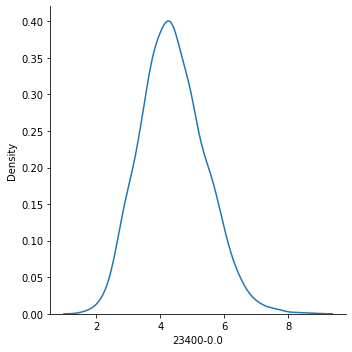

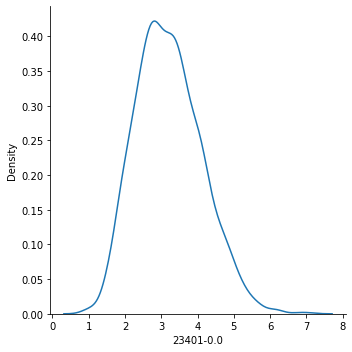

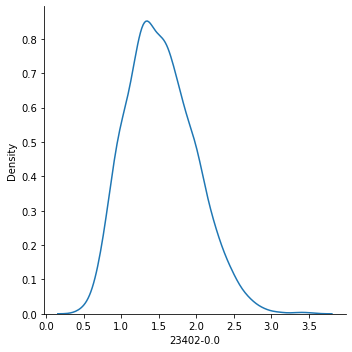

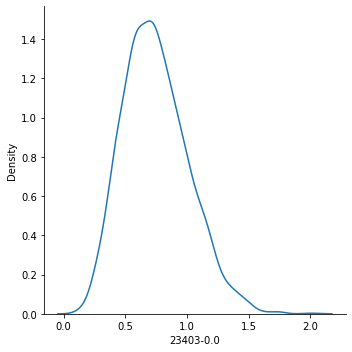

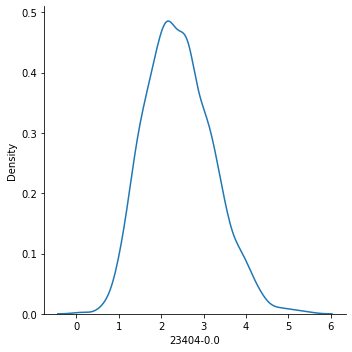

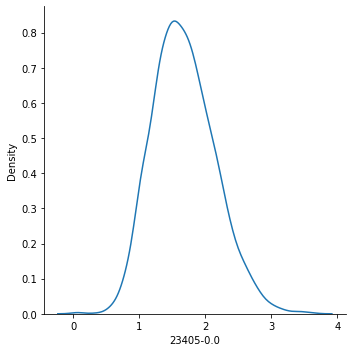

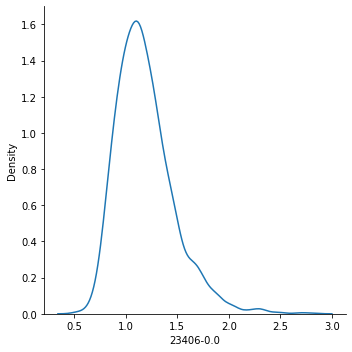

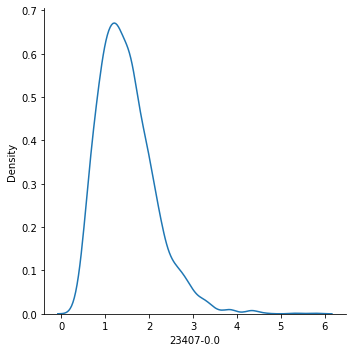

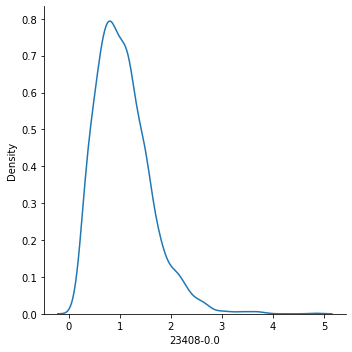

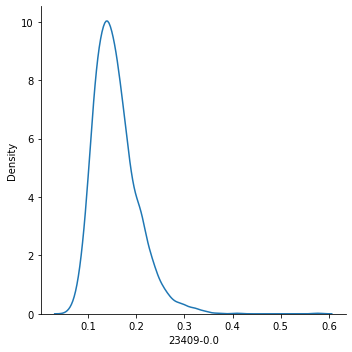

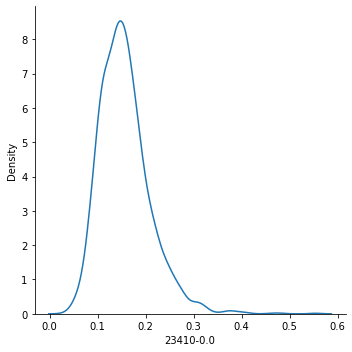

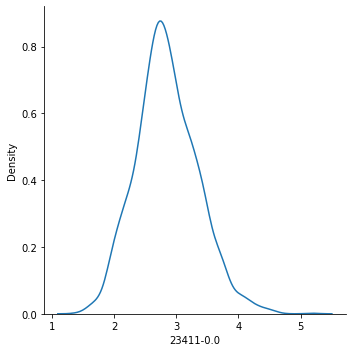

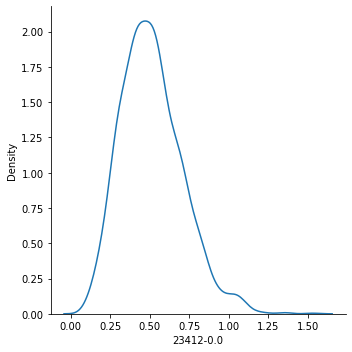

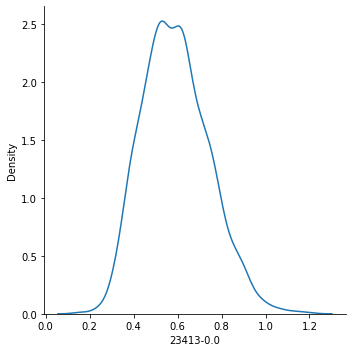

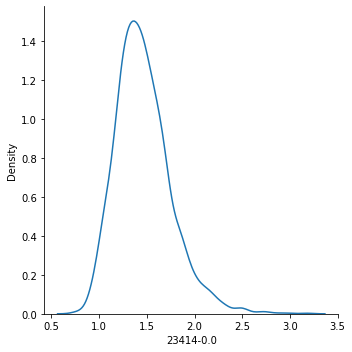

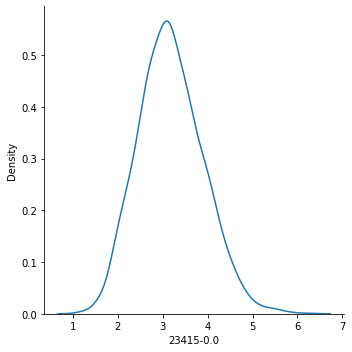

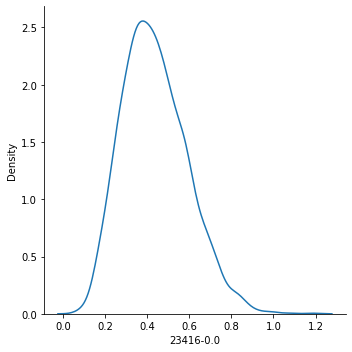

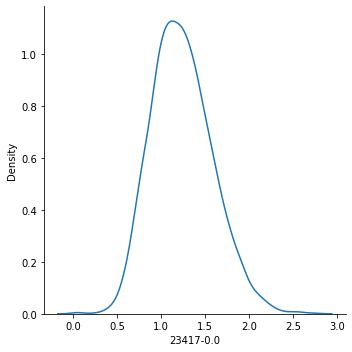

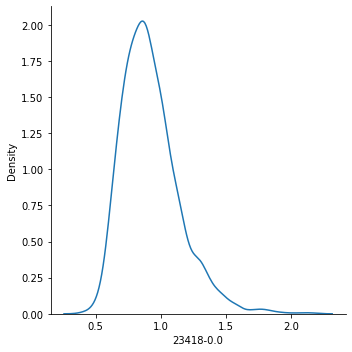

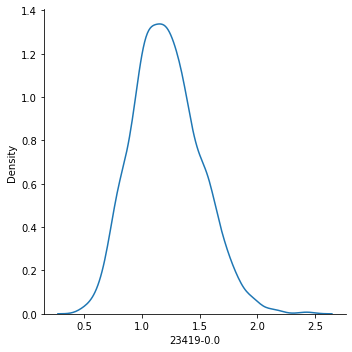

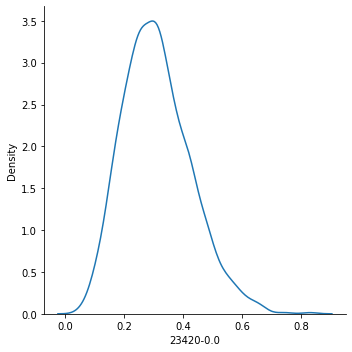

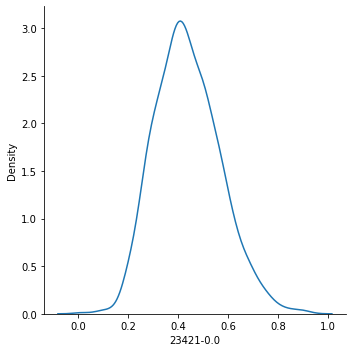

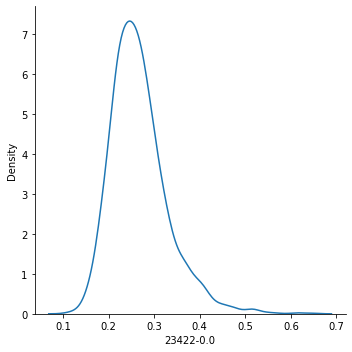

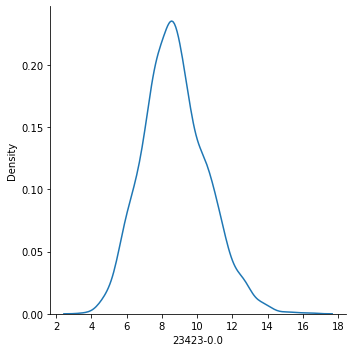

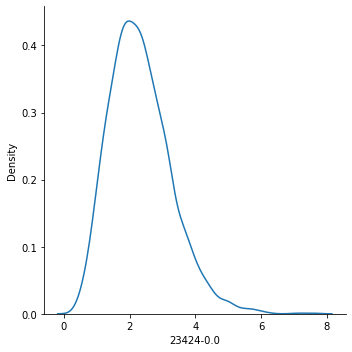

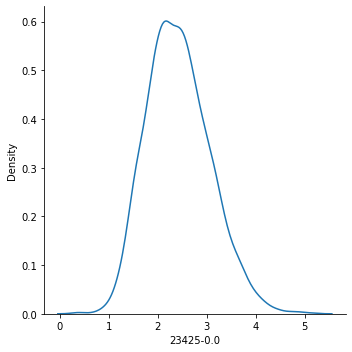

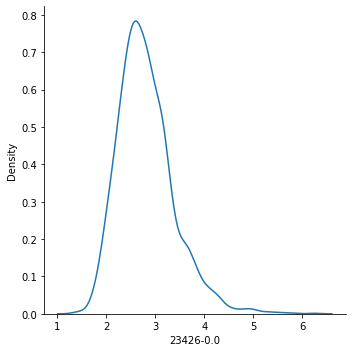

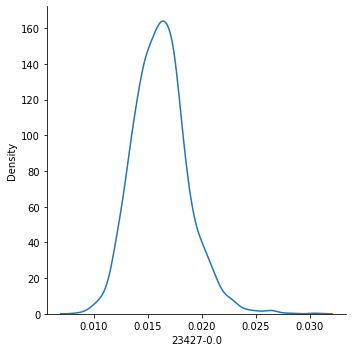

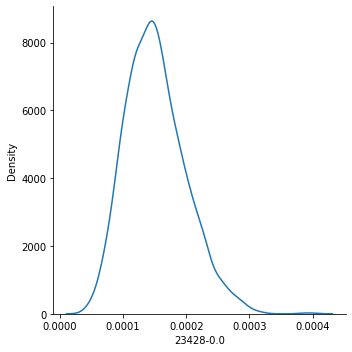

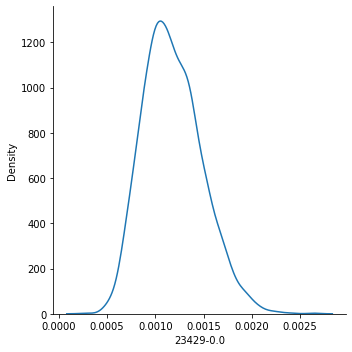

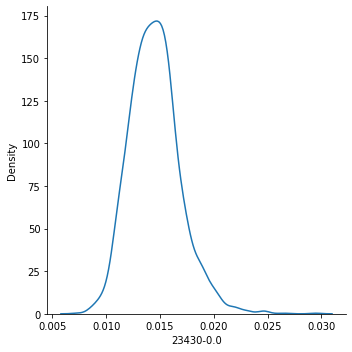

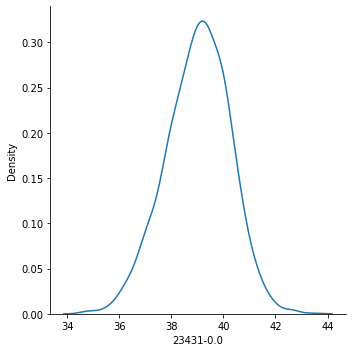

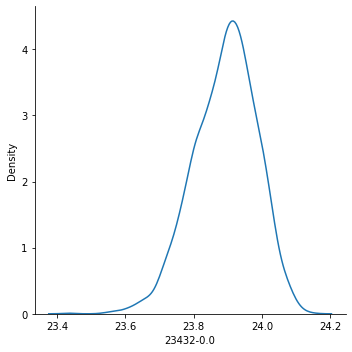

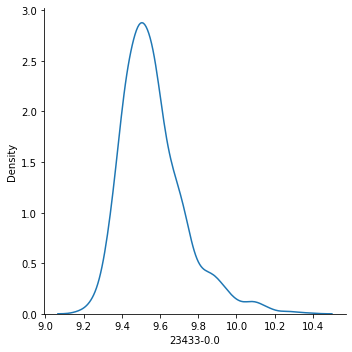

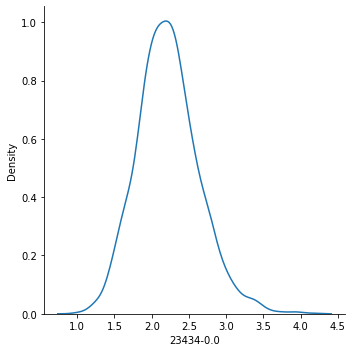

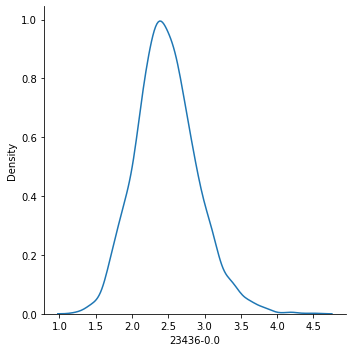

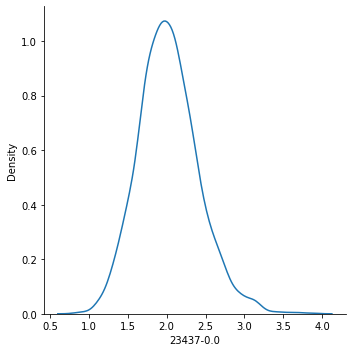

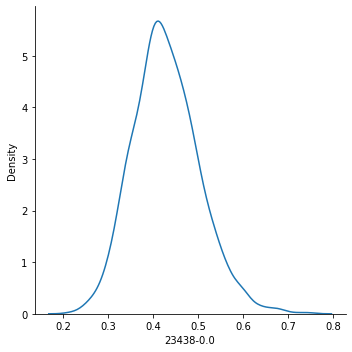

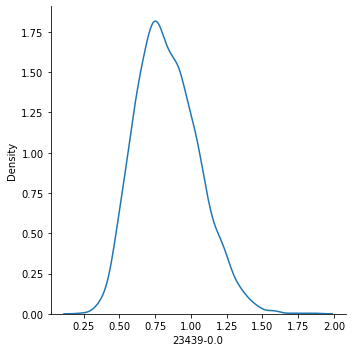

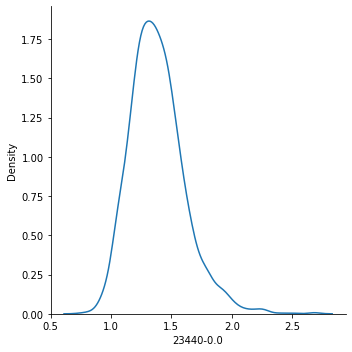

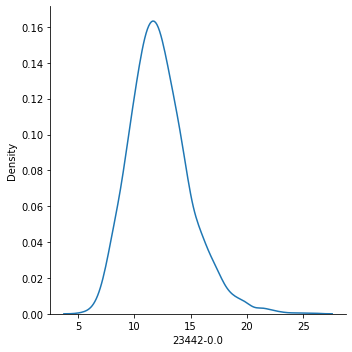

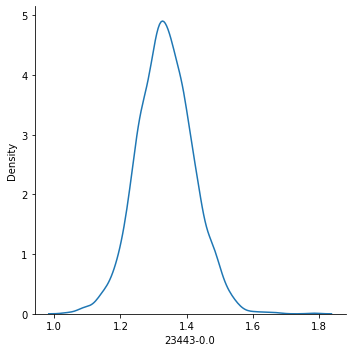

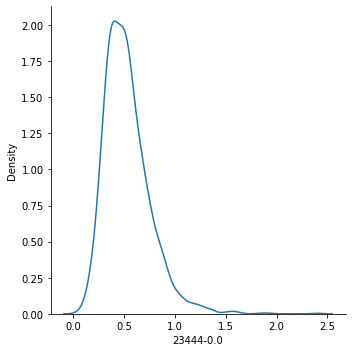

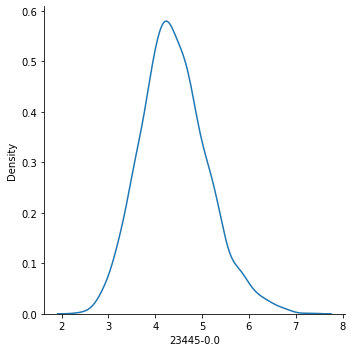

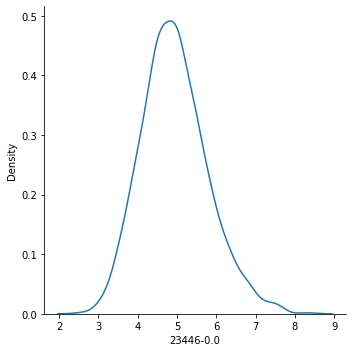

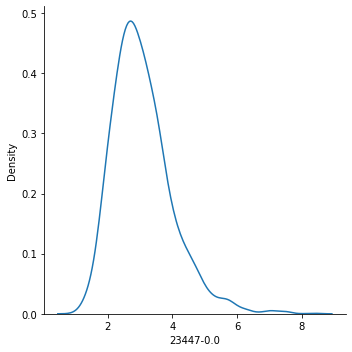

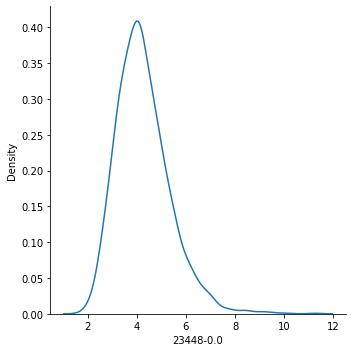

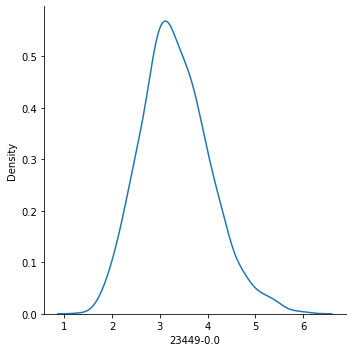

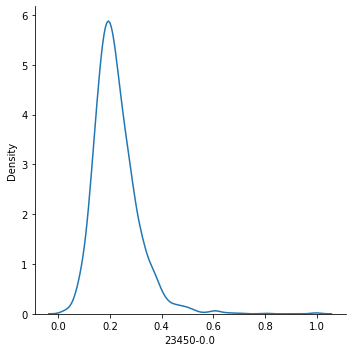

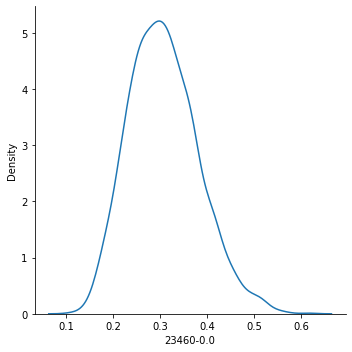

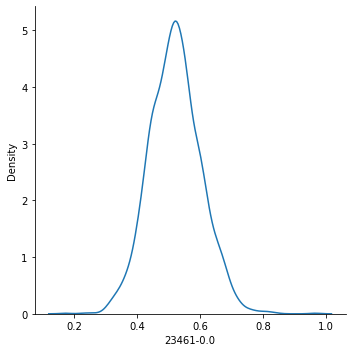

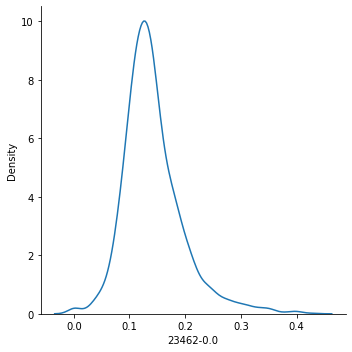

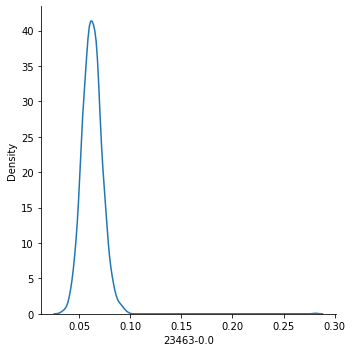

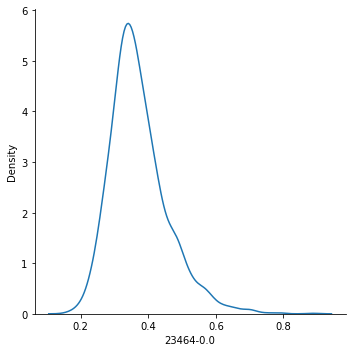

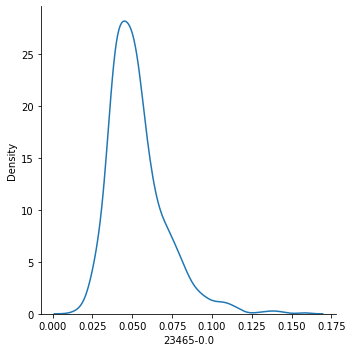

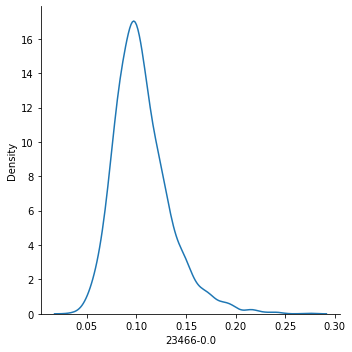

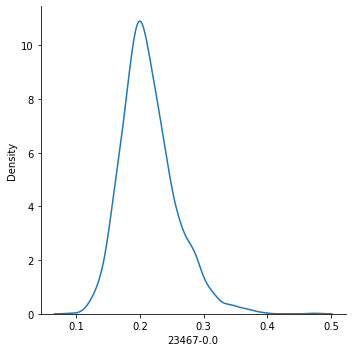

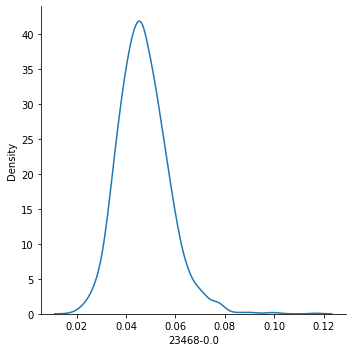

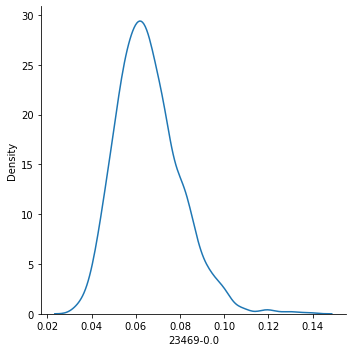

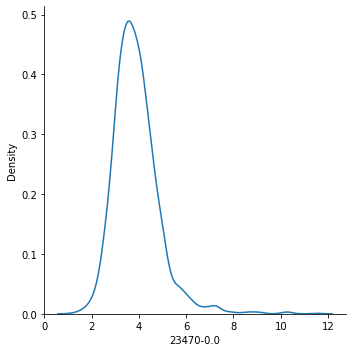

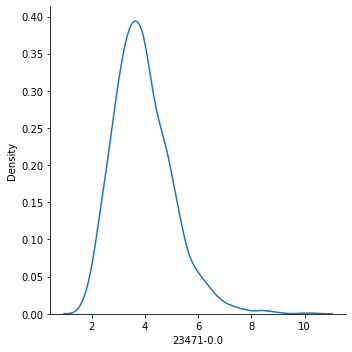

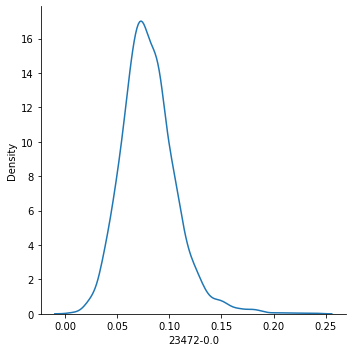

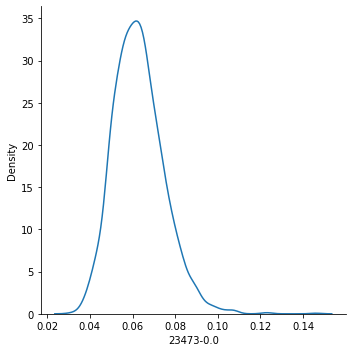

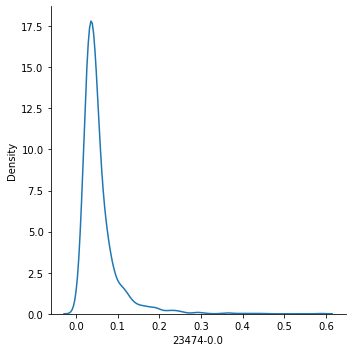

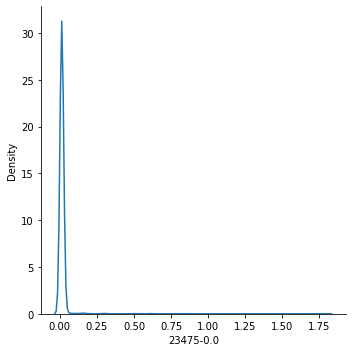

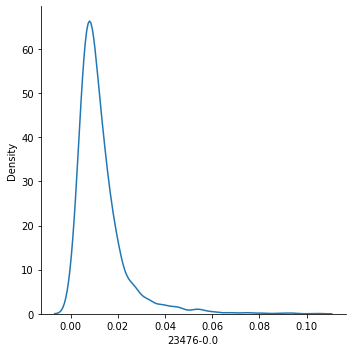

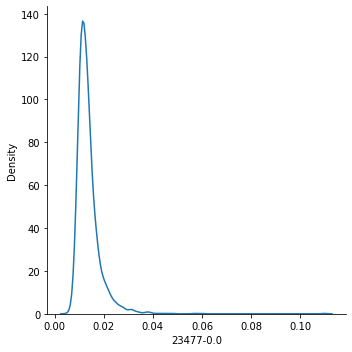

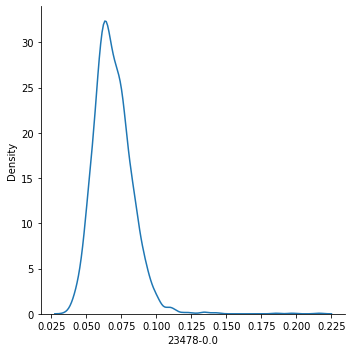

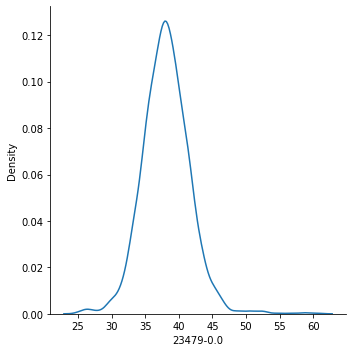

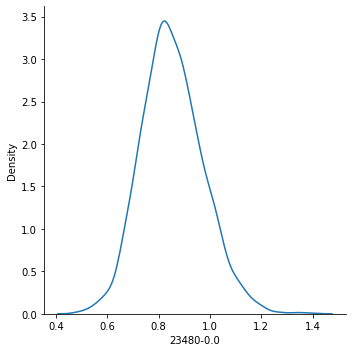

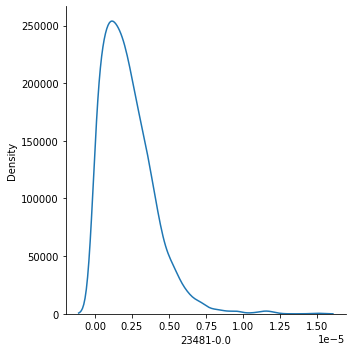

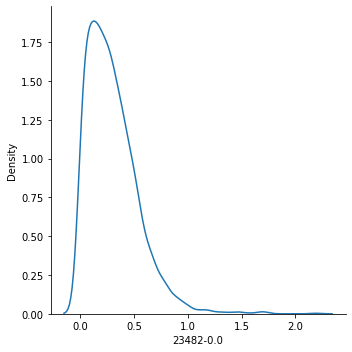

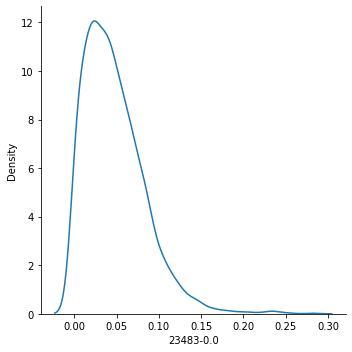

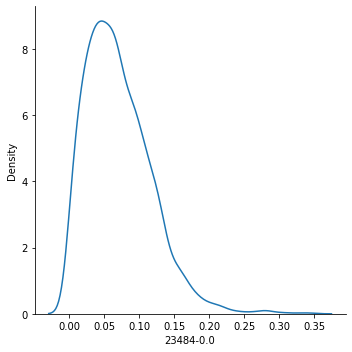

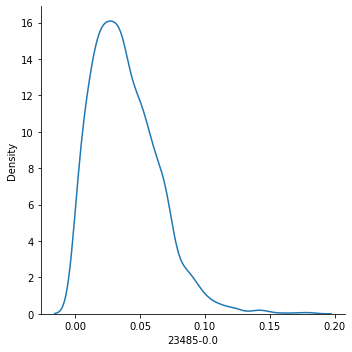

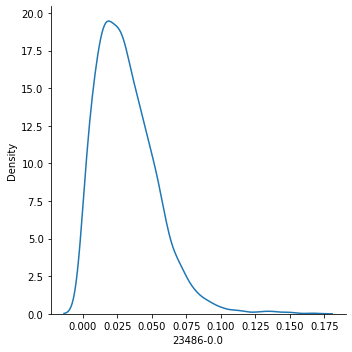

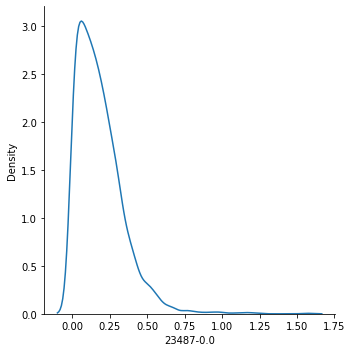

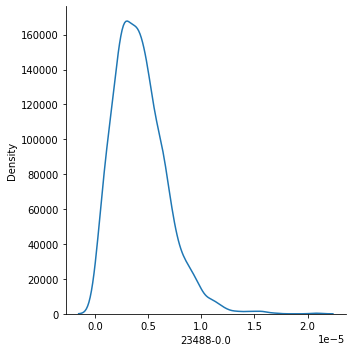

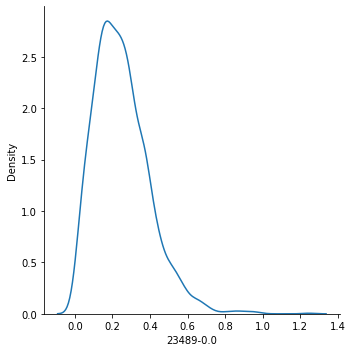

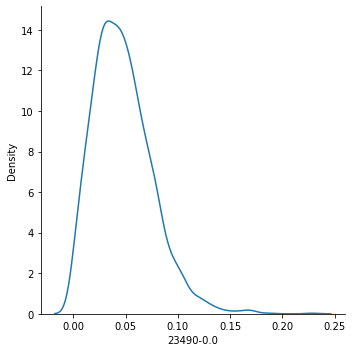

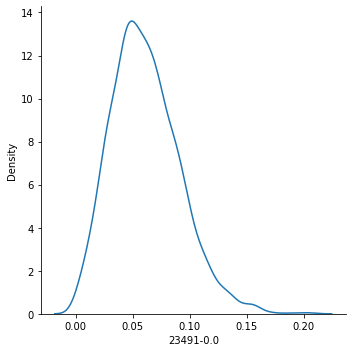

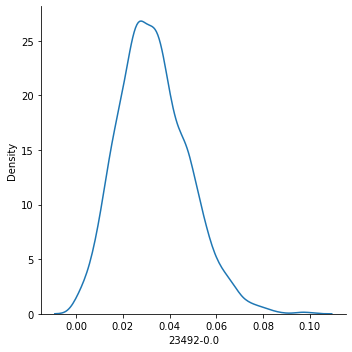

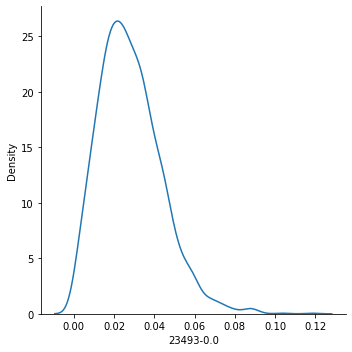

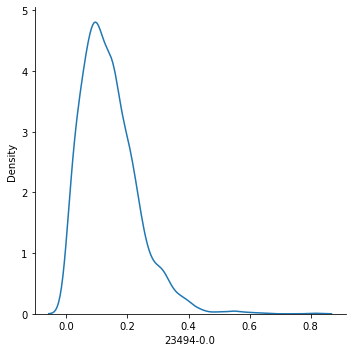

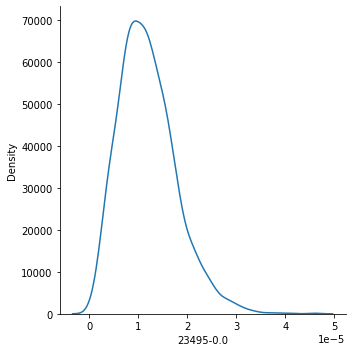

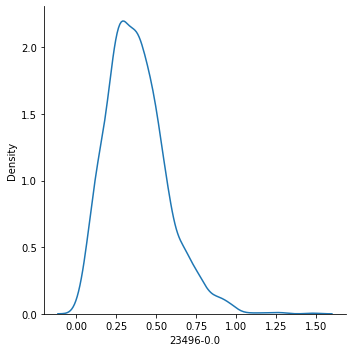

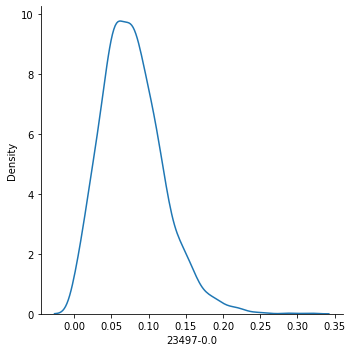

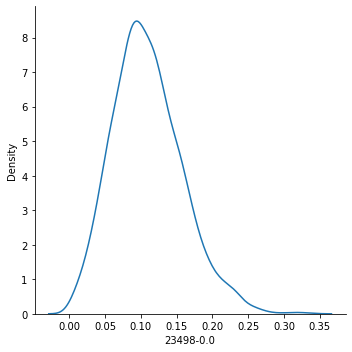

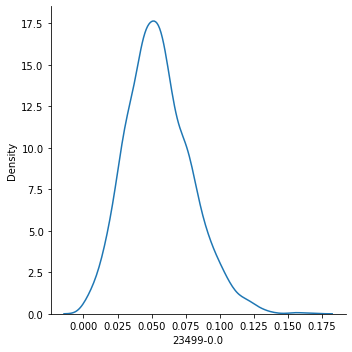

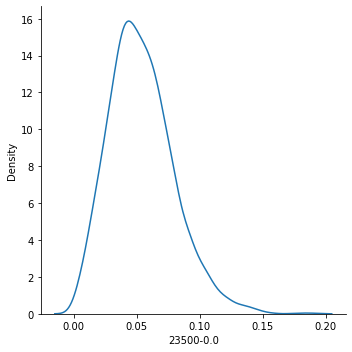

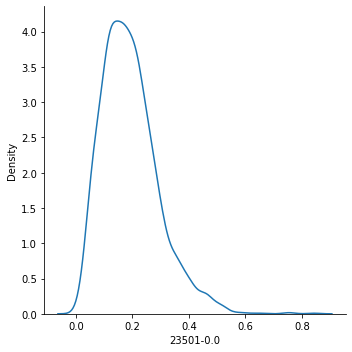

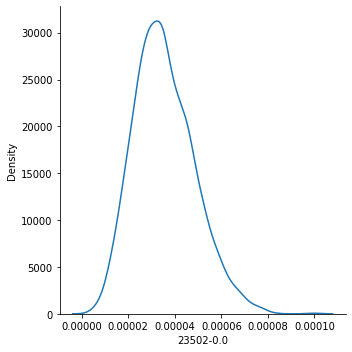

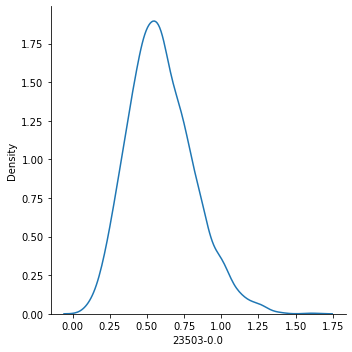

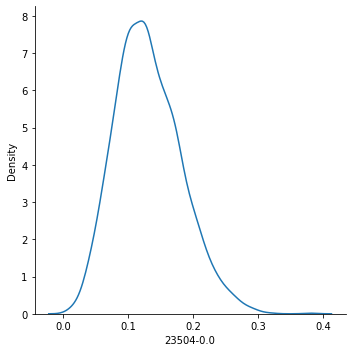

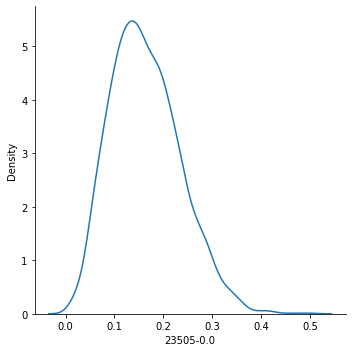

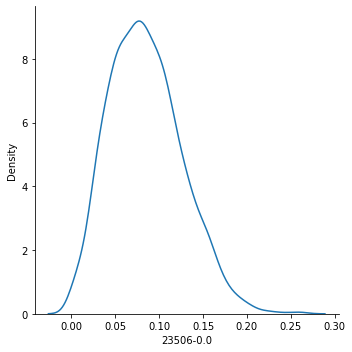

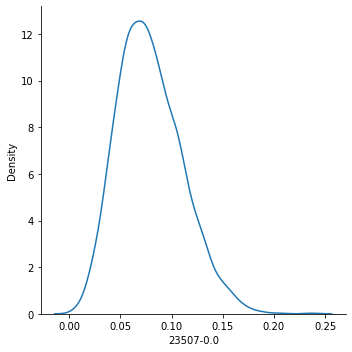

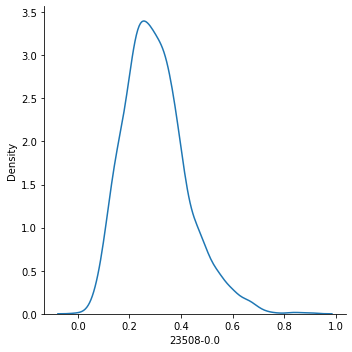

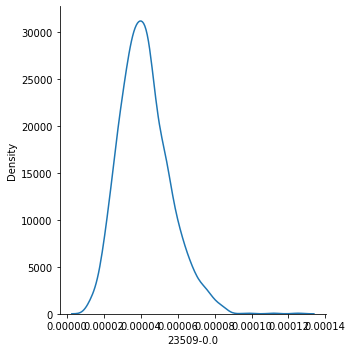

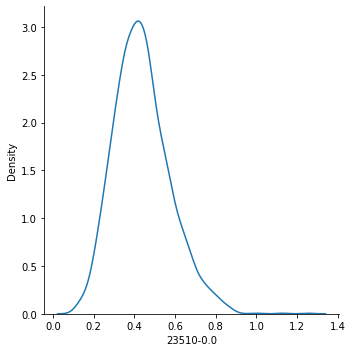

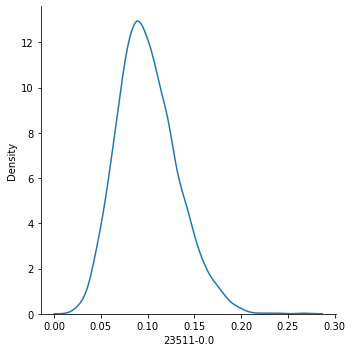

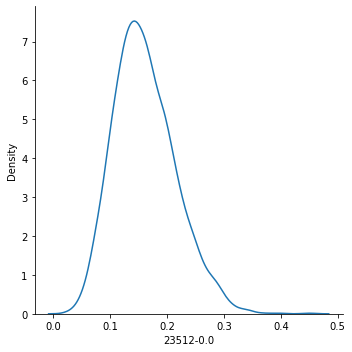

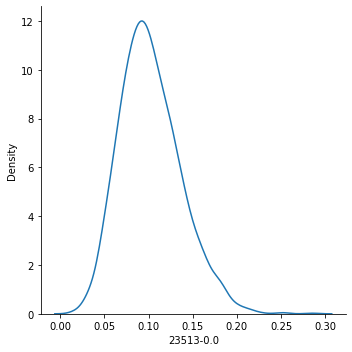

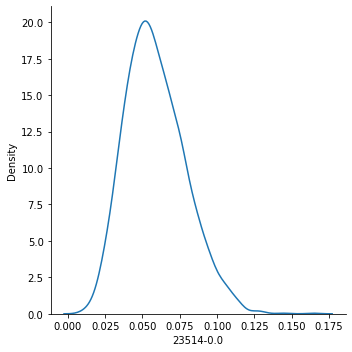

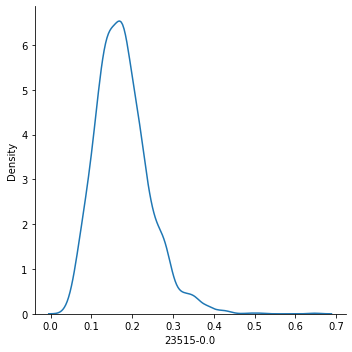

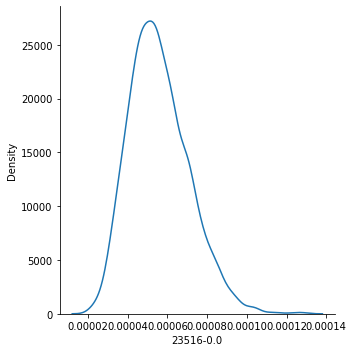

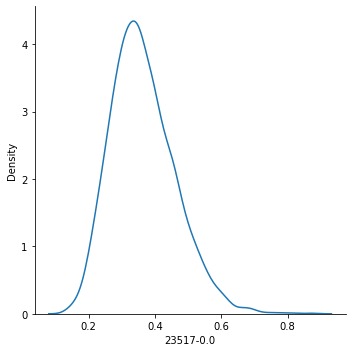

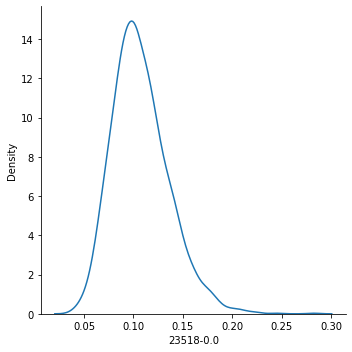

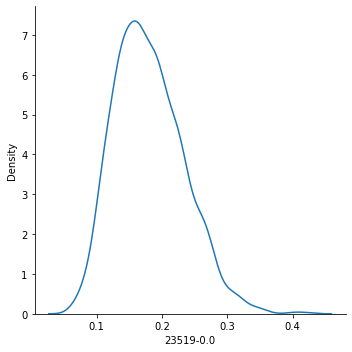

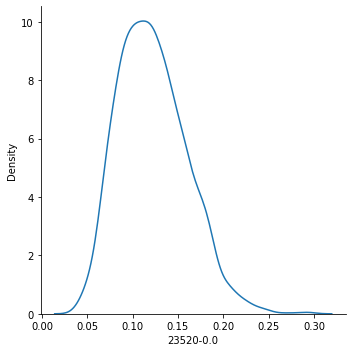

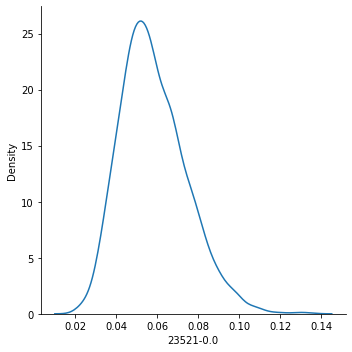

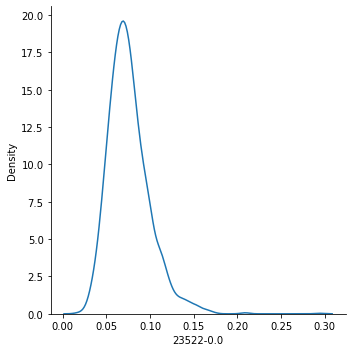

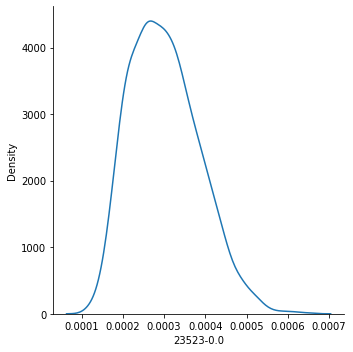

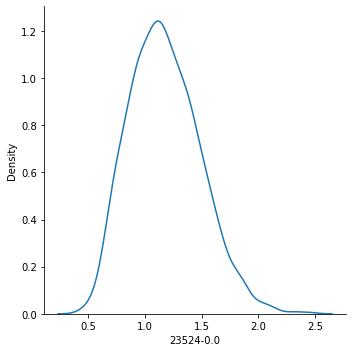

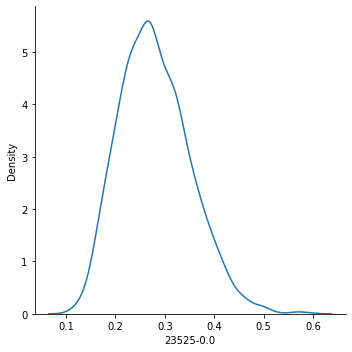

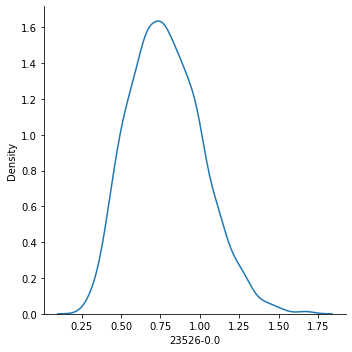

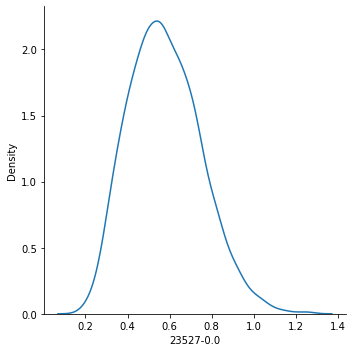

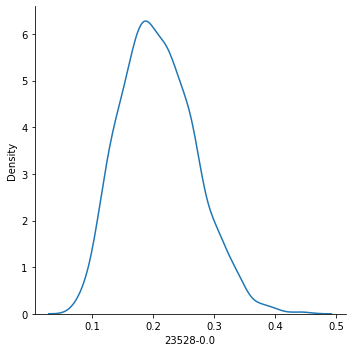

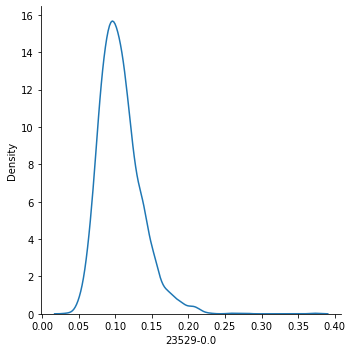

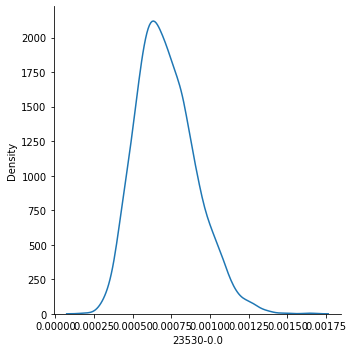

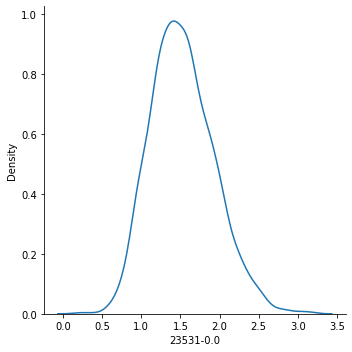

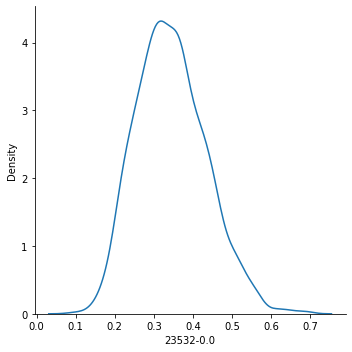

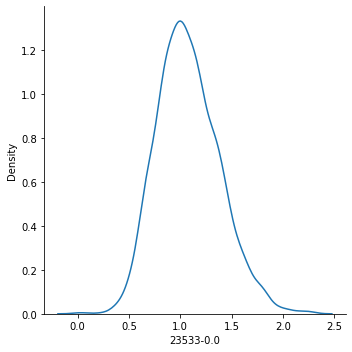

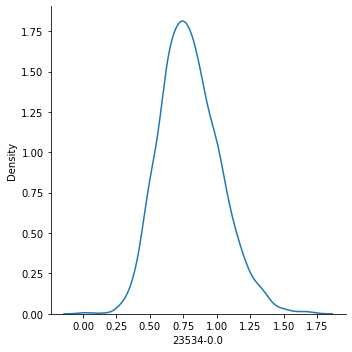

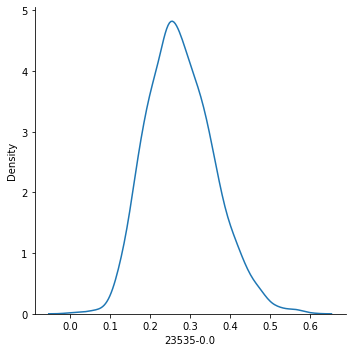

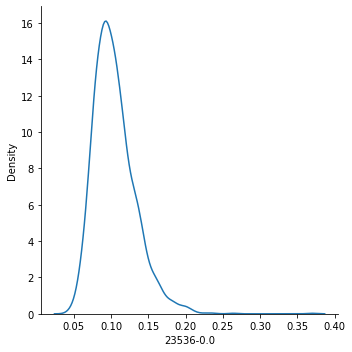

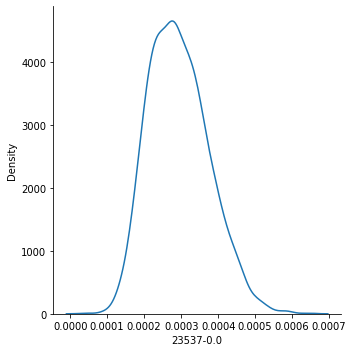

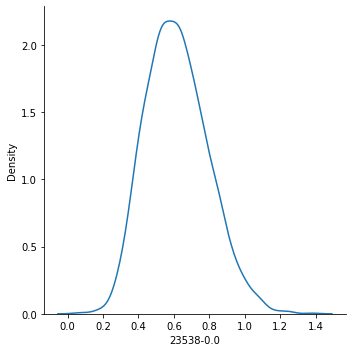

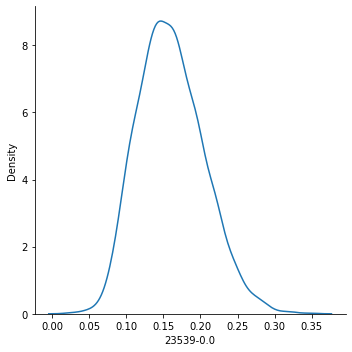

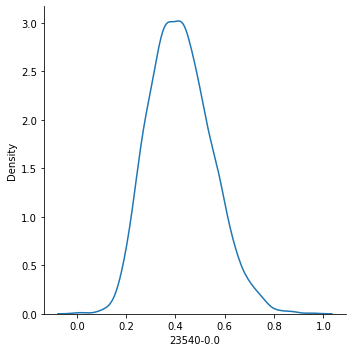

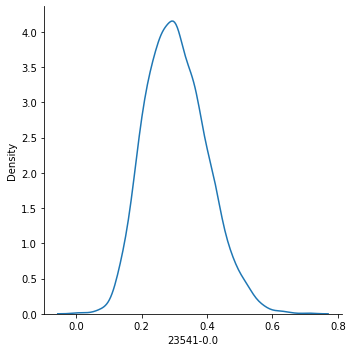

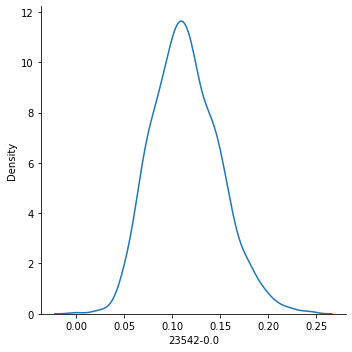

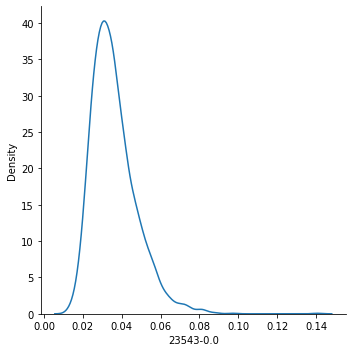

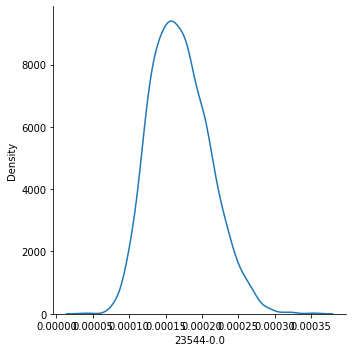

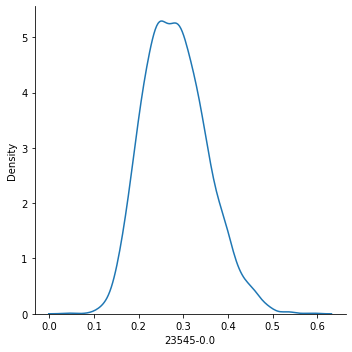

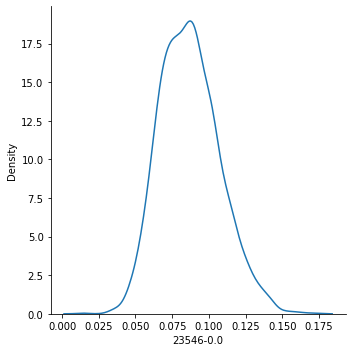

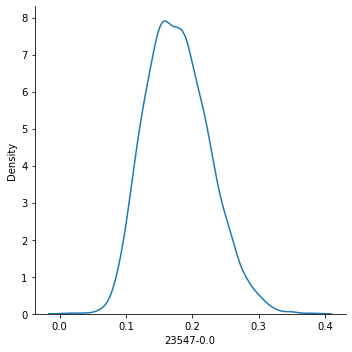

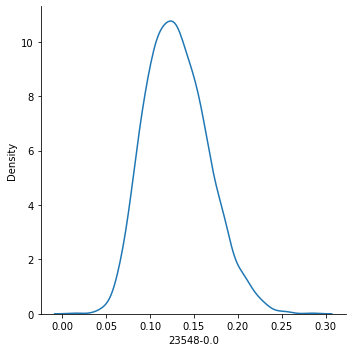

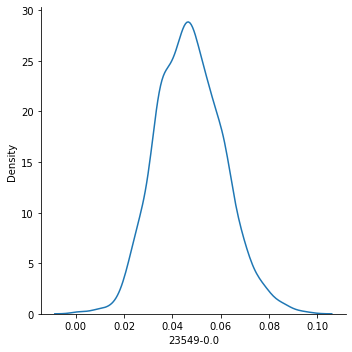

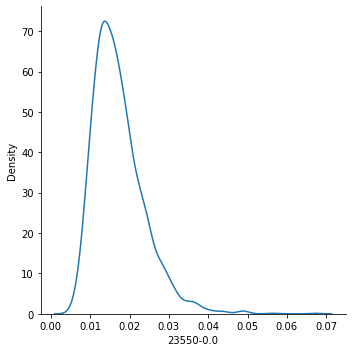

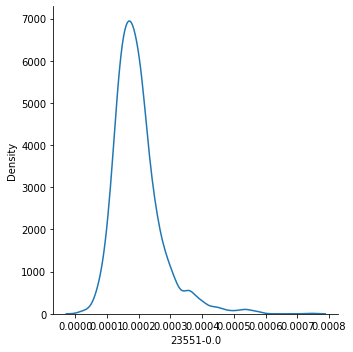

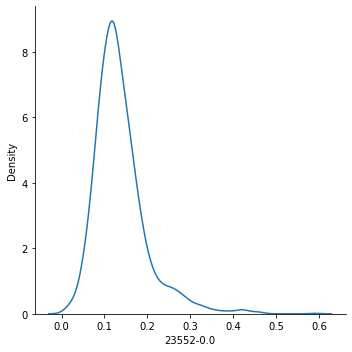

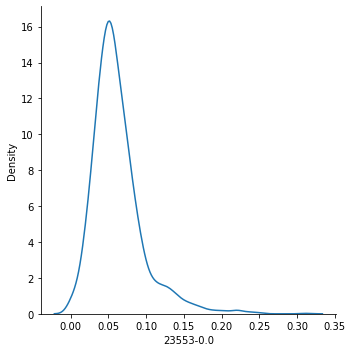

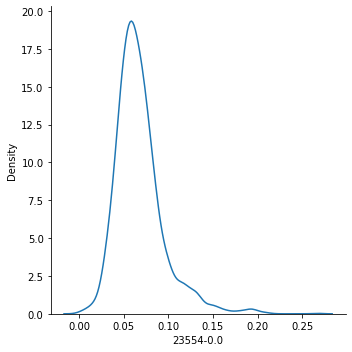

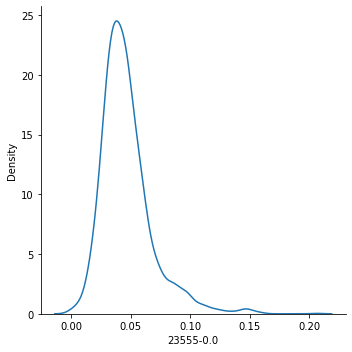

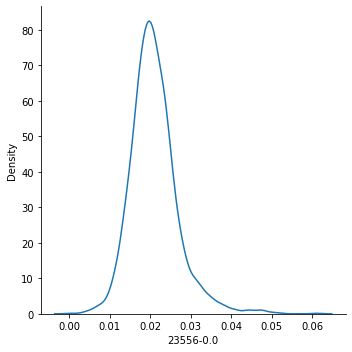

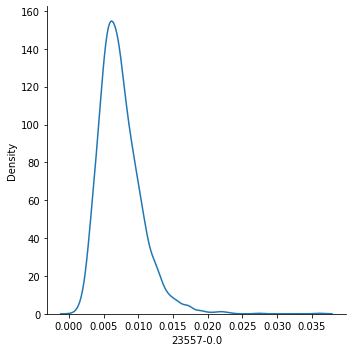

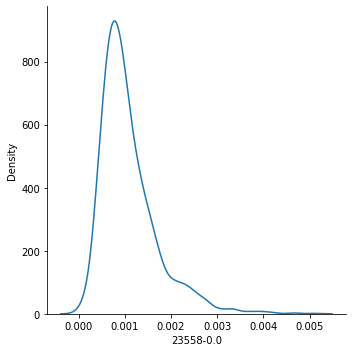

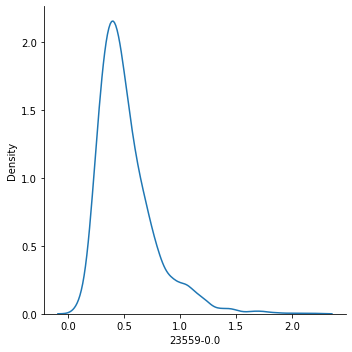

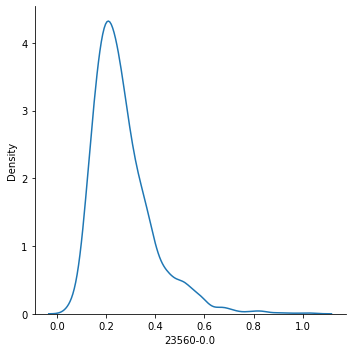

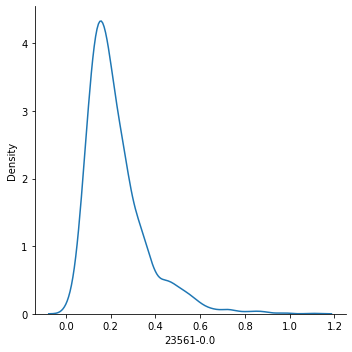

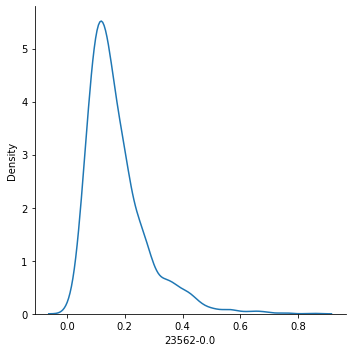

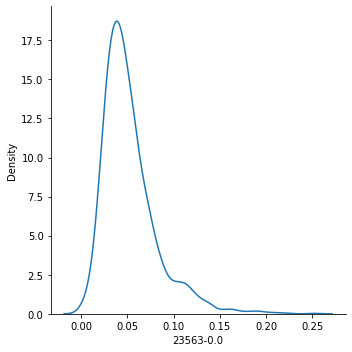

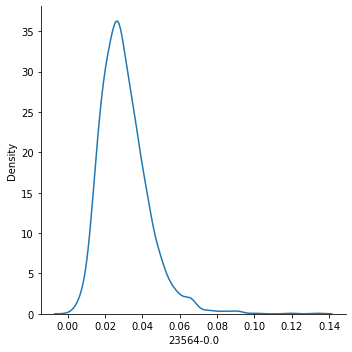

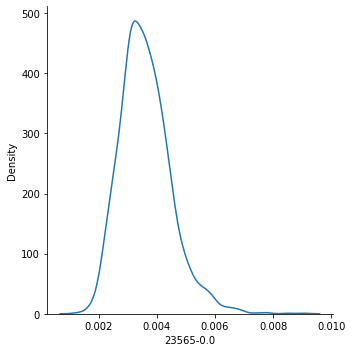

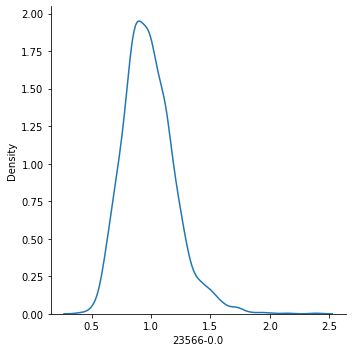

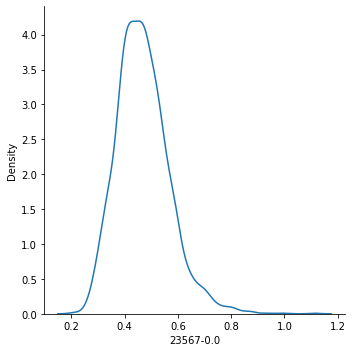

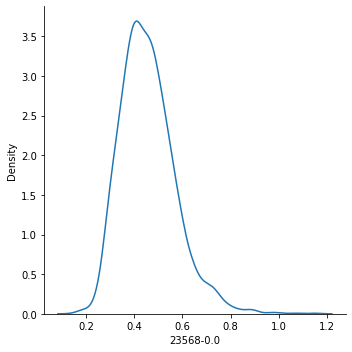

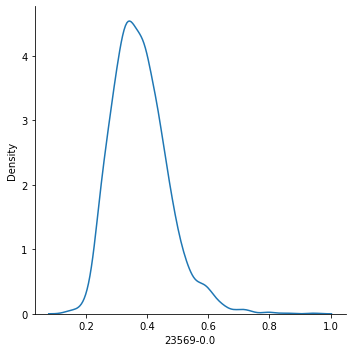

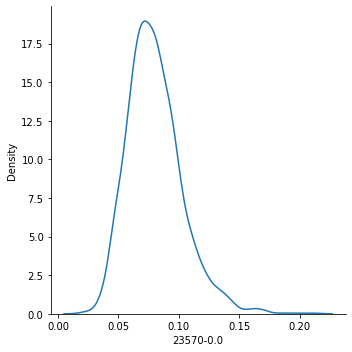

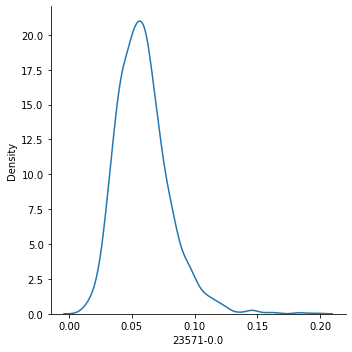

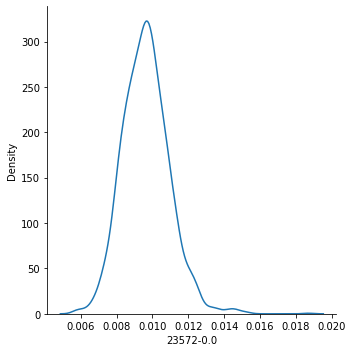

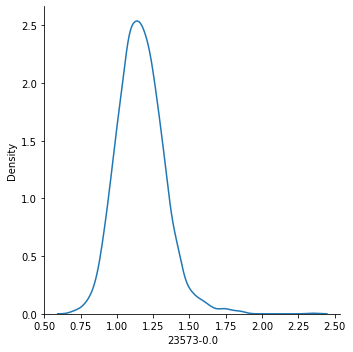

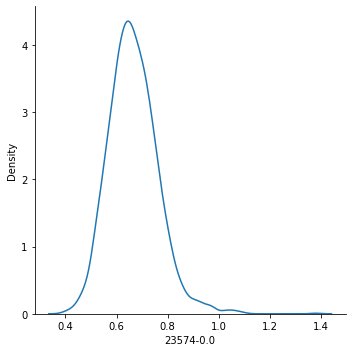

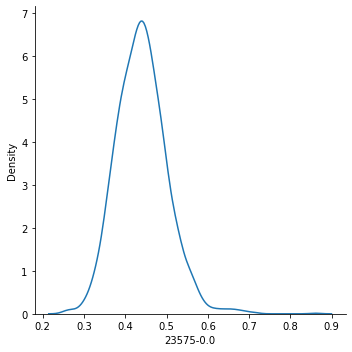

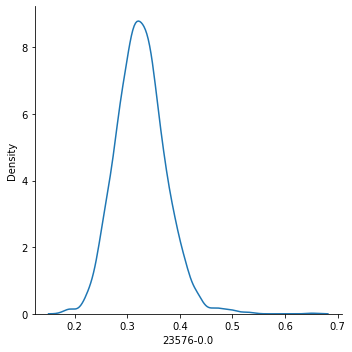

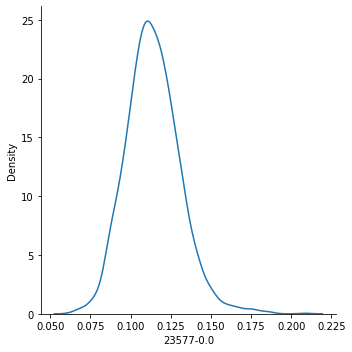

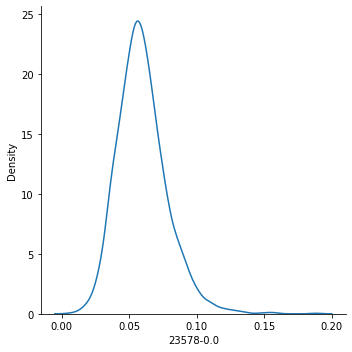

In [20]:
for col in prediabetes_with_metabolomics_continuous_only_to_keep_filtered.drop(columns = ['eid', 'target']):
    sns.displot(data=prediabetes_with_metabolomics_continuous_only_to_keep_filtered, x= col, kind="kde")

Below we show the number of NaN values remaining.

In [21]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered.isnull().sum()


eid           0
target        0
23400-0.0     0
23401-0.0     0
23402-0.0     0
23403-0.0     0
23404-0.0     0
23405-0.0     0
23406-0.0     0
23407-0.0     0
23408-0.0     0
23409-0.0     0
23410-0.0     0
23411-0.0     0
23412-0.0     0
23413-0.0     0
23414-0.0     0
23415-0.0     0
23416-0.0     0
23417-0.0     0
23418-0.0     0
23419-0.0     0
23420-0.0     0
23421-0.0     0
23422-0.0     0
23423-0.0     0
23424-0.0     0
23425-0.0     0
23426-0.0     0
23427-0.0     0
23428-0.0     0
23429-0.0     0
23430-0.0     0
23431-0.0     0
23432-0.0     0
23433-0.0     0
23434-0.0     2
23436-0.0     2
23437-0.0     2
23438-0.0     2
23439-0.0     0
23440-0.0     0
23442-0.0     2
23443-0.0     2
23444-0.0     2
23445-0.0     2
23446-0.0     2
23447-0.0     2
23448-0.0     2
23449-0.0     2
23450-0.0     2
23460-0.0     0
23461-0.0     9
23462-0.0     0
23463-0.0     6
23464-0.0     0
23465-0.0     0
23466-0.0     0
23467-0.0     0
23468-0.0     2
23469-0.0     5
23470-0.0     6
23471-0.

In [22]:
99/2339

0.042325780247969215

Below we make a bar chart for the percent of missing values for metabolomic features but only those greater than one percent.

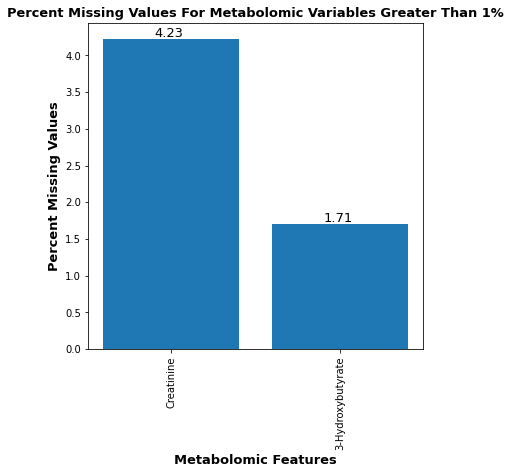

In [23]:
metabolomic_features = ['Creatinine', '3-Hydroxybutyrate']
nan_values_met = [4.23, 1.71]


plt.figure(figsize=(6,6))
for i, v in enumerate(nan_values_met):
    plt.text(i - 0.1, v + 0.03, str(v), fontsize = 13)
plt.bar(metabolomic_features, nan_values_met)
plt.title('Percent Missing Values For Metabolomic Variables Greater Than 1%', fontsize = 13, fontweight = 'bold')
plt.xlabel('Metabolomic Features', fontsize = 13, fontweight = 'bold')
plt.xticks(rotation = 90)
plt.ylabel('Percent Missing Values', fontsize = 13, fontweight = 'bold')

plt.show()

Below we make a new list of the float columns so we can fill all NaN values.

In [24]:
pd.options.display.max_rows = 10
floats_final = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.select_dtypes(include=['float64']).columns.to_list()
floats_final

['23400-0.0',
 '23401-0.0',
 '23402-0.0',
 '23403-0.0',
 '23404-0.0',
 '23405-0.0',
 '23406-0.0',
 '23407-0.0',
 '23408-0.0',
 '23409-0.0',
 '23410-0.0',
 '23411-0.0',
 '23412-0.0',
 '23413-0.0',
 '23414-0.0',
 '23415-0.0',
 '23416-0.0',
 '23417-0.0',
 '23418-0.0',
 '23419-0.0',
 '23420-0.0',
 '23421-0.0',
 '23422-0.0',
 '23423-0.0',
 '23424-0.0',
 '23425-0.0',
 '23426-0.0',
 '23427-0.0',
 '23428-0.0',
 '23429-0.0',
 '23430-0.0',
 '23431-0.0',
 '23432-0.0',
 '23433-0.0',
 '23434-0.0',
 '23436-0.0',
 '23437-0.0',
 '23438-0.0',
 '23439-0.0',
 '23440-0.0',
 '23442-0.0',
 '23443-0.0',
 '23444-0.0',
 '23445-0.0',
 '23446-0.0',
 '23447-0.0',
 '23448-0.0',
 '23449-0.0',
 '23450-0.0',
 '23460-0.0',
 '23461-0.0',
 '23462-0.0',
 '23463-0.0',
 '23464-0.0',
 '23465-0.0',
 '23466-0.0',
 '23467-0.0',
 '23468-0.0',
 '23469-0.0',
 '23470-0.0',
 '23471-0.0',
 '23472-0.0',
 '23473-0.0',
 '23474-0.0',
 '23475-0.0',
 '23476-0.0',
 '23477-0.0',
 '23478-0.0',
 '23479-0.0',
 '23480-0.0',
 '23481-0.0',
 '2348

<a class="anchor" id="KNN_Imputer"></a>
Next we perform Imputation Using k-NN with k = 5. Implementation from: https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/

In [25]:
from sklearn.impute import KNNImputer

prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.drop(columns = ['eid', 'target'])

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn)

# transform the dataset
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final = imputer.transform(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final

array([[5.0722  , 3.6887  , 1.8404  , ..., 0.29572 , 0.11002 , 0.04743 ],
       [3.7716  , 2.4546  , 1.109   , ..., 0.32234 , 0.10394 , 0.035841],
       [4.519   , 3.5896  , 1.7915  , ..., 0.28809 , 0.11022 , 0.083784],
       ...,
       [3.5629  , 2.6253  , 1.2123  , ..., 0.32932 , 0.11802 , 0.082007],
       [4.071   , 2.8931  , 1.3145  , ..., 0.36378 , 0.12425 , 0.071392],
       [5.1455  , 3.3451  , 1.4854  , ..., 0.39495 , 0.13097 , 0.037247]])

Below we create a dataframe of these values.

In [26]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df = pd.DataFrame(data=prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final, columns=prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn.columns)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0        5.0722     3.6887     1.8404    0.84379     2.8117    1.84830   
1        3.7716     2.4546     1.1090    0.42269     1.9801    1.34560   
2        4.5190     3.5896     1.7915    0.97591     2.5595    1.79800   
3        4.9518     3.1492     1.3743    0.45402     2.6832    1.77490   
4        2.9259     1.8478     0.8703    0.35565     1.3400    0.97753   
...         ...        ...        ...        ...        ...        ...   
2334     5.5147     4.2459     2.1481    1.08270     3.2354    2.09780   
2335     4.0321     2.8769     1.3677    0.64201     2.1882    1.50910   
2336     3.5629     2.6253     1.2123    0.67483     1.7881    1.41300   
2337     4.0710     2.8931     1.3145    0.72080     2.0921    1.57860   
2338     5.1455     3.3451     1.4854    0.53555     2.7781    1.85980   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23569-0.0  23570-0.0  \
0       1.38350    1.05560    0.65250    0.14697  ...    0.40360   0.089485   
1       1.31700    0.72558    0.44415    0.11384  ...    0.41526   0.083232   
2       0.92939    2.13880    1.54990    0.21661  ...    0.29014   0.065946   
3       1.80260    0.56713    0.31040    0.11897  ...    0.50841   0.108500   
4       1.07800    0.92902    0.69337    0.08373  ...    0.34595   0.066720   
...         ...        ...        ...        ...  ...        ...        ...   
2334    1.26890    1.63230    1.15280    0.17546  ...    0.39407   0.087251   
2335    1.15530    1.27490    0.91217    0.13757  ...    0.38089   0.078563   
2336    0.93761    2.31370    1.80970    0.18737  ...    0.33310   0.071334   
2337    1.17800    1.97550    1.52290    0.17258  ...    0.40807   0.085483   
2338    1.80040    0.75232    0.42868    0.12690  ...    0.56824   0.121000   

      23571-0.0  23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  \
0      0.053400   0.008862    1.07220    0.61907    0.40574    0.29572   
1      0.033200   0.009097    1.07350    0.61140    0.42628    0.32234   
2      0.086861   0.009035    1.14000    0.65788    0.39831    0.28809   
3      0.016658   0.009099    1.01750    0.56630    0.43184    0.31848   
4      0.035421   0.008057    0.97235    0.56304    0.37241    0.28323   
...         ...        ...        ...        ...        ...        ...   
2334   0.069017   0.010124    1.22800    0.70412    0.45917    0.33805   
2335   0.050539   0.009690    1.17340    0.67604    0.44390    0.33278   
2336   0.075526   0.010021    1.25460    0.72523    0.44733    0.32932   
2337   0.065454   0.010734    1.31230    0.75289    0.48803    0.36378   
2338   0.042050   0.011256    1.31080    0.74767    0.52592    0.39495   

      23577-0.0  23578-0.0  
0      0.110020   0.047430  
1      0.103940   0.035841  
2      0.110220   0.083784  
3      0.113370   0.019326  
4      0.089176   0.036902  
...         ...        ...  
2334   0.121120   0.064663  
2335   0.111120   0.053463  
2336   0.118020   0.082007  
2337   0.124250   0.071392  
2338   0.130970   0.037247  

[2339 rows x 168 columns]

Below we take the mean of every metabolomic feature.

In [27]:
for col in prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df.columns:
    print('Mean for', col, 'is:', prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].mean())

Mean for 23400-0.0 is: 4.3985346729371475
Mean for 23401-0.0 is: 3.209656938862763
Mean for 23402-0.0 is: 1.5327743736639579
Mean for 23403-0.0 is: 0.746020884993586
Mean for 23404-0.0 is: 2.428404082086359
Mean for 23405-0.0 is: 1.676883534843952
Mean for 23406-0.0 is: 1.1888769559640842
Mean for 23407-0.0 is: 1.4920703676784928
Mean for 23408-0.0 is: 1.0707826079521179
Mean for 23409-0.0 is: 0.1578044561778541
Mean for 23410-0.0 is: 0.15649221333903385
Mean for 23411-0.0 is: 2.8475737922188986
Mean for 23412-0.0 is: 0.5117573544249667
Mean for 23413-0.0 is: 0.5919015733219332
Mean for 23414-0.0 is: 1.4637553997434791
Mean for 23415-0.0 is: 3.1832853783668282
Mean for 23416-0.0 is: 0.4361344728516457
Mean for 23417-0.0 is: 1.2385015079093595
Mean for 23418-0.0 is: 0.9215712056434368
Mean for 23419-0.0 is: 1.2152491363830678
Mean for 23420-0.0 is: 0.3098866327490386
Mean for 23421-0.0 is: 0.43838145938435236
Mean for 23422-0.0 is: 0.26730657973492983
Mean for 23423-0.0 is: 8.7381808892

Below we show which metabolomic data distributions are normal and which are not normal using the Shapiro-Wilk test. This is important for our statistical testing further on.

In [28]:
import scipy.stats as stats

normal_metabolites = []
not_normal_metabolites = []

for col in prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df.columns:
    w, pvalue = stats.shapiro(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col])
    print('For feature:', col, 'Shapiro test statistic is:', w, 'With padjusted (pval*168):', pvalue)
    if pvalue*168 < 0.05:
        not_normal_metabolites.append(col)
        print('-------------------NOT NORMAL-----------------')
    else:
        normal_metabolites.append(col)
        print('-------------------NORMAL-----------------')

For feature: 23400-0.0 Shapiro test statistic is: 0.9926098585128784 With padjusted (pval*168): 1.6382571965678494e-09
-------------------NOT NORMAL-----------------
For feature: 23401-0.0 Shapiro test statistic is: 0.9882523417472839 With padjusted (pval*168): 6.110207825815728e-13
-------------------NOT NORMAL-----------------
For feature: 23402-0.0 Shapiro test statistic is: 0.9865480065345764 With padjusted (pval*168): 4.687404774766403e-14
-------------------NOT NORMAL-----------------
For feature: 23403-0.0 Shapiro test statistic is: 0.9841951131820679 With padjusted (pval*168): 1.8934386038091866e-15
-------------------NOT NORMAL-----------------
For feature: 23404-0.0 Shapiro test statistic is: 0.9892460107803345 With padjusted (pval*168): 3.0611492073812085e-12
-------------------NOT NORMAL-----------------
For feature: 23405-0.0 Shapiro test statistic is: 0.9900402426719666 With padjusted (pval*168): 1.190730760519676e-11
-------------------NOT NORMAL-----------------
For fea

For feature: 23460-0.0 Shapiro test statistic is: 0.988315999507904 With padjusted (pval*168): 6.756170059171729e-13
-------------------NOT NORMAL-----------------
For feature: 23461-0.0 Shapiro test statistic is: 0.9958756566047668 With padjusted (pval*168): 4.820469712285558e-06
-------------------NOT NORMAL-----------------
For feature: 23462-0.0 Shapiro test statistic is: 0.9248075485229492 With padjusted (pval*168): 1.0519019931560691e-32
-------------------NOT NORMAL-----------------
For feature: 23463-0.0 Shapiro test statistic is: 0.8674162030220032 With padjusted (pval*168): 1.114564772554673e-40
-------------------NOT NORMAL-----------------
For feature: 23464-0.0 Shapiro test statistic is: 0.9475915431976318 With padjusted (pval*168): 4.214772016362594e-28
-------------------NOT NORMAL-----------------
For feature: 23465-0.0 Shapiro test statistic is: 0.9117856025695801 With padjusted (pval*168): 7.380280440621527e-35
-------------------NOT NORMAL-----------------
For featur

For feature: 23510-0.0 Shapiro test statistic is: 0.9801120162010193 With padjusted (pval*168): 1.4608773932572468e-17
-------------------NOT NORMAL-----------------
For feature: 23511-0.0 Shapiro test statistic is: 0.9845162034034729 With padjusted (pval*168): 2.875694643620242e-15
-------------------NOT NORMAL-----------------
For feature: 23512-0.0 Shapiro test statistic is: 0.981955885887146 With padjusted (pval*168): 1.1944274963539926e-16
-------------------NOT NORMAL-----------------
For feature: 23513-0.0 Shapiro test statistic is: 0.9818296432495117 With padjusted (pval*168): 1.0295748339602575e-16
-------------------NOT NORMAL-----------------
For feature: 23514-0.0 Shapiro test statistic is: 0.982912540435791 With padjusted (pval*168): 3.7715605755309696e-16
-------------------NOT NORMAL-----------------
For feature: 23515-0.0 Shapiro test statistic is: 0.9604519605636597 With padjusted (pval*168): 9.114400291310418e-25
-------------------NOT NORMAL-----------------
For feat

For feature: 23577-0.0 Shapiro test statistic is: 0.9832850694656372 With padjusted (pval*168): 5.973235580576739e-16
-------------------NOT NORMAL-----------------
For feature: 23578-0.0 Shapiro test statistic is: 0.9637381434440613 With padjusted (pval*168): 8.754861945398742e-24
-------------------NOT NORMAL-----------------


Now we have to normalize all the float columns so that they have values between 0 and 1. We do this by dividing each value in a column by using min-max normalization.

In [29]:
for col in floats_final:
    prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col] = (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col] - prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].min()) / (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].max() - prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].min())
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23569-0.0  23570-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.330396   0.363306   
1      0.345652   0.073043   0.067466   0.103913  ...   0.344825   0.330879   
2      0.177170   0.333359   0.303467   0.302916  ...   0.189997   0.241236   
3      0.556726   0.043856   0.038919   0.113847  ...   0.460093   0.461915   
4      0.241766   0.110517   0.120657   0.045608  ...   0.259058   0.245250   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.318604   0.351721   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.302294   0.306666   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.243157   0.269177   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.335928   0.342552   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.534129   0.526738   

      23571-0.0  23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  \
0      0.235669   0.243458   0.228702   0.226876   0.250734   0.244515   
1      0.127482   0.261577   0.229491   0.219080   0.284609   0.301056   
2      0.414881   0.256776   0.269833   0.266324   0.238480   0.228309   
3      0.038885   0.261708   0.195518   0.173240   0.293779   0.292857   
4      0.139377   0.181507   0.168128   0.169926   0.195765   0.217986   
...         ...        ...        ...        ...        ...        ...   
2334   0.319311   0.340555   0.323218   0.313323   0.338853   0.334424   
2335   0.220346   0.307195   0.290095   0.284782   0.313669   0.323230   
2336   0.354173   0.332631   0.339355   0.334780   0.319326   0.315881   
2337   0.300229   0.387488   0.374359   0.362894   0.386450   0.389074   
2338   0.174881   0.427650   0.373449   0.357589   0.448940   0.455279   

      23577-0.0  23578-0.0  
0      0.321751   0.224446  
1      0.279932   0.160634  
2      0.323126   0.424620  
3      0.344792   0.069699  
4      0.178384   0.166476  
...         ...        ...  
2334   0.398098   0.319335  
2335   0.329317   0.257665  
2336   0.376775   0.414835  
2337   0.419626   0.356386  
2338   0.465847   0.168376  

[2339 rows x 168 columns]

Below we add the eid column back.

In [30]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df['eid'] = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.reset_index(inplace = False)['eid']
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23570-0.0  23571-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.363306   0.235669   
1      0.345652   0.073043   0.067466   0.103913  ...   0.330879   0.127482   
2      0.177170   0.333359   0.303467   0.302916  ...   0.241236   0.414881   
3      0.556726   0.043856   0.038919   0.113847  ...   0.461915   0.038885   
4      0.241766   0.110517   0.120657   0.045608  ...   0.245250   0.139377   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.351721   0.319311   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.306666   0.220346   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.269177   0.354173   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.342552   0.300229   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.526738   0.174881   

      23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  23577-0.0  \
0      0.243458   0.228702   0.226876   0.250734   0.244515   0.321751   
1      0.261577   0.229491   0.219080   0.284609   0.301056   0.279932   
2      0.256776   0.269833   0.266324   0.238480   0.228309   0.323126   
3      0.261708   0.195518   0.173240   0.293779   0.292857   0.344792   
4      0.181507   0.168128   0.169926   0.195765   0.217986   0.178384   
...         ...        ...        ...        ...        ...        ...   
2334   0.340555   0.323218   0.313323   0.338853   0.334424   0.398098   
2335   0.307195   0.290095   0.284782   0.313669   0.323230   0.329317   
2336   0.332631   0.339355   0.334780   0.319326   0.315881   0.376775   
2337   0.387488   0.374359   0.362894   0.386450   0.389074   0.419626   
2338   0.427650   0.373449   0.357589   0.448940   0.455279   0.465847   

      23578-0.0      eid  
0      0.224446  1000809  
1      0.160634  1005686  
2      0.424620  1005936  
3      0.069699  1007333  
4      0.166476  1016167  
...         ...      ...  
2334   0.319335  6017696  
2335   0.257665  6017753  
2336   0.414835  6017871  
2337   0.356386  6018114  
2338   0.168376  6024393  

[2339 rows x 169 columns]

Below we create a list of these eid numbers.

In [31]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df_with_eid = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df_with_eid

[1000809,
 1005686,
 1005936,
 1007333,
 1016167,
 1017443,
 1018119,
 1025405,
 1025738,
 1026007,
 1027978,
 1030454,
 1034056,
 1035811,
 1036940,
 1037932,
 1039510,
 1040950,
 1041652,
 1042924,
 1043213,
 1045764,
 1046313,
 1048428,
 1049423,
 1049710,
 1050906,
 1052513,
 1056375,
 1056980,
 1062604,
 1063648,
 1063856,
 1068154,
 1068882,
 1069867,
 1072504,
 1073266,
 1075104,
 1075927,
 1076087,
 1077768,
 1082613,
 1084010,
 1086687,
 1087122,
 1087380,
 1090737,
 1094263,
 1094700,
 1097020,
 1098087,
 1099030,
 1099336,
 1099911,
 1101247,
 1102293,
 1102744,
 1102863,
 1104962,
 1106386,
 1107380,
 1115680,
 1116252,
 1117967,
 1120584,
 1120681,
 1125079,
 1125452,
 1128480,
 1128721,
 1130724,
 1137127,
 1145728,
 1147334,
 1148003,
 1149894,
 1150077,
 1151556,
 1151952,
 1155943,
 1157575,
 1168769,
 1169079,
 1169859,
 1174474,
 1177141,
 1177496,
 1179607,
 1185015,
 1192821,
 1193061,
 1196100,
 1196563,
 1200313,
 1201409,
 1201497,
 1202179,
 1202941,
 1204760,


<a class="anchor" id="Adding_covariates"></a>
# Below we account for covariates of sex, age, and ethnic backgound.

Below we add the sex, ethnicity, and age information to the dataframe. We will use these later on to account for the covariates and see if this changes the results of the model.

In [32]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df.merge(prediabetes_with_features[['eid', '31-0.0', '21003-0.0', '21000-0.0']], on = 'eid')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23573-0.0  23574-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.228702   0.226876   
1      0.345652   0.073043   0.067466   0.103913  ...   0.229491   0.219080   
2      0.177170   0.333359   0.303467   0.302916  ...   0.269833   0.266324   
3      0.556726   0.043856   0.038919   0.113847  ...   0.195518   0.173240   
4      0.241766   0.110517   0.120657   0.045608  ...   0.168128   0.169926   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.323218   0.313323   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.290095   0.284782   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.339355   0.334780   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.374359   0.362894   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.373449   0.357589   

      23575-0.0  23576-0.0  23577-0.0  23578-0.0      eid  31-0.0  21003-0.0  \
0      0.250734   0.244515   0.321751   0.224446  1000809       0         50   
1      0.284609   0.301056   0.279932   0.160634  1005686       0         67   
2      0.238480   0.228309   0.323126   0.424620  1005936       1         61   
3      0.293779   0.292857   0.344792   0.069699  1007333       1         57   
4      0.195765   0.217986   0.178384   0.166476  1016167       0         64   
...         ...        ...        ...        ...      ...     ...        ...   
2334   0.338853   0.334424   0.398098   0.319335  6017696       0         61   
2335   0.313669   0.323230   0.329317   0.257665  6017753       1         55   
2336   0.319326   0.315881   0.376775   0.414835  6017871       1         50   
2337   0.386450   0.389074   0.419626   0.356386  6018114       0         61   
2338   0.448940   0.455279   0.465847   0.168376  6024393       0         63   

      21000-0.0  
0        3001.0  
1        1001.0  
2        1001.0  
3        4001.0  
4        3001.0  
...         ...  
2334        6.0  
2335        6.0  
2336     1001.0  
2337     1001.0  
2338     1001.0  

[2339 rows x 172 columns]

Below we show how many nan values are in the added sex, age, and race columns. We see that there are only 6 patients without a value in the race column, and therefore we can go ahead with our usual coding of ethnic background.

In [33]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.isnull().sum()

23400-0.0    0
23401-0.0    0
23402-0.0    0
23403-0.0    0
23404-0.0    0
            ..
23578-0.0    0
eid          0
31-0.0       0
21003-0.0    0
21000-0.0    6
Length: 172, dtype: int64

Next we create a column that specifies if a person is greater than or equal to 60 years of age. We suspect that age has an impact on metabolomics and so we create this covariate.

In [34]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['Age Covariate'] = np.where(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21003-0.0'] >= 60, 1, 0)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23574-0.0  23575-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.226876   0.250734   
1      0.345652   0.073043   0.067466   0.103913  ...   0.219080   0.284609   
2      0.177170   0.333359   0.303467   0.302916  ...   0.266324   0.238480   
3      0.556726   0.043856   0.038919   0.113847  ...   0.173240   0.293779   
4      0.241766   0.110517   0.120657   0.045608  ...   0.169926   0.195765   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.313323   0.338853   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.284782   0.313669   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.334780   0.319326   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.362894   0.386450   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.357589   0.448940   

      23576-0.0  23577-0.0  23578-0.0      eid  31-0.0  21003-0.0  21000-0.0  \
0      0.244515   0.321751   0.224446  1000809       0         50     3001.0   
1      0.301056   0.279932   0.160634  1005686       0         67     1001.0   
2      0.228309   0.323126   0.424620  1005936       1         61     1001.0   
3      0.292857   0.344792   0.069699  1007333       1         57     4001.0   
4      0.217986   0.178384   0.166476  1016167       0         64     3001.0   
...         ...        ...        ...      ...     ...        ...        ...   
2334   0.334424   0.398098   0.319335  6017696       0         61        6.0   
2335   0.323230   0.329317   0.257665  6017753       1         55        6.0   
2336   0.315881   0.376775   0.414835  6017871       1         50     1001.0   
2337   0.389074   0.419626   0.356386  6018114       0         61     1001.0   
2338   0.455279   0.465847   0.168376  6024393       0         63     1001.0   

      Age Covariate  
0                 0  
1                 1  
2                 1  
3                 0  
4                 1  
...             ...  
2334              1  
2335              0  
2336              0  
2337              1  
2338              1  

[2339 rows x 173 columns]

Below we drop the age column from the dataframe.

In [35]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.drop(columns = '21003-0.0')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23573-0.0  23574-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.228702   0.226876   
1      0.345652   0.073043   0.067466   0.103913  ...   0.229491   0.219080   
2      0.177170   0.333359   0.303467   0.302916  ...   0.269833   0.266324   
3      0.556726   0.043856   0.038919   0.113847  ...   0.195518   0.173240   
4      0.241766   0.110517   0.120657   0.045608  ...   0.168128   0.169926   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.323218   0.313323   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.290095   0.284782   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.339355   0.334780   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.374359   0.362894   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.373449   0.357589   

      23575-0.0  23576-0.0  23577-0.0  23578-0.0      eid  31-0.0  21000-0.0  \
0      0.250734   0.244515   0.321751   0.224446  1000809       0     3001.0   
1      0.284609   0.301056   0.279932   0.160634  1005686       0     1001.0   
2      0.238480   0.228309   0.323126   0.424620  1005936       1     1001.0   
3      0.293779   0.292857   0.344792   0.069699  1007333       1     4001.0   
4      0.195765   0.217986   0.178384   0.166476  1016167       0     3001.0   
...         ...        ...        ...        ...      ...     ...        ...   
2334   0.338853   0.334424   0.398098   0.319335  6017696       0        6.0   
2335   0.313669   0.323230   0.329317   0.257665  6017753       1        6.0   
2336   0.319326   0.315881   0.376775   0.414835  6017871       1     1001.0   
2337   0.386450   0.389074   0.419626   0.356386  6018114       0     1001.0   
2338   0.448940   0.455279   0.465847   0.168376  6024393       0     1001.0   

      Age Covariate  
0                 0  
1                 1  
2                 1  
3                 0  
4                 1  
...             ...  
2334              1  
2335              0  
2336              0  
2337              1  
2338              1  

[2339 rows x 172 columns]

Below we show our coding for Ethnicity.

In [36]:
whites = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 1) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 1001) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 2001) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 3001) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 4001)]
dfToList_whites = whites['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_whites = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_whites)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_whites['Ethnicity'] = '0'

mixed = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 1002) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 2002) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 3002) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 4002)]
dfToList_mixed = mixed['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_mixed = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_mixed)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_mixed['Ethnicity'] = '1'

asian_british = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 1003) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 2003) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 3003) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 4003)]
dfToList_asian_british = asian_british['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_asian_british = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_asian_british)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_asian_british['Ethnicity'] = '2'

black_british = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 2004) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 3004)]
dfToList_black_british = black_british['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_black_british = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_black_british)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_black_british['Ethnicity'] = '3'

chinese = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 5]
dfToList_chinese = chinese['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_chinese = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_chinese)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_chinese['Ethnicity'] = '4'

other = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 6]
dfToList_other = other['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_other = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_other)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_other['Ethnicity'] = '5'

nan_values = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'].isnull()) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == -3)]
dfToList_nan = nan_values['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_nan = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_nan)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_nan['Ethnicity'] = np.nan

prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = pd.concat([prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_whites, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_mixed, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_asian_british, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_black_british, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_chinese, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_other, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_nan])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Next we drop the column used to code ethnicity.

In [37]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.drop(columns = '21000-0.0')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
1538   0.199311   0.208368   0.178656   0.180189   0.306012   0.318956   
1578   0.298678   0.311232   0.302964   0.340216   0.362594   0.392235   
1645   0.146302   0.152444   0.143008   0.172512   0.231479   0.251471   
1731   0.398749   0.359789   0.310224   0.275162   0.450151   0.471284   
1931   0.317576   0.297395   0.273664   0.300989   0.348453   0.393248   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23573-0.0  23574-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.228702   0.226876   
1      0.345652   0.073043   0.067466   0.103913  ...   0.229491   0.219080   
2      0.177170   0.333359   0.303467   0.302916  ...   0.269833   0.266324   
3      0.556726   0.043856   0.038919   0.113847  ...   0.195518   0.173240   
4      0.241766   0.110517   0.120657   0.045608  ...   0.168128   0.169926   
...         ...        ...        ...        ...  ...        ...        ...   
1538   0.142349   0.062007   0.057552   0.092217  ...   0.138032   0.114978   
1578   0.170372   0.239048   0.235532   0.173991  ...   0.198976   0.186026   
1645   0.130296   0.108410   0.103448   0.099111  ...   0.153805   0.146670   
1731   0.347912   0.157687   0.155088   0.145720  ...   0.270804   0.247825   
1931   0.266282   0.246840   0.234913   0.206542  ...   0.309144   0.297203   

      23575-0.0  23576-0.0  23577-0.0  23578-0.0      eid  31-0.0  \
0      0.250734   0.244515   0.321751   0.224446  1000809       0   
1      0.284609   0.301056   0.279932   0.160634  1005686       0   
2      0.238480   0.228309   0.323126   0.424620  1005936       1   
3      0.293779   0.292857   0.344792   0.069699  1007333       1   
4      0.195765   0.217986   0.178384   0.166476  1016167       0   
...         ...        ...        ...        ...      ...     ...   
1538   0.196820   0.226078   0.156642   0.187477  4309199       0   
1578   0.214962   0.223126   0.241786   0.294975  4400000       1   
1645   0.174044   0.198509   0.150871   0.234952  4541241       0   
1731   0.334994   0.345532   0.346030   0.211710  4730666       1   
1931   0.325725   0.331854   0.351670   0.322958  5138748       1   

      Age Covariate  Ethnicity  
0                 0          0  
1                 1          0  
2                 1          0  
3                 0          0  
4                 1          0  
...             ...        ...  
1538              1        NaN  
1578              0        NaN  
1645              0        NaN  
1731              1        NaN  
1931              1        NaN  

[2339 rows x 172 columns]

We next have to one hot encode our object columns so that they are represented in a numerical way. Now we have 178 columns.

In [38]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = pd.get_dummies(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
1538   0.199311   0.208368   0.178656   0.180189   0.306012   0.318956   
1578   0.298678   0.311232   0.302964   0.340216   0.362594   0.392235   
1645   0.146302   0.152444   0.143008   0.172512   0.231479   0.251471   
1731   0.398749   0.359789   0.310224   0.275162   0.450151   0.471284   
1931   0.317576   0.297395   0.273664   0.300989   0.348453   0.393248   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23578-0.0      eid  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.224446  1000809   
1      0.345652   0.073043   0.067466   0.103913  ...   0.160634  1005686   
2      0.177170   0.333359   0.303467   0.302916  ...   0.424620  1005936   
3      0.556726   0.043856   0.038919   0.113847  ...   0.069699  1007333   
4      0.241766   0.110517   0.120657   0.045608  ...   0.166476  1016167   
...         ...        ...        ...        ...  ...        ...      ...   
1538   0.142349   0.062007   0.057552   0.092217  ...   0.187477  4309199   
1578   0.170372   0.239048   0.235532   0.173991  ...   0.294975  4400000   
1645   0.130296   0.108410   0.103448   0.099111  ...   0.234952  4541241   
1731   0.347912   0.157687   0.155088   0.145720  ...   0.211710  4730666   
1931   0.266282   0.246840   0.234913   0.206542  ...   0.322958  5138748   

      31-0.0  Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  \
0          0              0            1            0            0   
1          0              1            1            0            0   
2          1              1            1            0            0   
3          1              0            1            0            0   
4          0              1            1            0            0   
...      ...            ...          ...          ...          ...   
1538       0              1            0            0            0   
1578       1              0            0            0            0   
1645       0              0            0            0            0   
1731       1              1            0            0            0   
1931       1              1            0            0            0   

      Ethnicity_3  Ethnicity_4  Ethnicity_5  
0               0            0            0  
1               0            0            0  
2               0            0            0  
3               0            0            0  
4               0            0            0  
...           ...          ...          ...  
1538            0            0            0  
1578            0            0            0  
1645            0            0            0  
1731            0            0            0  
1931            0            0            0  

[2339 rows x 177 columns]

Below we merge the target column.

In [39]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.merge(prediabetes_with_targets, on = 'eid', how = 'left')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.199311   0.208368   0.178656   0.180189   0.306012   0.318956   
2335   0.298678   0.311232   0.302964   0.340216   0.362594   0.392235   
2336   0.146302   0.152444   0.143008   0.172512   0.231479   0.251471   
2337   0.398749   0.359789   0.310224   0.275162   0.450151   0.471284   
2338   0.317576   0.297395   0.273664   0.300989   0.348453   0.393248   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...  1000809       0   
1      0.345652   0.073043   0.067466   0.103913  ...  1005686       0   
2      0.177170   0.333359   0.303467   0.302916  ...  1005936       1   
3      0.556726   0.043856   0.038919   0.113847  ...  1007333       1   
4      0.241766   0.110517   0.120657   0.045608  ...  1016167       0   
...         ...        ...        ...        ...  ...      ...     ...   
2334   0.142349   0.062007   0.057552   0.092217  ...  4309199       0   
2335   0.170372   0.239048   0.235532   0.173991  ...  4400000       1   
2336   0.130296   0.108410   0.103448   0.099111  ...  4541241       0   
2337   0.347912   0.157687   0.155088   0.145720  ...  4730666       1   
2338   0.266282   0.246840   0.234913   0.206542  ...  5138748       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0                 0            1            0            0            0   
1                 1            1            0            0            0   
2                 1            1            0            0            0   
3                 0            1            0            0            0   
4                 1            1            0            0            0   
...             ...          ...          ...          ...          ...   
2334              1            0            0            0            0   
2335              0            0            0            0            0   
2336              0            0            0            0            0   
2337              1            0            0            0            0   
2338              1            0            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
0               0            0       1  
1               0            0       1  
2               0            0       1  
3               0            0       0  
4               0            0       0  
...           ...          ...     ...  
2334            0            0       1  
2335            0            0       1  
2336            0            0       0  
2337            0            0       1  
2338            0            0       1  

[2339 rows x 178 columns]

Below we import the dataframe that contains incorrectly labeled patients who actually do progress to diabetes.

In [40]:
incorrectly_labeled_patients = pd.read_csv('dataframe_of_incorrectly_labeled_patients_who_do_progress_to_diabetes')
incorrectly_labeled_patients = incorrectly_labeled_patients.drop(columns = 'Unnamed: 0')
incorrectly_labeled_patients

eid      53-0.0      53-1.0      53-2.0  74-0.0  74-1.0  74-2.0  \
0    1051431  2009-10-27         NaN         NaN     4.0     NaN     NaN   
1    1076523  2008-05-07         NaN         NaN    12.0     NaN     NaN   
2    1092269  2008-05-23         NaN         NaN     3.0     NaN     NaN   
3    1201476  2008-04-09         NaN         NaN     4.0     NaN     NaN   
4    1219935  2010-03-17         NaN         NaN     4.0     NaN     NaN   
..       ...         ...         ...         ...     ...     ...     ...   
199  5857129  2008-07-17  2012-09-05  2014-11-27     3.0     4.0     5.0   
200  5875058  2008-04-01         NaN         NaN     4.0     NaN     NaN   
201  5917509  2007-10-29         NaN         NaN     3.0     NaN     NaN   
202  5963928  2009-07-22         NaN         NaN     5.0     NaN     NaN   
203  6022016  2008-01-31         NaN         NaN     7.0     NaN     NaN   

     2443-0.0  2443-1.0  2443-2.0  2976-0.0  2976-1.0  2976-2.0  4041-0.0  \
0         0.0       NaN       NaN       NaN       NaN       NaN       NaN   
1         0.0       NaN       NaN       NaN       NaN       NaN       NaN   
2         0.0       NaN       NaN       NaN       NaN       NaN       NaN   
3         0.0       NaN       NaN       NaN       NaN       NaN       NaN   
4         0.0       NaN       NaN       NaN       NaN       NaN       NaN   
..        ...       ...       ...       ...       ...       ...       ...   
199       0.0       0.0       0.0       NaN       NaN       NaN       NaN   
200       0.0       NaN       NaN       NaN       NaN       NaN       NaN   
201       0.0       NaN       NaN       NaN       NaN       NaN       NaN   
202       0.0       NaN       NaN       NaN       NaN       NaN       NaN   
203       0.0       NaN       NaN       NaN       NaN       NaN       NaN   

     4041-1.0  4041-2.0    epistart  target  
0         NaN       NaN  2020-05-11       0  
1         NaN       NaN  2019-06-25       0  
2         NaN       NaN  2020-07-15       0  
3         NaN       NaN  2019-12-14       0  
4         NaN       NaN  2020-01-10       0  
..        ...       ...         ...     ...  
199       NaN       NaN  2020-08-21       0  
200       NaN       NaN  2019-03-29       0  
201       NaN       NaN  2020-06-05       0  
202       NaN       NaN  2020-08-29       0  
203       NaN       NaN  2020-09-23       0  

[204 rows x 18 columns]

Below we create a list of the eid numbers from the dataframe.

In [41]:
dftolist_incorrectly_labeled_patients = incorrectly_labeled_patients['eid'].tolist()
dftolist_incorrectly_labeled_patients

[1051431,
 1076523,
 1092269,
 1201476,
 1219935,
 1240413,
 1263885,
 1265430,
 1297498,
 1329210,
 1360424,
 1362200,
 1371856,
 1374556,
 1400609,
 1413291,
 1461090,
 1461331,
 1484121,
 1504691,
 1519651,
 1532247,
 1603339,
 1633843,
 1661738,
 1683777,
 1726048,
 1770926,
 1810247,
 1825574,
 1887315,
 1899824,
 1919600,
 1972200,
 1978466,
 2004686,
 2024017,
 2073050,
 2097259,
 2110006,
 2136792,
 2200802,
 2262691,
 2287275,
 2292659,
 2293069,
 2439215,
 2440362,
 2471721,
 2473616,
 2484415,
 2510442,
 2516822,
 2575456,
 2606136,
 2629794,
 2684312,
 2702146,
 2719149,
 2733348,
 2733952,
 2740848,
 2799525,
 2818287,
 2870289,
 2885664,
 2892435,
 2918954,
 2932443,
 2957800,
 3016721,
 3018991,
 3033771,
 3048237,
 3090593,
 3115828,
 3138358,
 3143452,
 3154811,
 3215654,
 3224419,
 3236229,
 3301936,
 3346182,
 3370115,
 3396294,
 3421175,
 3438609,
 3454033,
 3479747,
 3507296,
 3527678,
 3544013,
 3566887,
 3632108,
 3638600,
 3672858,
 3684074,
 3729128,
 3732998,


Below we create a dataframe with just these patients with the features we want.

In [42]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target.eid.isin(dftolist_incorrectly_labeled_patients)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
123    0.388948   0.424201   0.424589   0.378644   0.497831   0.485608   
143    0.245163   0.250647   0.215456   0.222476   0.330484   0.361421   
153    0.486881   0.480125   0.479152   0.424426   0.538440   0.536712   
178    0.305034   0.275695   0.261814   0.242040   0.339935   0.365361   
185    0.370655   0.395086   0.338253   0.339877   0.474751   0.509049   
...         ...        ...        ...        ...        ...        ...   
2207   0.466142   0.470740   0.445327   0.419772   0.533440   0.549460   
2220   0.647989   0.651436   0.569980   0.471341   0.758340   0.759224   
2242   0.578389   0.588850   0.568027   0.457067   0.668108   0.650937   
2272   0.450914   0.469331   0.434844   0.374281   0.554303   0.556045   
2330   0.265340   0.243585   0.225157   0.258119   0.277015   0.340625   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
123    0.142823   0.164668   0.171808   0.109741  ...  1265430       1   
143    0.169390   0.121668   0.108425   0.145991  ...  1297498       1   
153    0.293753   0.296758   0.296808   0.196492  ...  1329210       1   
178    0.286407   0.198929   0.191715   0.140956  ...  1362200       0   
185    0.165282   0.235364   0.228147   0.208052  ...  1374556       1   
...         ...        ...        ...        ...  ...      ...     ...   
2207   0.255067   0.311771   0.309657   0.212332  ...  3138358       1   
2220   0.326874   0.210239   0.206313   0.191806  ...  4145184       1   
2242   0.281538   0.231975   0.216345   0.219303  ...  5425071       0   
2272   0.211861   0.178059   0.173259   0.160185  ...  5755203       1   
2330   0.250894   0.279075   0.262211   0.227997  ...  3346182       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
123               1            1            0            0            0   
143               1            1            0            0            0   
153               0            1            0            0            0   
178               1            1            0            0            0   
185               0            1            0            0            0   
...             ...          ...          ...          ...          ...   
2207              1            0            0            1            0   
2220              0            0            0            1            0   
2242              1            0            0            1            0   
2272              1            0            0            0            1   
2330              1            0            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
123             0            0       1  
143             0            0       1  
153             0            0       1  
178             0            0       1  
185             0            0       1  
...           ...          ...     ...  
2207            0            0       1  
2220            0            0       1  
2242            0            0       1  
2272            0            0       1  
2330            0            0       1  

[57 rows x 178 columns]

Below we change all incorrectly labeled patients from a 0 to a 1 in the target column.

In [43]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled['target'] = 1
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
123    0.388948   0.424201   0.424589   0.378644   0.497831   0.485608   
143    0.245163   0.250647   0.215456   0.222476   0.330484   0.361421   
153    0.486881   0.480125   0.479152   0.424426   0.538440   0.536712   
178    0.305034   0.275695   0.261814   0.242040   0.339935   0.365361   
185    0.370655   0.395086   0.338253   0.339877   0.474751   0.509049   
...         ...        ...        ...        ...        ...        ...   
2207   0.466142   0.470740   0.445327   0.419772   0.533440   0.549460   
2220   0.647989   0.651436   0.569980   0.471341   0.758340   0.759224   
2242   0.578389   0.588850   0.568027   0.457067   0.668108   0.650937   
2272   0.450914   0.469331   0.434844   0.374281   0.554303   0.556045   
2330   0.265340   0.243585   0.225157   0.258119   0.277015   0.340625   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
123    0.142823   0.164668   0.171808   0.109741  ...  1265430       1   
143    0.169390   0.121668   0.108425   0.145991  ...  1297498       1   
153    0.293753   0.296758   0.296808   0.196492  ...  1329210       1   
178    0.286407   0.198929   0.191715   0.140956  ...  1362200       0   
185    0.165282   0.235364   0.228147   0.208052  ...  1374556       1   
...         ...        ...        ...        ...  ...      ...     ...   
2207   0.255067   0.311771   0.309657   0.212332  ...  3138358       1   
2220   0.326874   0.210239   0.206313   0.191806  ...  4145184       1   
2242   0.281538   0.231975   0.216345   0.219303  ...  5425071       0   
2272   0.211861   0.178059   0.173259   0.160185  ...  5755203       1   
2330   0.250894   0.279075   0.262211   0.227997  ...  3346182       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
123               1            1            0            0            0   
143               1            1            0            0            0   
153               0            1            0            0            0   
178               1            1            0            0            0   
185               0            1            0            0            0   
...             ...          ...          ...          ...          ...   
2207              1            0            0            1            0   
2220              0            0            0            1            0   
2242              1            0            0            1            0   
2272              1            0            0            0            1   
2330              1            0            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
123             0            0       1  
143             0            0       1  
153             0            0       1  
178             0            0       1  
185             0            0       1  
...           ...          ...     ...  
2207            0            0       1  
2220            0            0       1  
2242            0            0       1  
2272            0            0       1  
2330            0            0       1  

[57 rows x 178 columns]

Below we append the dataframe keeping only the new rows with the target 1 and dropping the incorrect rows.

In [44]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_with_duplicates = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target.append(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_with_duplicates.drop_duplicates(subset = 'eid', keep = 'last')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2207   0.466142   0.470740   0.445327   0.419772   0.533440   0.549460   
2220   0.647989   0.651436   0.569980   0.471341   0.758340   0.759224   
2242   0.578389   0.588850   0.568027   0.457067   0.668108   0.650937   
2272   0.450914   0.469331   0.434844   0.374281   0.554303   0.556045   
2330   0.265340   0.243585   0.225157   0.258119   0.277015   0.340625   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...  1000809       0   
1      0.345652   0.073043   0.067466   0.103913  ...  1005686       0   
2      0.177170   0.333359   0.303467   0.302916  ...  1005936       1   
3      0.556726   0.043856   0.038919   0.113847  ...  1007333       1   
4      0.241766   0.110517   0.120657   0.045608  ...  1016167       0   
...         ...        ...        ...        ...  ...      ...     ...   
2207   0.255067   0.311771   0.309657   0.212332  ...  3138358       1   
2220   0.326874   0.210239   0.206313   0.191806  ...  4145184       1   
2242   0.281538   0.231975   0.216345   0.219303  ...  5425071       0   
2272   0.211861   0.178059   0.173259   0.160185  ...  5755203       1   
2330   0.250894   0.279075   0.262211   0.227997  ...  3346182       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0                 0            1            0            0            0   
1                 1            1            0            0            0   
2                 1            1            0            0            0   
3                 0            1            0            0            0   
4                 1            1            0            0            0   
...             ...          ...          ...          ...          ...   
2207              1            0            0            1            0   
2220              0            0            0            1            0   
2242              1            0            0            1            0   
2272              1            0            0            0            1   
2330              1            0            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
0               0            0       1  
1               0            0       1  
2               0            0       1  
3               0            0       0  
4               0            0       0  
...           ...          ...     ...  
2207            0            0       1  
2220            0            0       1  
2242            0            0       1  
2272            0            0       1  
2330            0            0       1  

[2339 rows x 178 columns]

Below we shuffle the rows with the eid column.

In [45]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final.sample(frac = 1, random_state = 100)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
135    0.368701   0.354952   0.317711   0.313315   0.410439   0.456313   
1089   0.178951   0.183385   0.195076   0.286471   0.185227   0.260847   
1490   0.529190   0.523941   0.545857   0.559230   0.528915   0.556045   
420    0.362598   0.340459   0.346718   0.345140   0.400694   0.405771   
2098   0.626181   0.509336   0.463818   0.313156   0.602129   0.601268   
...         ...        ...        ...        ...        ...        ...   
358    0.409575   0.430062   0.400141   0.398334   0.490266   0.517041   
1977   0.454162   0.399073   0.344602   0.296642   0.483616   0.510597   
79     0.292815   0.276207   0.258656   0.276523   0.333195   0.368991   
1904   0.299452   0.309983   0.311656   0.308671   0.366862   0.382527   
1578   0.205765   0.230645   0.194360   0.212756   0.317936   0.344508   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
135    0.268151   0.266144   0.243557   0.245425  ...  1281323       1   
1089   0.147217   0.412621   0.395243   0.290853  ...  3612804       1   
1490   0.305662   0.346235   0.312944   0.311998  ...  4595616       0   
420    0.288623   0.224699   0.229556   0.127227  ...  1908972       0   
2098   0.645094   0.132783   0.105471   0.206871  ...  2200802       0   
...         ...        ...        ...        ...  ...      ...     ...   
358    0.190667   0.248019   0.241892   0.191515  ...  1742251       1   
1977   0.412591   0.167026   0.155478   0.169499  ...  5757336       0   
79     0.247287   0.265757   0.259607   0.191012  ...  1177141       1   
1904   0.176149   0.265407   0.261677   0.192154  ...  5599911       1   
1578   0.101838   0.132322   0.137994   0.083949  ...  4806341       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
135               0            1            0            0            0   
1089              1            1            0            0            0   
1490              1            1            0            0            0   
420               1            1            0            0            0   
2098              0            0            1            0            0   
...             ...          ...          ...          ...          ...   
358               1            1            0            0            0   
1977              1            1            0            0            0   
79                1            1            0            0            0   
1904              1            1            0            0            0   
1578              1            1            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
135             0            0       1  
1089            0            0       1  
1490            0            0       0  
420             0            0       1  
2098            0            0       1  
...           ...          ...     ...  
358             0            0       1  
1977            0            0       1  
79              0            0       1  
1904            0            0       1  
1578            0            0       1  

[2339 rows x 178 columns]

Below we save this dataframe to be used in R with Jan Krumsiek's SGI Toolbox.

In [46]:
#prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled.to_csv('metabolomics_data_to_be_clustered_with_sgi_toolbox.csv')

Below we drop the eid column.

In [47]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final.drop(columns = 'eid')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2207   0.466142   0.470740   0.445327   0.419772   0.533440   0.549460   
2220   0.647989   0.651436   0.569980   0.471341   0.758340   0.759224   
2242   0.578389   0.588850   0.568027   0.457067   0.668108   0.650937   
2272   0.450914   0.469331   0.434844   0.374281   0.554303   0.556045   
2330   0.265340   0.243585   0.225157   0.258119   0.277015   0.340625   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23578-0.0  31-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.224446       0   
1      0.345652   0.073043   0.067466   0.103913  ...   0.160634       0   
2      0.177170   0.333359   0.303467   0.302916  ...   0.424620       1   
3      0.556726   0.043856   0.038919   0.113847  ...   0.069699       1   
4      0.241766   0.110517   0.120657   0.045608  ...   0.166476       0   
...         ...        ...        ...        ...  ...        ...     ...   
2207   0.255067   0.311771   0.309657   0.212332  ...   0.340639       1   
2220   0.326874   0.210239   0.206313   0.191806  ...   0.272488       1   
2242   0.281538   0.231975   0.216345   0.219303  ...   0.298505       0   
2272   0.211861   0.178059   0.173259   0.160185  ...   0.231246       1   
2330   0.250894   0.279075   0.262211   0.227997  ...   0.358137       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0                 0            1            0            0            0   
1                 1            1            0            0            0   
2                 1            1            0            0            0   
3                 0            1            0            0            0   
4                 1            1            0            0            0   
...             ...          ...          ...          ...          ...   
2207              1            0            0            1            0   
2220              0            0            0            1            0   
2242              1            0            0            1            0   
2272              1            0            0            0            1   
2330              1            0            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
0               0            0       1  
1               0            0       1  
2               0            0       1  
3               0            0       0  
4               0            0       0  
...           ...          ...     ...  
2207            0            0       1  
2220            0            0       1  
2242            0            0       1  
2272            0            0       1  
2330            0            0       1  

[2339 rows x 177 columns]

Below we shuffle the rows.

In [48]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid_shuffled = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid.sample(frac = 1, random_state = 100)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid_shuffled

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
135    0.368701   0.354952   0.317711   0.313315   0.410439   0.456313   
1089   0.178951   0.183385   0.195076   0.286471   0.185227   0.260847   
1490   0.529190   0.523941   0.545857   0.559230   0.528915   0.556045   
420    0.362598   0.340459   0.346718   0.345140   0.400694   0.405771   
2098   0.626181   0.509336   0.463818   0.313156   0.602129   0.601268   
...         ...        ...        ...        ...        ...        ...   
358    0.409575   0.430062   0.400141   0.398334   0.490266   0.517041   
1977   0.454162   0.399073   0.344602   0.296642   0.483616   0.510597   
79     0.292815   0.276207   0.258656   0.276523   0.333195   0.368991   
1904   0.299452   0.309983   0.311656   0.308671   0.366862   0.382527   
1578   0.205765   0.230645   0.194360   0.212756   0.317936   0.344508   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23578-0.0  31-0.0  \
135    0.268151   0.266144   0.243557   0.245425  ...   0.375972       1   
1089   0.147217   0.412621   0.395243   0.290853  ...   0.467706       1   
1490   0.305662   0.346235   0.312944   0.311998  ...   0.401637       0   
420    0.288623   0.224699   0.229556   0.127227  ...   0.262467       0   
2098   0.645094   0.132783   0.105471   0.206871  ...   0.212387       0   
...         ...        ...        ...        ...  ...        ...     ...   
358    0.190667   0.248019   0.241892   0.191515  ...   0.310652       1   
1977   0.412591   0.167026   0.155478   0.169499  ...   0.249962       0   
79     0.247287   0.265757   0.259607   0.191012  ...   0.327864       1   
1904   0.176149   0.265407   0.261677   0.192154  ...   0.324781       1   
1578   0.101838   0.132322   0.137994   0.083949  ...   0.220559       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
135               0            1            0            0            0   
1089              1            1            0            0            0   
1490              1            1            0            0            0   
420               1            1            0            0            0   
2098              0            0            1            0            0   
...             ...          ...          ...          ...          ...   
358               1            1            0            0            0   
1977              1            1            0            0            0   
79                1            1            0            0            0   
1904              1            1            0            0            0   
1578              1            1            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
135             0            0       1  
1089            0            0       1  
1490            0            0       0  
420             0            0       1  
2098            0            0       1  
...           ...          ...     ...  
358             0            0       1  
1977            0            0       1  
79              0            0       1  
1904            0            0       1  
1578            0            0       1  

[2339 rows x 177 columns]

<a class="anchor" id="Pearson"></a>
# Pearson Correlation

Below we show a heatmap of the correlation matrix. 

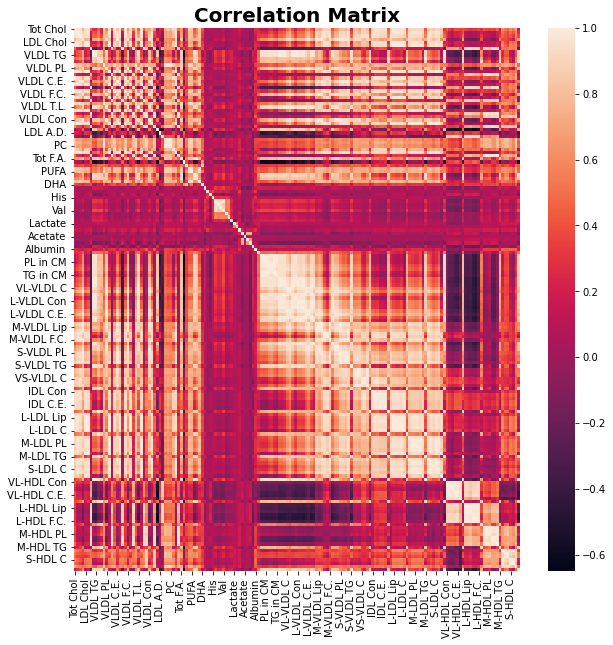

In [49]:
plt.figure(figsize = (10, 10))
corrMatrix = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid_shuffled.rename(
    columns = {'target' : 'Phenotype', '23400-0.0' : 'Tot Chol', '23404-0.0' : 'LDL Chol', '23408-0.0' : 'VLDL TG', '23412-0.0' : 'VLDL PL', 
               '23416-0.0' : 'VLDL C.E.', '23420-0.0' : 'VLDL F.C.', '23424-0.0' : 'VLDL T.L.', '23428-0.0' : 'VLDL Con', 
               '23432-0.0' : 'LDL A.D.', '23437-0.0' : 'PC', '23442-0.0' : 'Tot F.A.', '23446-0.0' : 'PUFA', 
               '23450-0.0' : 'DHA', '23463-0.0' : 'His', '23467-0.0' : 'Val', '23471-0.0' : 'Lactate', 
               '23475-0.0' : 'Acetate', '23479-0.0' : 'Albumin', '23483-0.0' : 'PL in CM', '23487-0.0' : 'TG in CM', 
               '23491-0.0' : 'VL-VLDL C', '23495-0.0' : 'L-VLDL Con', '23499-0.0' : 'L-VLDL C.E.', 
               '23503-0.0' : 'M-VLDL Lip', '23507-0.0' : 'M-VLDL F.C.', '23511-0.0' : 'S-VLDL PL', 
               '23515-0.0' : 'S-VLDL TG', '23519-0.0' : 'VS-VLDL C', '23523-0.0' : 'IDL Con', '23527-0.0' : 'IDL C.E.', 
               '23531-0.0' : 'L-LDL Lip', '23535-0.0' : 'L-LDL C', '23539-0.0' : 'M-LDL PL', '23543-0.0' : 'M-LDL TG', 
               '23547-0.0' : 'S-LDL C', '23551-0.0' : 'VL-HDL Con', '23555-0.0' : 'VL-HDL C.E.', 
               '23559-0.0' : 'L-HDL Lip', '23563-0.0' : 'L-HDL F.C.', '23567-0.0' : 'M-HDL PL', 
               '23571-0.0' : 'M-HDL TG', '23575-0.0' : 'S-HDL C'}).drop(columns = ['31-0.0', 'Age Covariate', 'Phenotype', 'Ethnicity_0', 'Ethnicity_1', 
                               'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']).corr()
sns.heatmap(corrMatrix)
plt.title('Correlation Matrix', fontweight = 'bold', fontsize = 20)
plt.show()

Below we cluster the patients based on pearson correlation with complete linkage.

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 1440x1440 with 0 Axes>

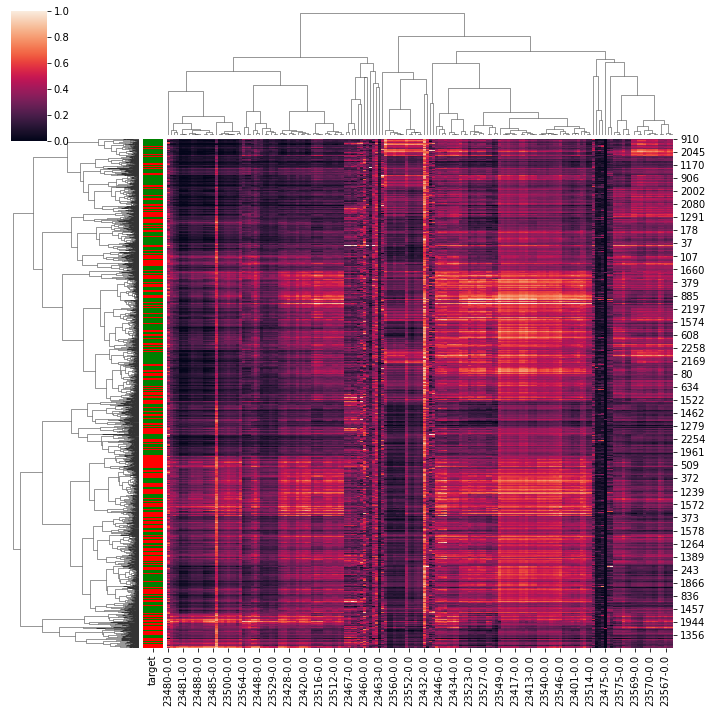

In [50]:
color_dict=dict(zip(np.unique(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid_shuffled['target']),np.array(['green','red'])))
target_df = pd.DataFrame({"target":prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid_shuffled['target']})
row_colors = target_df.target.map(color_dict)

plt.figure(figsize = (20, 20))
sns.clustermap(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid_shuffled.
               drop(columns = ['31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 
                               'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']), metric = 'correlation', method = 'complete', row_colors = row_colors)
plt.show()

Below we show these clusters again with another dendrogram and without the data.

Text(0, 0.5, 'Distance')

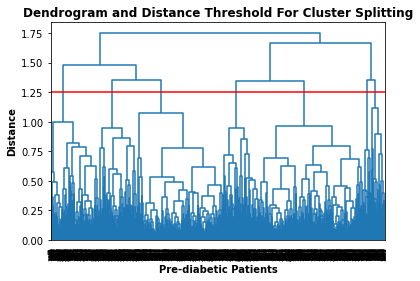

In [51]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

Y=pdist(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid_shuffled.drop(columns = ['31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 
                               'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']), 'correlation')

Z=linkage(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_no_eid_shuffled.drop(columns = ['31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 
                               'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']), 'complete', 'correlation')
dendrogram(Z, color_threshold=0)
plt.axhline(y = 1.25, color = 'red')
plt.title('Dendrogram and Distance Threshold For Cluster Splitting', fontweight = 'bold')
plt.xlabel('Pre-diabetic Patients', fontweight = 'bold')
plt.ylabel('Distance', fontweight = 'bold')


Below we use the fcluster function to create the clusters from the dendrogram at a distance threshold of 1.25, which gives us 7 clusters if we draw a straight horizontal line at y = 1.25.

In [52]:
from scipy.cluster.hierarchy import ward, fcluster
# Clusterize the data
threshold = 1.25 # Threshold is based on the distance from the dendrogram above - 1.25 gives us 7 clusters
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([5, 7, 3, ..., 7, 5, 5], dtype=int32)

Below we show the knee plot. It tries to find the clustering step where the acceleration of distance growth is the biggest (the "strongest elbow" of the blue line graph below, which is the highest value of the green graph below). This demonstrates that 7 clusters is the optimal cutoff due to its flattening of the blue line and the peak of the green line. https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

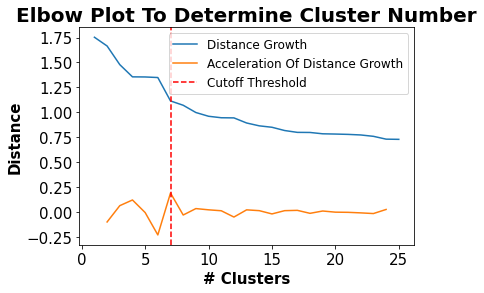

clusters: 7


In [53]:
last = Z[-25:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev, label = 'Distance Growth')

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev, label = 'Acceleration Of Distance Growth')
plt.axvline(x = 7, color = 'red', linestyle = '--', label = 'Cutoff Threshold')
plt.ylabel('Distance', fontweight = 'bold', fontsize = 15)
plt.xlabel('# Clusters', fontweight = 'bold', fontsize = 15)
plt.title('Elbow Plot To Determine Cluster Number', fontweight = 'bold', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 'large')
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


Below we add the clusters to the dataframe.

In [54]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled['labels'] = labels
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
135    0.368701   0.354952   0.317711   0.313315   0.410439   0.456313   
1089   0.178951   0.183385   0.195076   0.286471   0.185227   0.260847   
1490   0.529190   0.523941   0.545857   0.559230   0.528915   0.556045   
420    0.362598   0.340459   0.346718   0.345140   0.400694   0.405771   
2098   0.626181   0.509336   0.463818   0.313156   0.602129   0.601268   
...         ...        ...        ...        ...        ...        ...   
358    0.409575   0.430062   0.400141   0.398334   0.490266   0.517041   
1977   0.454162   0.399073   0.344602   0.296642   0.483616   0.510597   
79     0.292815   0.276207   0.258656   0.276523   0.333195   0.368991   
1904   0.299452   0.309983   0.311656   0.308671   0.366862   0.382527   
1578   0.205765   0.230645   0.194360   0.212756   0.317936   0.344508   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
135    0.268151   0.266144   0.243557   0.245425  ...       1              0   
1089   0.147217   0.412621   0.395243   0.290853  ...       1              1   
1490   0.305662   0.346235   0.312944   0.311998  ...       0              1   
420    0.288623   0.224699   0.229556   0.127227  ...       0              1   
2098   0.645094   0.132783   0.105471   0.206871  ...       0              0   
...         ...        ...        ...        ...  ...     ...            ...   
358    0.190667   0.248019   0.241892   0.191515  ...       1              1   
1977   0.412591   0.167026   0.155478   0.169499  ...       0              1   
79     0.247287   0.265757   0.259607   0.191012  ...       1              1   
1904   0.176149   0.265407   0.261677   0.192154  ...       1              1   
1578   0.101838   0.132322   0.137994   0.083949  ...       1              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
135             1            0            0            0            0   
1089            1            0            0            0            0   
1490            1            0            0            0            0   
420             1            0            0            0            0   
2098            0            1            0            0            0   
...           ...          ...          ...          ...          ...   
358             1            0            0            0            0   
1977            1            0            0            0            0   
79              1            0            0            0            0   
1904            1            0            0            0            0   
1578            1            0            0            0            0   

      Ethnicity_5  target  labels  
135             0       1       5  
1089            0       1       7  
1490            0       0       3  
420             0       1       5  
2098            0       1       3  
...           ...     ...     ...  
358             0       1       5  
1977            0       1       3  
79              0       1       7  
1904            0       1       5  
1578            0       1       5  

[2339 rows x 179 columns]

Below we save the group labels for each pre-diabetic patient.

In [55]:
#prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled[['eid', 'labels']].to_csv('prediabetic_patient_eid_and_group_labels.csv')

Below we name all metabolites.

In [56]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled_names = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled.rename(
    columns = {'23400-0.0' : 'Total Cholesterol', '23401-0.0' : 'Total Cholesterol Minus HDL-C', 
               '23402-0.0' : 'Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)', '23403-0.0' : 'VLDL Cholesterol', 
               '23404-0.0' : 'Clinical LDL Cholesterol', '23405-0.0' : 'LDL Cholesterol', '23406-0.0' : 'HDL Cholesterol', 
               '23407-0.0' : 'Total Triglycerides', '23408-0.0' : 'Triglycerides in VLDL', 
               '23409-0.0' : 'Triglycerides in LDL', '23410-0.0' : 'Triglycerides in HDL', 
               '23411-0.0' : 'Total Phospholipids in Lipoprotein Particles', '23412-0.0' : 'Phospholipids in VLDL', 
               '23413-0.0' : 'Phospholipids in LDL', '23414-0.0' : 'Phospholipids in HDL', 
               '23415-0.0' : 'Total Esterified Cholesterol', '23416-0.0' : 'Cholesteryl Esters in VLDL', 
               '23417-0.0' : 'Cholesteryl Esters in LDL', '23418-0.0' : 'Cholesteryl Esters in HDL', 
               '23419-0.0' : 'Total Free Cholesterol', '23420-0.0' : 'Free Cholesterol in VLDL', 
               '23421-0.0' : 'Free Cholesterol in LDL', '23422-0.0' : 'Free Cholesterol in HDL', 
               '23423-0.0' : 'Total Lipids in Lipoprotein Particles', '23424-0.0' : 'Total Lipids in VLDL', 
               '23425-0.0' : 'Total Lipids in LDL', '23426-0.0' : 'Total Lipids in HDL', 
               '23427-0.0' : 'Total Concentration of Lipoprotein Particles', 
               '23428-0.0' : 'Concentration of VLDL Particles', '23429-0.0' : 'Concentration of LDL Particles', 
               '23430-0.0' : 'Concentration of HDL Particles', '23431-0.0' : 'Average Diameter for VLDL Particles', 
               '23432-0.0' : 'Average Diameter for LDL Particles', '23433-0.0' : 'Average Diameter for HDL Particles', 
               '23434-0.0' : 'Phosphoglycerides', '23436-0.0' : 'Total Cholines', '23437-0.0' : 'Phosphatidylcholines', 
               '23438-0.0' : 'Sphingomyelins', '23439-0.0' : 'Apolipoprotein B', '23440-0.0' : 'Apolipoprotein A1', 
               '23442-0.0' : 'Total Fatty Acids', '23443-0.0' : 'Degree of Unsaturation', 
               '23444-0.0' : 'Omega-3 Fatty Acids', '23445-0.0' : 'Omega-6 Fatty Acids', 
               '23446-0.0' : 'Polyunsaturated Fatty Acids', '23447-0.0' : 'Monounsaturated Fatty Acids', 
               '23448-0.0' : 'Saturated Fatty Acids', '23449-0.0' : 'Linoleic Acid', 
               '23450-0.0' : 'Docosahexaenoic Acid', '23460-0.0' : 'Alanine', '23461-0.0' : 'Glutamine', 
               '23462-0.0' : 'Glycine', '23463-0.0' : 'Histidine', 
               '23464-0.0' : 'Total Concentration of Branched-Chain Amino Acids (Leucine + Isoleucine + Valine)', 
               '23465-0.0' : 'Isoleucine', '23466-0.0' : 'Leucine', '23467-0.0' : 'Valine', '23468-0.0' : 'Phenylalanine', 
               '23469-0.0' : 'Tyrosine', '23470-0.0' : 'Glucose', '23471-0.0' : 'Lactate', '23472-0.0' : 'Pyruvate', 
               '23473-0.0' : 'Citrate', '23474-0.0' : '3-Hydroxybutyrate', '23475-0.0' : 'Acetate', 
               '23476-0.0' : 'Acetoacetate', '23477-0.0' : 'Acetone', '23478-0.0' : 'Creatinine', 
               '23479-0.0' : 'Albumin', '23480-0.0' : 'Glycoprotein Acetyls', 
               '23481-0.0' : 'Concentration of Chylomicrons and Extremely Large VLDL Particles', 
               '23482-0.0' : 'Total Lipids in Chylomicrons and Extremely Large VLDL', 
               '23483-0.0' : 'Phospholipids in Chylomicrons and Extremely Large VLDL', 
               '23484-0.0' : 'Cholesterol in Chylomicrons and Extremely Large VLDL', 
               '23485-0.0' : 'Cholesteryl Esters in Chylomicrons and Extremely Large VLDL', 
               '23486-0.0' : 'Free Cholesterol in Chylomicrons and Extremely Large VLDL', 
               '23487-0.0' : 'Triglycerides in Chylomicrons and Extremely Large VLDL', '23488-0.0' : 'Concentration of Very Large VLDL Particles', '23489-0.0' : 'Total Lipids in Very Large VLDL', '23490-0.0' : 'Phospholipids in Very Large VLDL', '23491-0.0' : 'Cholesterol in Very Large VLDL', '23492-0.0' : 'Cholesteryl Esters in Very Large VLDL', '23493-0.0' : 'Free Cholesterol in Very Large VLDL', '23494-0.0' : 'Triglycerides in Very Large VLDL', '23495-0.0' : 'Concentration of Large VLDL Particles', '23496-0.0' : 'Total Lipids in Large VLDL', '23497-0.0' : 'Phospholipids in Large VLDL', '23498-0.0' : 'Cholesterol in Large VLDL', '23499-0.0' : 'Cholesteryl Esters in Large VLDL', '23500-0.0' : 'Free Cholesterol in Large VLDL', '23501-0.0' : 'Triglycerides in Large VLDL', '23502-0.0' : 'Concentration of Medium VLDL Particles', '23503-0.0' : 'Total Lipids in Medium VLDL', '23504-0.0' : 'Phospholipids in Medium VLDL', '23505-0.0' : 'Cholesterol in Medium VLDL', '23506-0.0' : 'Cholesteryl Esters in Medium VLDL', '23507-0.0' : 'Free Cholesterol in Medium VLDL', '23508-0.0' : 'Triglycerides in Medium VLDL', '23509-0.0' : 'Concentration of Small VLDL Particles', '23510-0.0' : 'Total Lipids in Small VLDL', '23511-0.0' : 'Phospholipids in Small VLDL', '23512-0.0' : 'Cholesterol in Small VLDL', '23513-0.0' : 'Cholesteryl Esters in Small VLDL', '23514-0.0' : 'Free Cholesterol in Small VLDL', '23515-0.0' : 'Triglycerides in Small VLDL', '23516-0.0' : 'Concentration of Very Small VLDL Particles', '23517-0.0' : 'Total Lipids in Very Small VLDL', '23518-0.0' : 'Phospholipids in Very Small VLDL', '23519-0.0' : 'Cholesterol in Very Small VLDL', '23520-0.0' : 'Cholesteryl Esters in Very Small VLDL', '23521-0.0' : 'Free Cholesterol in Very Small VLDL', '23522-0.0' : 'Triglycerides in Very Small VLDL', '23523-0.0' : 'Concentration of IDL Particles', '23524-0.0' : 'Total Lipids in IDL', '23525-0.0' : 'Phospholipids in IDL', '23526-0.0' : 'Cholesterol in IDL', '23527-0.0' : 'Cholesteryl Esters in IDL', '23528-0.0' : 'Free Cholesterol in IDL', '23529-0.0' : 'Triglycerides in IDL', '23530-0.0' : 'Concentration of Large LDL Particles', '23531-0.0' : 'Total Lipids in Large LDL', '23532-0.0' : 'Phospholipids in Large LDL', '23533-0.0' : 'Cholesterol in Large LDL', '23534-0.0' : 'Cholesteryl Esters in Large LDL', '23535-0.0' : 'Free Cholesterol in Large LDL', '23536-0.0' : 'Triglycerides in Large LDL', '23537-0.0' : 'Concentration of Medium LDL Particles', '23538-0.0' : 'Total Lipids in Medium LDL', '23539-0.0' : 'Phospholipids in Medium LDL', '23540-0.0' : 'Cholesterol in Medium LDL', '23541-0.0' : 'Cholesteryl Esters in Medium LDL', '23542-0.0' : 'Free Cholesterol in Medium LDL', '23543-0.0' : 'Triglycerides in Medium LDL', '23544-0.0' : 'Concentration of Small LDL Particles', '23545-0.0' : 'Total Lipids in Small LDL', '23546-0.0' : 'Phospholipids in Small LDL', '23547-0.0' : 'Cholesterol in Small LDL', '23548-0.0' : 'Cholesteryl Esters in Small LDL', '23549-0.0' : 'Free Cholesterol in Small LDL', '23550-0.0' : 'Triglycerides in Small LDL', '23551-0.0' : 'Concentration of Very Large HDL Particles', '23552-0.0' : 'Total Lipids in Very Large HDL', '23553-0.0' : 'Phospholipids in Very Large HDL', '23554-0.0' : 'Cholesterol in Very Large HDL', '23555-0.0' : 'Cholesteryl Esters in Very Large HDL', '23556-0.0' : 'Free Cholesterol in Very Large HDL', '23557-0.0' : 'Triglycerides in Very Large HDL', '23558-0.0' : 'Concentration of Large HDL Particles', '23559-0.0' : 'Total Lipids in Large HDL', '23560-0.0' : 'Phospholipids in Large HDL', '23561-0.0' : 'Cholesterol in Large HDL', '23562-0.0' : 'Cholesteryl Esters in Large HDL', '23563-0.0' : 'Free Cholesterol in Large HDL', '23564-0.0' : 'Triglycerides in Large HDL', '23565-0.0' : 'Concentration of Medium HDL Particles', '23566-0.0' : 'Total Lipids in Medium HDL', '23567-0.0' : 'Phospholipids in Medium HDL', '23568-0.0' : 'Cholesterol in Medium HDL', '23569-0.0' : 'Cholesteryl Esters in Medium HDL', '23570-0.0' : 'Free Cholesterol in Medium HDL', '23571-0.0' : 'Triglycerides in Medium HDL', '23572-0.0' : 'Concentration of Small HDL Particles', '23573-0.0' : 'Total Lipids in Small HDL', '23574-0.0' : 'Phospholipids in Small HDL', '23575-0.0' : 'Cholesterol in Small HDL', '23576-0.0' :  'Cholesteryl Esters in Small HDL', '23577-0.0' : 'Free Cholesterol in Small HDL', '23578-0.0' : 'Triglycerides in Small HDL'})
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled_names['labels'] = labels
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled_names

Total Cholesterol  Total Cholesterol Minus HDL-C  \
135            0.368701                       0.354952   
1089           0.178951                       0.183385   
1490           0.529190                       0.523941   
420            0.362598                       0.340459   
2098           0.626181                       0.509336   
...                 ...                            ...   
358            0.409575                       0.430062   
1977           0.454162                       0.399073   
79             0.292815                       0.276207   
1904           0.299452                       0.309983   
1578           0.205765                       0.230645   

      Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)  VLDL Cholesterol  \
135                                            0.317711            0.313315   
1089                                           0.195076            0.286471   
1490                                           0.545857            0.559230   
420                                            0.346718            0.345140   
2098                                           0.463818            0.313156   
...                                                 ...                 ...   
358                                            0.400141            0.398334   
1977                                           0.344602            0.296642   
79                                             0.258656            0.276523   
1904                                           0.311656            0.308671   
1578                                           0.194360            0.212756   

      Clinical LDL Cholesterol  LDL Cholesterol  HDL Cholesterol  \
135                   0.410439         0.456313         0.268151   
1089                  0.185227         0.260847         0.147217   
1490                  0.528915         0.556045         0.305662   
420                   0.400694         0.405771         0.288623   
2098                  0.602129         0.601268         0.645094   
...                        ...              ...              ...   
358                   0.490266         0.517041         0.190667   
1977                  0.483616         0.510597         0.412591   
79                    0.333195         0.368991         0.247287   
1904                  0.366862         0.382527         0.176149   
1578                  0.317936         0.344508         0.101838   

      Total Triglycerides  Triglycerides in VLDL  Triglycerides in LDL  ...  \
135              0.266144               0.243557              0.245425  ...   
1089             0.412621               0.395243              0.290853  ...   
1490             0.346235               0.312944              0.311998  ...   
420              0.224699               0.229556              0.127227  ...   
2098             0.132783               0.105471              0.206871  ...   
...                   ...                    ...                   ...  ...   
358              0.248019               0.241892              0.191515  ...   
1977             0.167026               0.155478              0.169499  ...   
79               0.265757               0.259607              0.191012  ...   
1904             0.265407               0.261677              0.192154  ...   
1578             0.132322               0.137994              0.083949  ...   

      31-0.0  Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  \
135        1              0            1            0            0   
1089       1              1            1            0            0   
1490       0              1            1            0            0   
420        0              1            1            0            0   
2098       0              0            0            1            0   
...      ...            ...          ...          ...          ...   
358        1              1            1            0            0   
1977       0              1       

<a class="anchor" id="Supervised_learning"></a>
# Supervised ML Classification of patients into 7 groups

Below we keep only the metabolomic data and the group labels for the classification of patients into one of the seven groups.

In [57]:
only_metabolomic_values = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled_names.iloc[:,0:168]
only_metabolomic_values['labels'] = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled_names['labels']
only_metabolomic_values

Total Cholesterol  Total Cholesterol Minus HDL-C  \
135            0.368701                       0.354952   
1089           0.178951                       0.183385   
1490           0.529190                       0.523941   
420            0.362598                       0.340459   
2098           0.626181                       0.509336   
...                 ...                            ...   
358            0.409575                       0.430062   
1977           0.454162                       0.399073   
79             0.292815                       0.276207   
1904           0.299452                       0.309983   
1578           0.205765                       0.230645   

      Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)  VLDL Cholesterol  \
135                                            0.317711            0.313315   
1089                                           0.195076            0.286471   
1490                                           0.545857            0.559230   
420                                            0.346718            0.345140   
2098                                           0.463818            0.313156   
...                                                 ...                 ...   
358                                            0.400141            0.398334   
1977                                           0.344602            0.296642   
79                                             0.258656            0.276523   
1904                                           0.311656            0.308671   
1578                                           0.194360            0.212756   

      Clinical LDL Cholesterol  LDL Cholesterol  HDL Cholesterol  \
135                   0.410439         0.456313         0.268151   
1089                  0.185227         0.260847         0.147217   
1490                  0.528915         0.556045         0.305662   
420                   0.400694         0.405771         0.288623   
2098                  0.602129         0.601268         0.645094   
...                        ...              ...              ...   
358                   0.490266         0.517041         0.190667   
1977                  0.483616         0.510597         0.412591   
79                    0.333195         0.368991         0.247287   
1904                  0.366862         0.382527         0.176149   
1578                  0.317936         0.344508         0.101838   

      Total Triglycerides  Triglycerides in VLDL  Triglycerides in LDL  ...  \
135              0.266144               0.243557              0.245425  ...   
1089             0.412621               0.395243              0.290853  ...   
1490             0.346235               0.312944              0.311998  ...   
420              0.224699               0.229556              0.127227  ...   
2098             0.132783               0.105471              0.206871  ...   
...                   ...                    ...                   ...  ...   
358              0.248019               0.241892              0.191515  ...   
1977             0.167026               0.155478              0.169499  ...   
79               0.265757               0.259607              0.191012  ...   
1904             0.265407               0.261677              0.192154  ...   
1578             0.132322               0.137994              0.083949  ...   

      Free Cholesterol in Medium HDL  Triglycerides in Medium HDL  \
135                         0.332673                     0.354162   
1089                        0.254906                     0.445570   
1490                        0.345954                     0.420462   
420                         0.305976                     0.237790   
2098                        0.634086                     0.249386   
...                              ...                          ...   
358                         0.225865                     0.241582   
1977                        0.416788      

Next we want to perform feature selection using python's tools FOR OUR NAMED METABOLITES FOR LOGISTIC REGRESSION. Below we make dataframes separating our features and our targets.

In [58]:
prediabetes_features_only = only_metabolomic_values.iloc[:, :-1]
prediabetes_targets_only = only_metabolomic_values.iloc[:, -1]

# Machine Learning Start

### Next we create a variable for the category column we will use later.

In [59]:
labels = prediabetes_targets_only
labels

135     5
1089    7
1490    3
420     5
2098    3
       ..
358     5
1977    3
79      7
1904    5
1578    5
Name: labels, Length: 2339, dtype: int32

In [60]:
labels = labels.to_numpy()
labels

array([5, 7, 3, ..., 7, 5, 5])

### Below we create a list of the column names which we will use later to see the influence of each annotation:

In [61]:
feature_list = list(prediabetes_features_only.columns)
len(feature_list)

168

### Now that all our data is numeric, we want to transform it into a numpy array to use in our model:

In [62]:
final_dataframe_final = prediabetes_features_only.to_numpy()

### Now we will split our data into testing and training data to later use for our model. We do a 80% training data to 20% testing data split:

In [63]:
train_features, test_features, train_labels, test_labels = train_test_split(final_dataframe_final, labels, test_size = 0.2, random_state = 100)

# First we use Logistic Regression 

Since we have multiple labels, we have to perform multi-class classifcation, instead of the usual binary. We use this reference for logistic regression https://machinelearningmastery.com/multinomial-logistic-regression-with-python/ and this reference to do so for many other classifiers: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV

In [64]:
# evaluate multinomial logistic regression model
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 500)
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores_logreg = cross_val_score(model, final_dataframe_final, labels, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores_logreg), std(n_scores_logreg)))


Mean Accuracy: 0.795 (0.030)


In [65]:
from sklearn.linear_model import LogisticRegression

# define the multinomial logistic regression model
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 500).fit(train_features, train_labels)
# define the model evaluation procedure
logreg_predictions = logreg_model.predict(test_features)

# model accuracy for X_test 
logreg_accuracy = logreg_model.score(test_features, test_labels)
print(logreg_accuracy)
 
# creating a confusion matrix
logreg_cm = confusion_matrix(test_labels, logreg_predictions)
logreg_cm

0.7606837606837606


array([[ 42,   3,   6,   1,   0,   0,   0],
       [  7,  33,   9,   4,   2,   0,   0],
       [  4,   0,  96,   2,  23,   0,   0],
       [  2,   0,   0,  39,  15,   0,   1],
       [  0,   5,  11,   3, 120,   0,   0],
       [  0,   0,   0,   0,   3,  12,   4],
       [  0,   2,   0,   1,   3,   1,  14]], dtype=int64)

# Next we use the Multi-layer Perceptron model

In [66]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=1, max_iter=500).fit(train_features, train_labels)

# define the model evaluation procedure
mlp_predictions = mlp.predict(test_features)

# model accuracy for X_test 
mlp_accuracy = mlp.score(test_features, test_labels)
print(mlp_accuracy)
 
# creating a confusion matrix
mlp_cm = confusion_matrix(test_labels, mlp_predictions)
mlp_cm

0.7948717948717948


array([[ 43,   3,   6,   0,   0,   0,   0],
       [  9,  33,  11,   2,   0,   0,   0],
       [  3,   1, 107,   3,  11,   0,   0],
       [  3,   1,   0,  44,   9,   0,   0],
       [  0,   5,  18,   4, 112,   0,   0],
       [  0,   0,   0,   0,   0,  17,   2],
       [  0,   1,   0,   2,   2,   0,  16]], dtype=int64)

In [67]:
# define the MLP model
mlp = MLPClassifier(random_state=1, max_iter=500)
# define the model evaluation procedure
cv_mlp = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores_mlp = cross_val_score(mlp, final_dataframe_final, labels, scoring='accuracy', cv=cv_mlp, n_jobs=-1)
# report the model performance
print('Mean Accuracy for MLP model: %.3f (%.3f)' % (mean(n_scores_mlp), std(n_scores_mlp)))
print(n_scores_mlp)

Mean Accuracy for MLP model: 0.820 (0.029)
[0.88034188 0.82478632 0.84188034 0.82051282 0.77777778 0.82051282
 0.81623932 0.82478632 0.82051282 0.76824034 0.76495726 0.76068376
 0.81196581 0.86752137 0.84188034 0.82905983 0.85470085 0.81196581
 0.83760684 0.82403433 0.77777778 0.79487179 0.85042735 0.83760684
 0.85042735 0.84615385 0.82478632 0.7991453  0.8034188  0.8111588 ]


# Next we create the KNN model.

In [68]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors = i).fit(train_features, train_labels)
 
    # accuracy on X_test
    accuracy = knn.score(test_features, test_labels)
    print(accuracy)
# 7 gives the best accuracy

0.7799145299145299
0.7329059829059829
0.7628205128205128
0.7713675213675214
0.782051282051282
0.7756410256410257
0.7927350427350427
0.7905982905982906
0.7841880341880342
0.7905982905982906
0.7606837606837606
0.7735042735042735
0.7799145299145299
0.7905982905982906
0.7841880341880342
0.7799145299145299
0.7799145299145299
0.7649572649572649
0.7756410256410257
0.7756410256410257
0.7649572649572649
0.7692307692307693
0.7564102564102564
0.7649572649572649
0.7585470085470085
0.7606837606837606
0.7628205128205128
0.7585470085470085
0.7564102564102564
0.7521367521367521


In [69]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(train_features, train_labels)
 
# accuracy on X_test
accuracy = knn.score(test_features, test_labels)
print(accuracy)
 
# creating a confusion matrix
knn_predictions = knn.predict(test_features)
cm = confusion_matrix(test_labels, knn_predictions)
cm

0.7927350427350427


array([[ 44,   1,   6,   1,   0,   0,   0],
       [  4,  36,  10,   3,   2,   0,   0],
       [  2,   2, 104,   1,  16,   0,   0],
       [  7,   0,   1,  39,  10,   0,   0],
       [  0,   2,  10,   3, 124,   0,   0],
       [  0,   1,   1,   0,   5,  11,   1],
       [  0,   3,   0,   1,   3,   1,  13]], dtype=int64)

In [70]:
knn = KNeighborsClassifier(n_neighbors = 7)
# define the model evaluation procedure
cv_knn = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores_knn = cross_val_score(knn, final_dataframe_final, labels, scoring='accuracy', cv=cv_knn, n_jobs=-1)
# report the model performance
print('Mean Accuracy for KNN model: %.3f (%.3f)' % (mean(n_scores_knn), std(n_scores_knn)))
print(n_scores_knn)

Mean Accuracy for KNN model: 0.819 (0.021)
[0.84615385 0.82051282 0.8034188  0.82905983 0.79059829 0.7991453
 0.81623932 0.82478632 0.82051282 0.81974249 0.7991453  0.74786325
 0.83333333 0.82478632 0.82051282 0.80769231 0.85470085 0.82905983
 0.82478632 0.85407725 0.81196581 0.81623932 0.84615385 0.7991453
 0.82905983 0.83333333 0.8034188  0.83760684 0.81196581 0.82403433]


In [71]:
stats.ttest_rel(n_scores_mlp,n_scores_knn)


Ttest_relResult(statistic=0.12296188163070938, pvalue=0.9029855091930291)

# Next we use a XGBoost model.

In [72]:
import xgboost as xgb
from xgboost import XGBClassifier

xgboost = xgb.XGBClassifier()

xgboost.fit(train_features, train_labels)

# define the model evaluation procedure
xgboost_predictions = xgboost.predict(test_features)

# model accuracy for X_test 
xgboost_accuracy = xgboost.score(test_features, test_labels)
print(xgboost_accuracy)
 
# creating a confusion matrix
xgboost_cm = confusion_matrix(test_labels, xgboost_predictions)
xgboost_cm

0.8012820512820513


array([[ 45,   3,   2,   2,   0,   0,   0],
       [  7,  34,   9,   3,   2,   0,   0],
       [  3,   0,  99,   2,  21,   0,   0],
       [  4,   2,   0,  41,  10,   0,   0],
       [  0,   2,   6,   3, 128,   0,   0],
       [  0,   1,   0,   0,   1,  12,   5],
       [  0,   1,   0,   2,   1,   1,  16]], dtype=int64)

In [73]:
xgboost = xgb.XGBClassifier()
# define the model evaluation procedure
cv_xgboost = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores_xgboost = cross_val_score(xgboost, final_dataframe_final, labels, scoring='accuracy', cv=cv_xgboost, n_jobs=-1)
# report the model performance
print('Mean Accuracy for XGBoost model: %.3f (%.3f)' % (mean(n_scores_xgboost), std(n_scores_xgboost)))

Mean Accuracy for XGBoost model: 0.819 (0.024)


In [74]:
train_features_shap, test_features_shap, train_labels_shap, test_labels_shap = train_test_split(prediabetes_features_only, labels, test_size = 0.2, random_state = 100)

Below we plot the top feature importances from all the groups at once. This is a nice visualization for the paper.

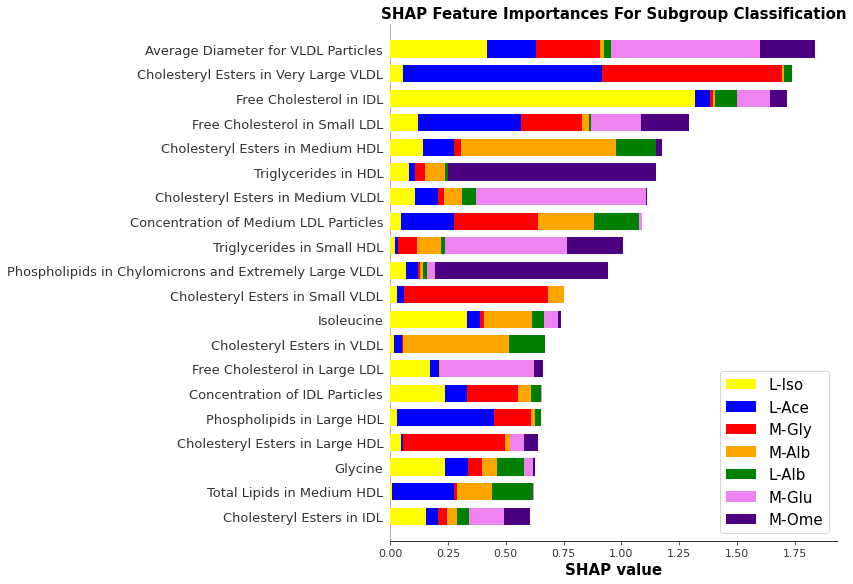

In [75]:
import matplotlib.colors as plt_colors

shap_xgboost = xgb.XGBClassifier()
shap_xgboost.fit(train_features_shap, train_labels_shap)
explainer2_xgb = shap.TreeExplainer(shap_xgboost)
shap_values_xgb = explainer2_xgb.shap_values(test_features_shap)

newcmp_in_class_output_order = plt_colors.ListedColormap(['yellow', 'blue', 'red', 'orange', 'green', 'violet', 'indigo'], name='Rainbow')

shap.summary_plot(shap_values_xgb, test_features_shap, plot_type="bar", color = newcmp_in_class_output_order, class_names = ['M-Gly', 'M-Alb', 'L-Iso', 'L-Alb', 'L-Ace', 'M-Ome', 'M-Glu'], show = False)
plt.xlabel('SHAP value', fontsize = 15, fontweight = 'bold')
plt.legend(prop={'size': 15})
plt.title('SHAP Feature Importances For Subgroup Classification', fontsize = 15, fontweight = 'bold')
plt.show()

Below we rename the columns that are most important to the model in order to make the y-axis labels smaller.

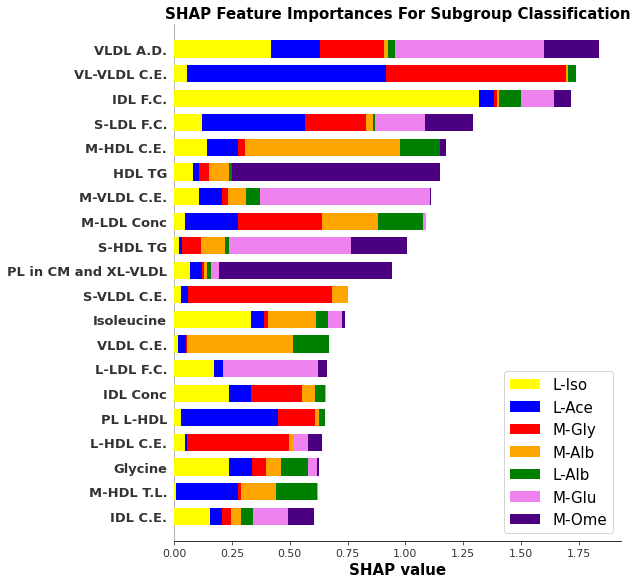

In [76]:
test_features_shap_renamed_xgb = test_features_shap.drop_duplicates()
test_features_shap_renamed_xgb = test_features_shap.rename(columns = {'Cholesterol in Medium HDL' : 'M-HDL C',
                                                                  'Average Diameter for VLDL Particles' : 'VLDL A.D.',
                                                          'Cholesteryl Esters in Very Large VLDL' : 'VL-VLDL C.E.', 
                                                                  'Free Cholesterol in IDL' : 'IDL F.C.',
                                                                  'Free Cholesterol in Small LDL' : 'S-LDL F.C.',
                                                          'Cholesteryl Esters in Medium HDL' : 'M-HDL C.E.', 
                                                                  'Triglycerides in HDL' : 'HDL TG',
                                                                  'Cholesteryl Esters in Medium VLDL' : 'M-VLDL C.E.',
                                                                  'Concentration of Medium LDL Particles' : 'M-LDL Conc',
                                                                  'Triglycerides in Small HDL' : 'S-HDL TG',
                                                                  'Phospholipids in Chylomicrons and Extremely Large VLDL' : 'PL in CM and XL-VLDL',
                                                                  'Cholesteryl Esters in Small VLDL' : 'S-VLDL C.E.',
                                                                  'Cholesteryl Esters in VLDL' : 'VLDL C.E.',
                                                                  'Free Cholesterol in Large LDL' : 'L-LDL F.C.',
                                                                  'Concentration of IDL Particles' : 'IDL Conc',
                                                                  'Phospholipids in Large HDL' : 'PL L-HDL',
                                                                  'Cholesteryl Esters in Large HDL' : 'L-HDL C.E.',
                                                                  'Total Lipids in Medium HDL' : 'M-HDL T.L.',
                                                                  'Cholesteryl Esters in IDL' : 'IDL C.E.'})

shap_xgboost = xgb.XGBClassifier()
shap_xgboost.fit(train_features_shap, train_labels_shap)
explainer2_xgb = shap.TreeExplainer(shap_xgboost)
shap_values_xgb = explainer2_xgb.shap_values(test_features_shap_renamed_xgb)

newcmp_in_class_output_order = plt_colors.ListedColormap(['yellow', 'blue', 'red', 'orange', 'green', 'violet', 'indigo'], name='Rainbow')

shap.summary_plot(shap_values_xgb, test_features_shap_renamed_xgb, plot_type="bar", color = newcmp_in_class_output_order, class_names = ['M-Gly', 'M-Alb', 'L-Iso', 'L-Alb', 'L-Ace', 'M-Ome', 'M-Glu'], show = False)
plt.xlabel('SHAP value')
plt.legend(prop={'size': 20})
plt.xlabel('SHAP value', fontsize = 15, fontweight = 'bold')
plt.legend(prop={'size': 15})
plt.yticks(fontweight = 'bold')
plt.title('SHAP Feature Importances For Subgroup Classification', fontsize = 15, fontweight = 'bold')
plt.show()

Below we save this figure without a title.

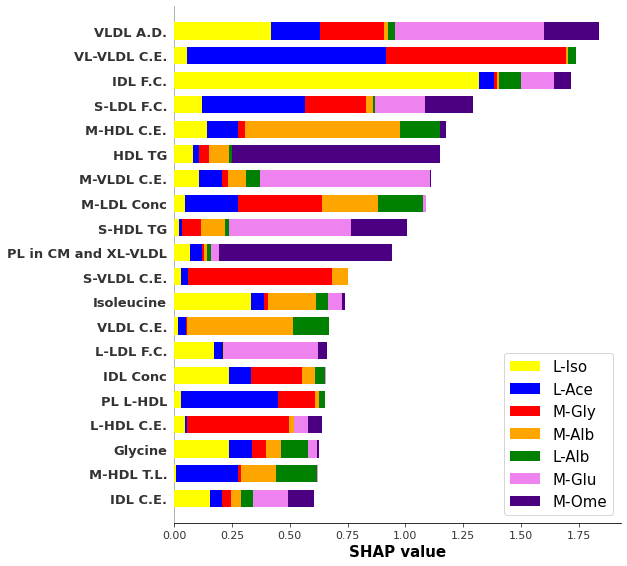

In [77]:
test_features_shap_renamed_xgb = test_features_shap.drop_duplicates()
test_features_shap_renamed_xgb = test_features_shap.rename(columns = {'Cholesterol in Medium HDL' : 'M-HDL C',
                                                                  'Average Diameter for VLDL Particles' : 'VLDL A.D.',
                                                          'Cholesteryl Esters in Very Large VLDL' : 'VL-VLDL C.E.', 
                                                                  'Free Cholesterol in IDL' : 'IDL F.C.',
                                                                  'Free Cholesterol in Small LDL' : 'S-LDL F.C.',
                                                          'Cholesteryl Esters in Medium HDL' : 'M-HDL C.E.', 
                                                                  'Triglycerides in HDL' : 'HDL TG',
                                                                  'Cholesteryl Esters in Medium VLDL' : 'M-VLDL C.E.',
                                                                  'Concentration of Medium LDL Particles' : 'M-LDL Conc',
                                                                  'Triglycerides in Small HDL' : 'S-HDL TG',
                                                                  'Phospholipids in Chylomicrons and Extremely Large VLDL' : 'PL in CM and XL-VLDL',
                                                                  'Cholesteryl Esters in Small VLDL' : 'S-VLDL C.E.',
                                                                  'Cholesteryl Esters in VLDL' : 'VLDL C.E.',
                                                                  'Free Cholesterol in Large LDL' : 'L-LDL F.C.',
                                                                  'Concentration of IDL Particles' : 'IDL Conc',
                                                                  'Phospholipids in Large HDL' : 'PL L-HDL',
                                                                  'Cholesteryl Esters in Large HDL' : 'L-HDL C.E.',
                                                                  'Total Lipids in Medium HDL' : 'M-HDL T.L.',
                                                                  'Cholesteryl Esters in IDL' : 'IDL C.E.'})

shap_xgboost = xgb.XGBClassifier()
shap_xgboost.fit(train_features_shap, train_labels_shap)
explainer2_xgb = shap.TreeExplainer(shap_xgboost)
shap_values_xgb = explainer2_xgb.shap_values(test_features_shap_renamed_xgb)

newcmp_in_class_output_order = plt_colors.ListedColormap(['yellow', 'blue', 'red', 'orange', 'green', 'violet', 'indigo'], name='Rainbow')

shap.summary_plot(shap_values_xgb, test_features_shap_renamed_xgb, plot_type="bar", color = newcmp_in_class_output_order, class_names = ['M-Gly', 'M-Alb', 'L-Iso', 'L-Alb', 'L-Ace', 'M-Ome', 'M-Glu'], show = False)
plt.xlabel('SHAP value')
plt.legend(prop={'size': 20})
plt.xlabel('SHAP value', fontsize = 15, fontweight = 'bold')
plt.legend(prop={'size': 15})
plt.yticks(fontweight = 'bold')
#plt.title('SHAP Feature Importances For Subgroup Classification', fontsize = 15, fontweight = 'bold')
plt.show()

Below are the feature importances in order from group 1 to group 7.

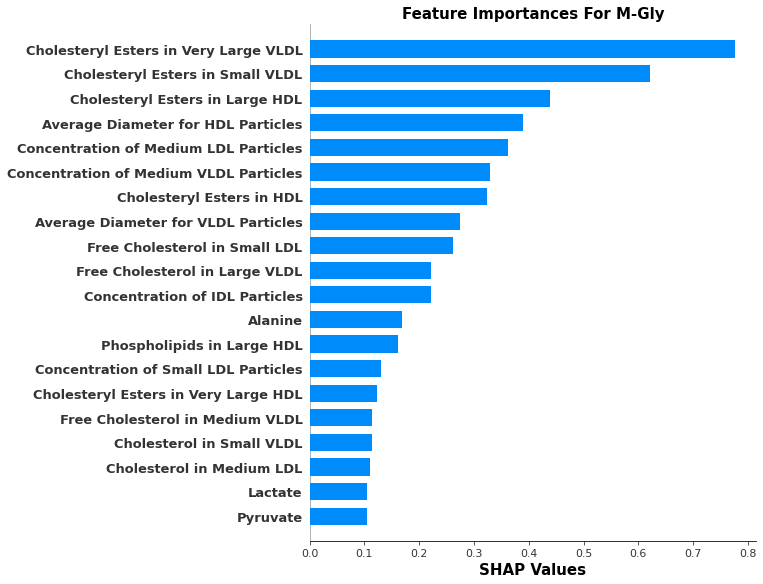

In [78]:
plt.figure(figsize=(20,20))

shap.summary_plot(shap_values_xgb[0], test_features_shap, plot_type="bar", show=False)
plt.title('Feature Importances For M-Gly', fontweight = 'bold', fontsize = 15)
plt.xlabel('SHAP Values', fontweight = 'bold', fontsize = 15)
plt.yticks(fontweight = 'bold')
plt.show()

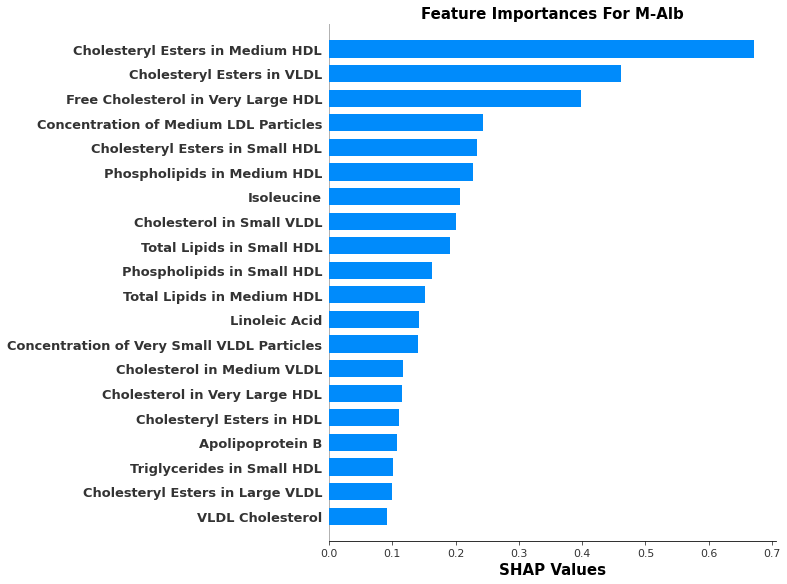

In [79]:
plt.figure(figsize=(20,20))

shap.summary_plot(shap_values_xgb[1], test_features_shap, plot_type="bar", show=False)
plt.title('Feature Importances For M-Alb', fontweight = 'bold', fontsize = 15)
plt.xlabel('SHAP Values', fontweight = 'bold', fontsize = 15)
plt.yticks(fontweight = 'bold')
plt.show()

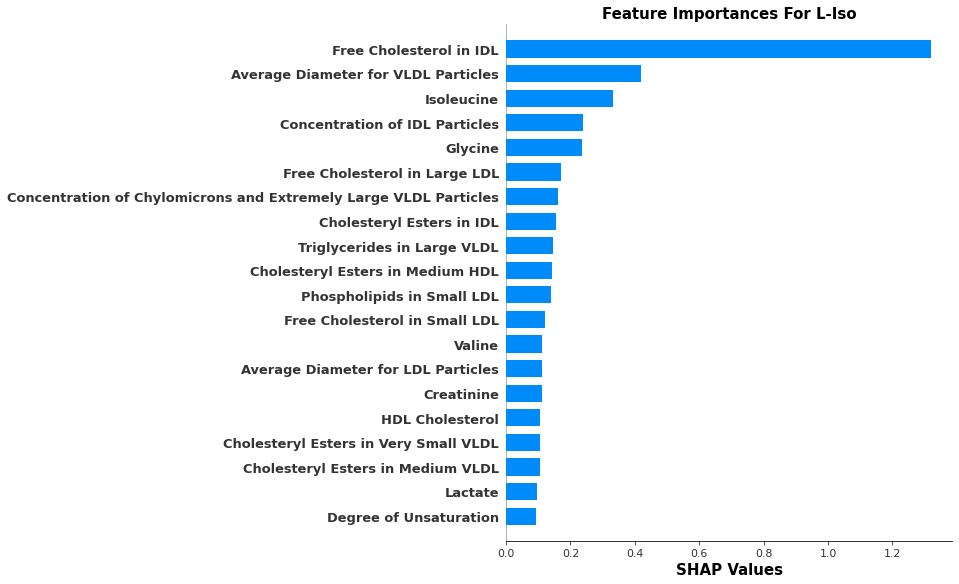

In [80]:
plt.figure(figsize=(20,20))

shap.summary_plot(shap_values_xgb[2], test_features_shap, plot_type="bar", show=False)
plt.title('Feature Importances For L-Iso', fontweight = 'bold', fontsize = 15)
plt.xlabel('SHAP Values', fontweight = 'bold', fontsize = 15)
plt.yticks(fontweight = 'bold')
plt.show()

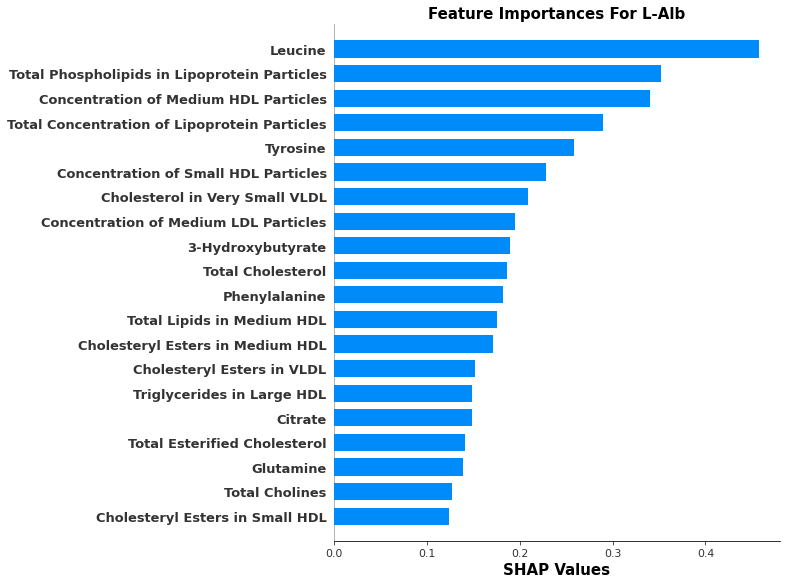

In [81]:
plt.figure(figsize=(20,20))

shap.summary_plot(shap_values_xgb[3], test_features_shap, plot_type="bar", show=False)
plt.title('Feature Importances For L-Alb', fontweight = 'bold', fontsize = 15)
plt.xlabel('SHAP Values', fontweight = 'bold', fontsize = 15)
plt.yticks(fontweight = 'bold')
plt.show()

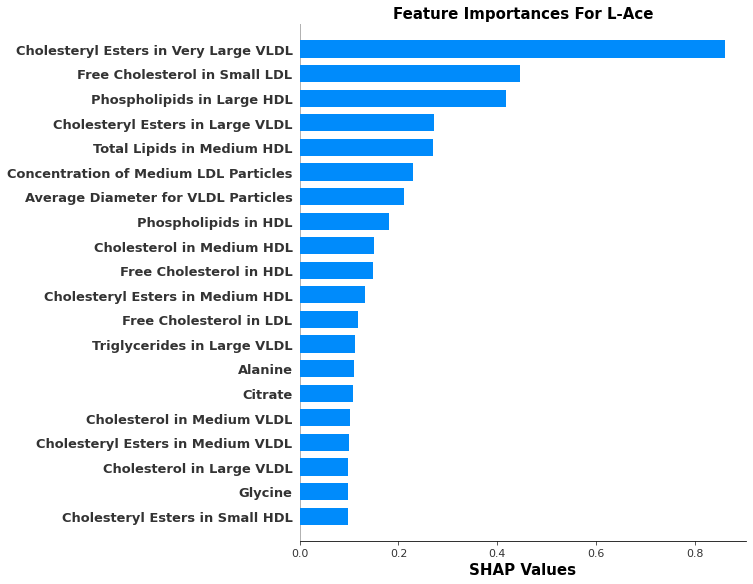

In [82]:
plt.figure(figsize=(20,20))

shap.summary_plot(shap_values_xgb[4], test_features_shap, plot_type="bar", show=False)
plt.title('Feature Importances For L-Ace', fontweight = 'bold', fontsize = 15)
plt.xlabel('SHAP Values', fontweight = 'bold', fontsize = 15)
plt.yticks(fontweight = 'bold')
plt.show()

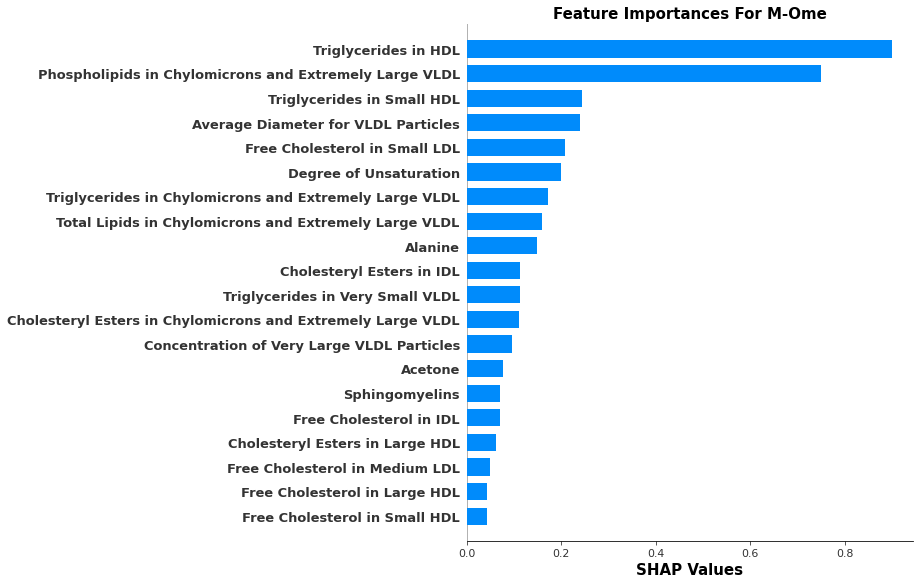

In [83]:
plt.figure(figsize=(20,20))

shap.summary_plot(shap_values_xgb[5], test_features_shap, plot_type="bar", show=False)
plt.title('Feature Importances For M-Ome', fontweight = 'bold', fontsize = 15)
plt.xlabel('SHAP Values', fontweight = 'bold', fontsize = 15)
plt.yticks(fontweight = 'bold')
plt.show()

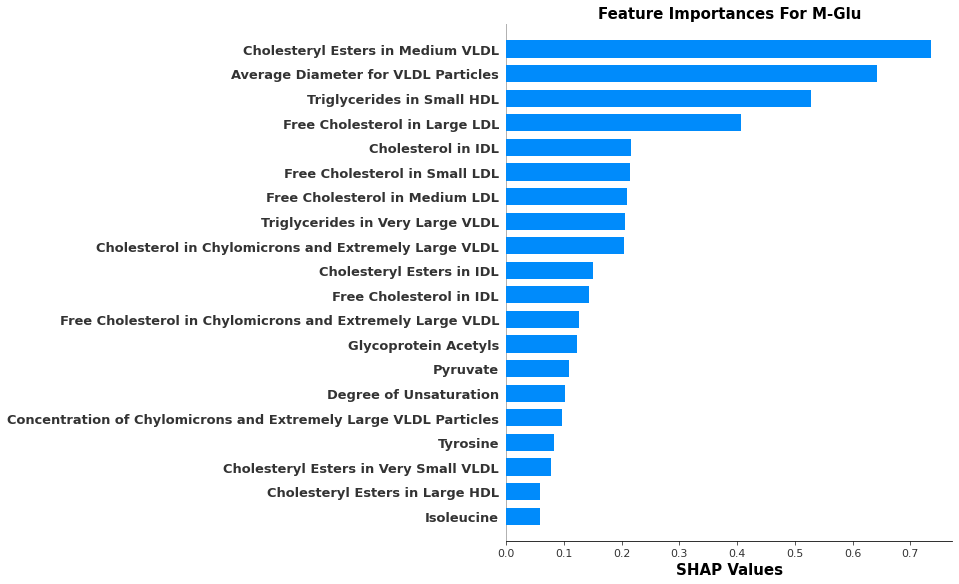

In [84]:
plt.figure(figsize=(20,20))

shap.summary_plot(shap_values_xgb[6], test_features_shap, plot_type="bar", show=False)
plt.title('Feature Importances For M-Glu', fontweight = 'bold', fontsize = 15)
plt.xlabel('SHAP Values', fontweight = 'bold', fontsize = 15)
plt.yticks(fontweight = 'bold')
plt.show()

# Next we use a Random Forest model.

In [85]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight = 'balanced', random_state=100)
clf.fit(train_features, train_labels)

# define the model evaluation procedure
rforest_predictions = clf.predict(test_features)

# model accuracy for X_test 
rforest_accuracy = clf.score(test_features, test_labels)
print(rforest_accuracy)
 
# creating a confusion matrix
rforest_cm = confusion_matrix(test_labels, rforest_predictions)
rforest_cm

0.7628205128205128


array([[ 42,   3,   5,   2,   0,   0,   0],
       [  8,  31,   8,   2,   6,   0,   0],
       [  3,   1, 101,   3,  17,   0,   0],
       [  4,   0,   0,  35,  18,   0,   0],
       [  0,   3,  10,   3, 123,   0,   0],
       [  0,   1,   0,   0,   3,  10,   5],
       [  0,   1,   0,   2,   2,   1,  15]], dtype=int64)

In [86]:
rf_clf = RandomForestClassifier(class_weight = 'balanced', random_state=100)
# define the model evaluation procedure
cv_rf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores_rf = cross_val_score(rf_clf, final_dataframe_final, labels, scoring='accuracy', cv=cv_rf, n_jobs=-1)
# report the model performance
print('Mean Accuracy for Random Forest model: %.3f (%.3f)' % (mean(n_scores_rf), std(n_scores_rf)))

Mean Accuracy for Random Forest model: 0.806 (0.028)


# Next we create the Linear SVM model.

In [87]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(train_features, train_labels)
svm_predictions = svm_model_linear.predict(test_features)
 
# model accuracy for X_test 
accuracy = svm_model_linear.score(test_features, test_labels)
print(accuracy)

# creating a confusion matrix
cm = confusion_matrix(test_labels, svm_predictions)
cm

0.7799145299145299


array([[ 43,   3,   6,   0,   0,   0,   0],
       [ 10,  33,  10,   1,   1,   0,   0],
       [  3,   0, 101,   2,  19,   0,   0],
       [  3,   0,   0,  41,  13,   0,   0],
       [  0,   4,  11,   4, 120,   0,   0],
       [  0,   1,   0,   0,   3,  13,   2],
       [  0,   2,   0,   1,   3,   1,  14]], dtype=int64)

In [88]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(train_features, train_labels)
# define the model evaluation procedure
cv_svm = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores_svm = cross_val_score(svm_model_linear, final_dataframe_final, labels, scoring='accuracy', cv=cv_svm, n_jobs=-1)
# report the model performance
print('Mean Accuracy for Linear SVM model: %.3f (%.3f)' % (mean(n_scores_svm), std(n_scores_svm)))

Mean Accuracy for Linear SVM model: 0.806 (0.029)


# Below we perform paired t-testing since the data is not independent since all algorithms use the same data. We multiply each test p-value by 15 to incorporate Bonferroni correction.

In [89]:
stat, p = stats.ttest_rel(n_scores_mlp,n_scores_logreg)
print('MLP vs logreg Bonferroni correction p-adjusted:', p*15)
print('SIGNIFICANT!!!')

MLP vs logreg Bonferroni correction p-adjusted: 7.489620906895848e-07
SIGNIFICANT!!!


In [90]:
stat, p = stats.ttest_rel(n_scores_knn,n_scores_logreg)
print('KNN vs logreg Bonferroni correction p-adjusted:', p*15)
print('SIGNIFICANT!!!')

KNN vs logreg Bonferroni correction p-adjusted: 8.90519605722002e-05
SIGNIFICANT!!!


In [91]:
stat, p = stats.ttest_rel(n_scores_xgboost,n_scores_logreg)
print('XGB vs logreg Bonferroni correction p-adjusted:', p*15)
print('SIGNIFICANT!!!')

XGB vs logreg Bonferroni correction p-adjusted: 0.0014240765385509645
SIGNIFICANT!!!


In [92]:
stat, p = stats.ttest_rel(n_scores_svm,n_scores_logreg)
print('SVM vs logreg Bonferroni correction p-adjusted:', p*15)
print('SIGNIFICANT!!!')

SVM vs logreg Bonferroni correction p-adjusted: 0.00505866563799221
SIGNIFICANT!!!


In [93]:
stat, p = stats.ttest_rel(n_scores_rf,n_scores_logreg)
print('RF vs logreg Bonferroni correction p-adjusted:', p*15)

RF vs logreg Bonferroni correction p-adjusted: 0.6193097604633546


In [94]:
stat, p = stats.ttest_rel(n_scores_knn,n_scores_mlp)
print('KNN vs MLP Bonferroni correction p-adjusted:', p*15)

KNN vs MLP Bonferroni correction p-adjusted: 13.544782637895437


In [95]:
stat, p = stats.ttest_rel(n_scores_knn,n_scores_rf)
print('KNN vs RF Bonferroni correction p-adjusted:', p*15)

KNN vs RF Bonferroni correction p-adjusted: 0.11270422939980132


In [96]:
stat, p = stats.ttest_rel(n_scores_knn,n_scores_xgboost)
print('KNN vs XGB Bonferroni correction p-adjusted:', p*15)

KNN vs XGB Bonferroni correction p-adjusted: 12.386249328378131


In [97]:
stat, p = stats.ttest_rel(n_scores_knn,n_scores_svm)
print('KNN vs SVM Bonferroni correction p-adjusted:', p*15)

KNN vs SVM Bonferroni correction p-adjusted: 0.1472078515578263


In [98]:
stat, p = stats.ttest_rel(n_scores_xgboost,n_scores_rf)
print('XGB vs RF Bonferroni correction p-adjusted:', p*15)
print('SIGNIFICANT!!!')

XGB vs RF Bonferroni correction p-adjusted: 0.003199190959083118
SIGNIFICANT!!!


In [99]:
stat, p = stats.ttest_rel(n_scores_xgboost,n_scores_svm)
print('XGB vs SVM Bonferroni correction p-adjusted:', p*15)

XGB vs SVM Bonferroni correction p-adjusted: 0.31119382164568665


In [100]:
stat, p = stats.ttest_rel(n_scores_xgboost,n_scores_mlp)
print('XGB vs MLP Bonferroni correction p-adjusted:', p*15)

XGB vs MLP Bonferroni correction p-adjusted: 11.835240244824623


In [101]:
stat, p = stats.ttest_rel(n_scores_mlp,n_scores_svm)
print('MLP vs SVM Bonferroni correction p-adjusted:', p*15)
print('SIGNIFICANT!!!')

MLP vs SVM Bonferroni correction p-adjusted: 0.0008402287368822972
SIGNIFICANT!!!


In [102]:
stat, p = stats.ttest_rel(n_scores_mlp,n_scores_rf)
print('MLP vs RF Bonferroni correction p-adjusted:', p*15)

MLP vs RF Bonferroni correction p-adjusted: 0.11775420784130525


In [103]:
stat, p = stats.ttest_rel(n_scores_svm, n_scores_rf)
print('SVM vs RF Bonferroni correction p-adjusted:', p*15)

SVM vs RF Bonferroni correction p-adjusted: 13.390718121379336
